<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/avazu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
# Last amended: 01st Jan, 2024
# Click through rate prediction
# Data Source: https://www.kaggle.com/competitions/avazu-ctr-prediction/data

"""

In [1]:
# -0.2 WARN Will delete all earlier work

#   Delete all avazu data, if it exists
#   Cleanup earlier saved data:
"""
from pathlib import Path
avazufolder = Path("C:\\avazu\\allmodels\\")

if avazufolder.exists():
    shutil.rmtree(avazufolder)
"""    

## Basics

In [2]:
# 0.1 Install from pypi:
%reset
!pip install catencfamily==0.0.96

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
     -------------------------------------- 40.6/40.6 kB 645.9 kB/s eta 0:00:00
  Attempting uninstall: catencfamily
    Found existing installation: catencfamily 0.0.95
    Uninstalling catencfamily-0.0.95:
      Successfully uninstalled catencfamily-0.0.95


In [3]:
# 0.2 Easy to format columns into tables:

! pip install python-tabulate

ERROR: Could not find a version that satisfies the requirement python-tabulate (from versions: none)
ERROR: No matching distribution found for python-tabulate


In [110]:
# 1.0 Call libraries
import pandas as pd
import numpy as np
import gc,time


# 1.0.1
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import  TSNE  # Not used
from sklearn.metrics import classification_report,f1_score,roc_auc_score,accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef

# 1.0.2
import networkx as nx
from networkx import community

# 1.0.3
import matplotlib.pyplot as plt
import seaborn as sns

# 1.0.4
import xgboost as xgb
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils


# 1.0.5
from tabulate import tabulate
import shutil
from pathlib import Path
import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 1.0.6 Display multiple commands output from a cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# 1.0.7 Our folders:

avazufolder = Path("D:\\avazu\\allmodels\\")
avazugraphs = avazufolder / "models"   # For graph file
avazudata = avazufolder / "datafiles"
avazuestimators = avazufolder / "estimators"  # For fitted estimators.
                                              # Not used. For future..  
avazuunitvecs = avazufolder / "unitvec"   # For unitvectors

In [4]:
# 1.0.7 Our folders:

avazufolder = Path("c:\\avazu\\allmodels\\")
avazugraphs = avazufolder / "models"   # For graph file
avazudata = avazufolder / "datafiles"
avazuestimators = avazufolder / "estimators"  # For fitted estimators.
                                              # Not used. For future..  
avazuunitvecs = avazufolder / "unitvectors"   # For unitvectors

In [5]:
# 1.0.8 Create all these folders:

avazufolder.mkdir(parents=True, exist_ok=True)
avazugraphs.mkdir(parents=True, exist_ok=True)
avazudata.mkdir(parents=True, exist_ok=True)
avazuestimators.mkdir(parents=True, exist_ok=True)
avazuunitvecs.mkdir(parents=True, exist_ok=True)


In [6]:
# 1.0.9 Decide program-wide random state:

rng= np.random.RandomState(None)

## Taking a sample of data


In [11]:
## 1.1 We will extract data randomly from disk using the following code

dataPath = "c:\\avazu\\"

dtypes = {
        'C1'              : 'uint16',
        'banner_pos'      : 'uint8',
        'device_type'     : 'uint8',
        'device_conn_type': 'uint8',
        'C14'             : 'uint16',
        'C15'             : 'uint16',
        'C16'             : 'uint16',
        'C17'             : 'uint16',
        'C18'             : 'uint8',
        'C19'             : 'uint16',
        'C20'             : 'int32',
        'click'           : 'uint8'
        }

print('load train...')


# 1.2 Read a fraction of data
total_lines = 40428967   #  (40428967, 24)
read_lines =   2000000   # Earlier: 20l

# 1.3 Read randomly 'p' fraction of files
#     Ref: https://stackoverflow.com/a/48589768

p = read_lines/total_lines  # fraction of lines to read

parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')
train = pd.read_csv(
                     dataPath + "train.gz",  
                     header=0,  
                     skiprows=lambda i: (i >0 ) and (np.random.random() > p),   
                     dtype=dtypes,
                     parse_dates=['hour'],
                     date_parser=parse_date
                    )   # Takes 2minutes

_= gc.collect()

load train...


In [12]:
# 1.3.1
train.shape   # (2001493, 24)/(1998733, 24)/(1999324, 24)/(1999503, 24)
train.head(3)

(1999503, 24)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10000918755742328737,0,2014-10-21,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,0,20632,320,50,2374,3,39,-1,23
1,10007768440836622373,0,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,e2a1ca37,2347f47a,...,1,0,15708,320,50,1722,0,35,-1,79
2,10011658782619041235,1,2014-10-21,1005,0,0aab7161,660aeadc,f028772b,ecad2386,7801e8d9,...,1,0,15699,320,50,1722,0,35,-1,79


In [13]:
# 1.3.2 Imbalanced data:
train['click'].value_counts()
print("\n")
train['click'].value_counts(normalize = True)  # 83%:17%

0    1659651
1     339852
Name: click, dtype: int64

0    0.830032
1    0.169968
Name: click, dtype: float64

In [14]:
# 1.3.3
train.dtypes


id                          uint64
click                        uint8
hour                datetime64[ns]
C1                          uint16
banner_pos                   uint8
site_id                     object
site_domain                 object
site_category               object
app_id                      object
app_domain                  object
app_category                object
device_id                   object
device_ip                   object
device_model                object
device_type                  uint8
device_conn_type             uint8
C14                         uint16
C15                         uint16
C16                         uint16
C17                         uint16
C18                          uint8
C19                         uint16
C20                          int32
C21                          int64
dtype: object

In [15]:
# 1.3.4 Separate target, and drop id

y = train.pop("click")
_= train.pop("id")

In [16]:
# 1.3.5 Our list of columns:

print(list(train.columns))

# 1.1.6 Here is a list of all columns except 'hour'
cols = ["C1","banner_pos","site_id","site_domain","site_category",
        "app_id","app_domain","app_category","device_id","device_ip",
        "device_model", "device_type", "device_conn_type", "C14",
        "C15", "C16","C17", "C18", "C19", "C20", "C21"]

['hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']


In [17]:
# 2.0 Check no of unique values in every column
# Two columns, device_id and device_ip,
# have very large no of unique values:

u = []
for i in train.columns:
  u.append([i, train[i].nunique()])

# 3.1.1
print(tabulate(u, headers = ["col name", "No of unique values"]))

col name            No of unique values
----------------  ---------------------
hour                                240
C1                                    7
banner_pos                            7
site_id                            3060
site_domain                        3502
site_category                        23
app_id                             3948
app_domain                          262
app_category                         27
device_id                        278536
device_ip                        962068
device_model                       5772
device_type                           5
device_conn_type                      4
C14                                2362
C15                                   8
C16                                   9
C17                                 425
C18                                   4
C19                                  67
C20                                 165
C21                                  60


In [18]:
# 2.1 Rename columns as per requirement of our CatEncodersFamily class
#     Column names are not to have digits and underscores:

cols = {
        "C1" : "Cone",
        "banner_pos" : "bannerpos",
        "site_id"    :  "siteid",
        "site_domain": "sitedomain",
        "site_category" : "sitecategory",
        "app_id"        : "appid",
        "app_domain"    : "appdomain",
        "app_category"  : "appcategory",
        "device_model"  : "devicemodel",
        "device_type"   : "devicetype",
        "device_ip"     : "deviceip",
        "device_id"      : "deviceid",
        "device_conn_type" : "deviceconntype",
        "C14" : "Cfourteen",
        "C15" : "Cfifteen",
        "C16" : "Csixteen",
        "C17" : "Cseventeen",
        "C18" : "Ceighteen",
        "C19" : "Cnineteen",
        "C20" : "Ctwenty",
        "C21" : "Ctwentyone"
        }

train = train.rename( columns = cols)
train.shape  #    (2001493, 22)/(1998733, 22)/(1999324, 22)/(1999503, 22)
train.head(3)

(1999503, 22)

,hour,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,...,devicetype,deviceconntype,Cfourteen,Cfifteen,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone
0,2014-10-21,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,...,1,0,20632,320,50,2374,3,39,-1,23
1,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,e2a1ca37,2347f47a,8ded1f7a,432cd280,...,1,0,15708,320,50,1722,0,35,-1,79
2,2014-10-21,1005,0,0aab7161,660aeadc,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,...,1,0,15699,320,50,1722,0,35,-1,79


### Extract date components

In [19]:
# 2.2 Extract date components then del 'hour' column:

train['month'] = train['hour'].dt.month
train['dayofweek'] = train['hour'].dt.dayofweek
train['day'] = train['hour'].dt.day
train['hour_time'] = train['hour'].dt.hour

_=train.pop('hour')
train.head(2)

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,e6f67278,...,50,2374,3,39,-1,23,10,1,21,0
1,1005,0,85f751fd,c4e18dd6,50e219e0,e2a1ca37,2347f47a,8ded1f7a,432cd280,45919d0d,...,50,1722,0,35,-1,79,10,1,21,0


## Label Encoding cat cols

In [20]:
# 3.0 Some columns need label encoding for feeding
#     into xgboost classifier. xgboost classifier will
#     not accept columns with text values.

train.iloc[:, :5].head(2)   # siteid, sitedomain,sitecategory
train.iloc[:, 5:10].head(2)   # appid,appdomain,appcategory,device_id,device_ip
train.iloc[:, 10:15].head(2)  # devicemodel


,Cone,bannerpos,siteid,sitedomain,sitecategory
0,1005,1,e151e245,7e091613,f028772b
1,1005,0,85f751fd,c4e18dd6,50e219e0


,appid,appdomain,appcategory,deviceid,deviceip
0,ecad2386,7801e8d9,07d7df22,a99f214a,e6f67278
1,e2a1ca37,2347f47a,8ded1f7a,432cd280,45919d0d


,devicemodel,devicetype,deviceconntype,Cfourteen,Cfifteen
0,be74e6fe,1,0,20632,320
1,1ccc7835,1,0,15708,320


In [21]:
# 3.0.1 List of cols to label encode:

ColumnsToLabelEncode = ["siteid", "sitedomain", "appid", "appdomain",
                        "appcategory", "deviceid", "deviceip",
                        "devicemodel", 'sitecategory']


# 3.0.2 Check our list once again:

train[ColumnsToLabelEncode[:4]].head(2)
train[ColumnsToLabelEncode[4:]].head(2)


,siteid,sitedomain,appid,appdomain
0,e151e245,7e091613,ecad2386,7801e8d9
1,85f751fd,c4e18dd6,e2a1ca37,2347f47a


,appcategory,deviceid,deviceip,devicemodel,sitecategory
0,07d7df22,a99f214a,e6f67278,be74e6fe,f028772b
1,8ded1f7a,432cd280,45919d0d,1ccc7835,50e219e0


In [22]:
# 3.1 Label encode columns of train data:
#     Takes time:

dict_ = {}  # To save label encoder objects here for future use
for i in ColumnsToLabelEncode:
    le = LabelEncoder()
    _=le.fit(train[i])
    train[i] = le.transform(train[i])
    dict_[i] = le  # Store the label encoder object
    _=gc.collect()



In [23]:
# 3.2 Check again if encoding done?

train[ColumnsToLabelEncode[:4]].head(3)
train[ColumnsToLabelEncode[4:]].head(3)

,siteid,sitedomain,appid,appdomain
0,2679,1763,3628,117
1,1601,2711,3464,33
2,128,1430,3628,117


,appcategory,deviceid,deviceip,devicemodel,sitecategory
0,0,184820,867873,4224,21
1,17,73475,261940,610,5
2,0,184820,1913,653,21


## Partition data

In [28]:
######################
######################

# 4.0 Split our data
X_train, X_test, y_train, y_test = train_test_split(
                                                    train,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify= y,
                                                    random_state= rng)




# 4.0.1 Check shapes:
X_train.shape    # (1501119, 25)/(1499049, 25)/(1499493, 25)/(1499627, 25)
X_test.shape     # (500374, 25)/(499684, 25)/(499831, 25)/(499876, 25)
y_train.shape    # (1501119,)/(1499049,)/(1499493,)/(1499627,)
y_test.shape     # (500374,)/(499684, )/(499831,)/(499876,)

(1499627, 25)

(499876, 25)

(1499627,)

(499876,)

In [29]:
# 4.1 Check nulls. None.:

X_train.isnull().sum().sum()
X_test.isnull().sum().sum()

0

0

In [30]:
# 4.2 Check distribution of levels in split data:

y_test.value_counts(normalize = True)  # 83%:17%
y_train.value_counts(normalize = True) # 83%:17%


0    0.830032
1    0.169968
Name: click, dtype: float64

0    0.830032
1    0.169968
Name: click, dtype: float64

## Save all data files 
This is for future use

### Cleanup earlier data

In [32]:
# SKIP this STEP if YOU EXECUTED
# CODE at -0.2
"""
# 5.0 Delete avazufolder, if it exists
#     Cleanup earlier data:

path = avazufolder
if path.exists():
    shutil.rmtree(avazufolder)
    
# 5.1 Create folder and a subfolder that we may use:

p = avazudata
p.mkdir(parents=True, exist_ok=True)

"""

### Save and check

In [31]:
# 6.0 Save the dict of LabelEncoder objects for future use:


utils.savePythonObject( dict_, "labelEnoders.pkl", avazudata)


# 6.1 Save also label encoded train data:

train.to_pickle( Path(avazudata) / "train_encoded.pkl")
y.to_pickle(Path(avazudata) / "y.pkl")


# 6.2 Also save partitioned data:

X_train.to_pickle(Path(avazudata) / "X_train.pkl")
X_test.to_pickle(Path(avazudata) / "X_test.pkl")
y_train.to_pickle(Path(avazudata) / "y_train.pkl")
y_test.to_pickle(Path(avazudata) / "y_test.pkl")


# 6.3 Finally list all files that we have got here:

list(Path(avazudata).iterdir())

Object saved to: c:\avazu\allmodels\datafiles\labelEnoders.pkl


[WindowsPath('c:/avazu/allmodels/datafiles/labelEnoders.pkl'),
 WindowsPath('c:/avazu/allmodels/datafiles/train_encoded.pkl'),
 WindowsPath('c:/avazu/allmodels/datafiles/X_test.pkl'),
 WindowsPath('c:/avazu/allmodels/datafiles/X_train.pkl'),
 WindowsPath('c:/avazu/allmodels/datafiles/y.pkl'),
 WindowsPath('c:/avazu/allmodels/datafiles/y_test.pkl'),
 WindowsPath('c:/avazu/allmodels/datafiles/y_train.pkl')]

In [32]:
X_train.shape   # (1499493, 25)/(1499627, 25)
X_train.head(2)

(1499627, 25)

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
747222,1005,0,1574,1291,21,3628,117,0,184820,163388,...,50,1863,3,39,100103,23,10,4,24,12
257635,1005,0,1601,2711,5,342,33,25,184820,814998,...,50,2348,3,427,100003,61,10,2,22,6


## Instantiate and fit `CatEncodersFamily` class

In [34]:
# 7.0 Which are our cat columns

# 7.1 We cosider all except deviceid and deviceip
#     These two columns as we will shortly see are not important:

cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty',
            'Ctwentyone']   # , 'deviceid', 'deviceip'] 

print(f"No of cat_cols is: {len(cat_cols)}")  # 19

# 7.2 Remaining columns are a mix of numeric and cat:
#     device_id and device_ip have very large number of levels
#     So we have ignored them in our above list.

rem_cols =  set(train.columns).difference(set(cat_cols))
print(f"Remaining columns are: '{rem_cols}'")

#rem_cols:  '{'day', 'hour_time', 'month', 'dayofweek'}'  #  But we exclude deviceid and deviceip

# 7.3 As number of cat_cols are quite large
#  Keep interacting columns as null

interactingCatCols = []


No of cat_cols is: 19
Remaining columns are: '{'dayofweek', 'day', 'deviceid', 'hour_time', 'month', 'deviceip'}'


In [35]:
# 8.0 Instantiate CatEncodersFamily class:

ct = CatEncodersFamily(cMeasures=  [ 1,1,1,0,None,0,0],
                        modelsPath = avazugraphs , # Folder to store graph files
                                                    # Will be created if it does not exist
                        pathToStoreProgress  = avazufolder , # Progress recorded in *.csv files
                        saveGraph = True   # Save all *.gml files
                       )

# 8.0.1 Fit it on X_train:

gc.collect()
start = time.time()
ct.fit(X_train, cat_cols, interactingCatCols)
end = time.time()
print((end-start)/60)    # 66 minutes

0

Record set no is 1  
Set of records is:  [('siteid', 'Cone', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'bannerpos', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'sitedomain', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'sitecategory', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'appid', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'appdomain', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'appcategory', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'devicemodel', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'devicetype', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'deviceconntype', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Cfourteen', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Cfifteen', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Csixteen', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Cseventeen', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Ceighteen', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Cnineteen', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Ctwenty', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Ctwentyone', [1, 1, 1, 0, None, 0, 0]), ('sitedomain', 'Cone', [1, 1, 1, 0, N

Bipartite Network created. Time taken:  0.042579464117685956 minutes
Bipartite Network projected. Time taken:  0.1332570234934489 minutes
Model extracted. Time taken:  0.11696637074152628 minutes
Model saved
Done with siteid  and  Cone
Time taken:  0.29390687147776284
Entry made in file progress.csv



Next:  2  of  216 siteid bannerpos
No of unique values in  siteid  are:  2898
Bipartite Network created. Time taken:  0.041088048617045084 minutes
Bipartite Network projected. Time taken:  0.24452316761016846 minutes
Model extracted. Time taken:  0.23171993891398113 minutes
Model saved
Done with siteid  and  bannerpos
Time taken:  0.5182151595751444
Entry made in file progress.csv



Next:  3  of  216 siteid sitedomain
No of unique values in  siteid  are:  2898
Bipartite Network created. Time taken:  0.04226055145263672 minutes
Bipartite Network projected. Time taken:  0.03265782594680786 minutes
Model extracted. Time taken:  0.029074354966481527 minutes
Model saved
Done with siteid  and

Bipartite Network created. Time taken:  0.04639244079589844 minutes
Bipartite Network projected. Time taken:  0.0016991297403971355 minutes
Model extracted. Time taken:  0.0028852343559265135 minutes
Model saved
Done with sitedomain  and  siteid
Time taken:  0.05232051213582357
Entry made in file progress.csv



Next:  22  of  216 sitedomain sitecategory
No of unique values in  sitedomain  are:  3227
Bipartite Network created. Time taken:  0.045312154293060306 minutes
Bipartite Network projected. Time taken:  0.19618965784708658 minutes
Model extracted. Time taken:  0.1834192951520284 minutes
Model saved
Done with sitedomain  and  sitecategory
Time taken:  0.42604151169459026
Entry made in file progress.csv



Next:  23  of  216 sitedomain appid
No of unique values in  sitedomain  are:  3227
Bipartite Network created. Time taken:  0.046683343251546223 minutes
Bipartite Network projected. Time taken:  0.33663206497828163 minutes
Model extracted. Time taken:  0.31603003342946373 minutes





Next:  41  of  216 sitecategory appid
No of unique values in  sitecategory  are:  23
Bipartite Network created. Time taken:  0.04606667359670003 minutes
Bipartite Network projected. Time taken:  8.333921432495117e-05 minutes
Model extracted. Time taken:  0.0025333404541015626 minutes
Model saved
Done with sitecategory  and  appid
Time taken:  0.04916667938232422
Entry made in file progress.csv



Next:  42  of  216 sitecategory appdomain
No of unique values in  sitecategory  are:  23
Bipartite Network created. Time taken:  0.04549034436543783 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted. Time taken:  0.0025536735852559407 minutes
Model saved
Done with sitecategory  and  appdomain
Time taken:  0.04847734371821086
Entry made in file progress.csv



Next:  43  of  216 sitecategory appcategory
No of unique values in  sitecategory  are:  23
Bipartite Network created. Time taken:  0.04447415272394816 minutes
Bipartite Network projected. Time taken:  0.0 mi

Model extracted. Time taken:  0.11879912614822388 minutes
Model saved
Done with appid  and  appdomain
Time taken:  0.2786461313565572
Entry made in file progress.csv



Next:  61  of  216 appid appcategory
No of unique values in  appid  are:  3574
Bipartite Network created. Time taken:  0.04576348066329956 minutes
Bipartite Network projected. Time taken:  0.18910772403081258 minutes
Model extracted. Time taken:  0.1913589358329773 minutes
Model saved
Done with appid  and  appcategory
Time taken:  0.42740530967712403
Entry made in file progress.csv



Next:  62  of  216 appid devicemodel
No of unique values in  appid  are:  3574
Bipartite Network created. Time taken:  0.05103729168574015 minutes
Bipartite Network projected. Time taken:  0.054312296708424884 minutes
Model extracted. Time taken:  0.05163030624389649 minutes
Model saved
Done with appid  and  devicemodel
Time taken:  0.15829179684321085
Entry made in file progress.csv



Next:  63  of  216 appid devicetype
No of unique valu

Model extracted. Time taken:  0.00373534361521403 minutes
Model saved
Done with appdomain  and  devicemodel
Time taken:  0.05353124141693115
Entry made in file progress.csv



Next:  81  of  216 appdomain devicetype
No of unique values in  appdomain  are:  237
Bipartite Network created. Time taken:  0.04519965648651123 minutes
Bipartite Network projected. Time taken:  0.0018037637074788412 minutes
Model extracted. Time taken:  0.004278906186421712 minutes
Model saved
Done with appdomain  and  devicetype
Time taken:  0.05181699991226196
Entry made in file progress.csv



Next:  82  of  216 appdomain deviceconntype
No of unique values in  appdomain  are:  237
Bipartite Network created. Time taken:  0.04517417351404826 minutes
Bipartite Network projected. Time taken:  0.0010026971499125163 minutes
Model extracted. Time taken:  0.004011869430541992 minutes
Model saved
Done with appdomain  and  deviceconntype
Time taken:  0.050723469257354735
Entry made in file progress.csv



Next:  83  of

No of unique values in  appcategory  are:  26
Bipartite Network created. Time taken:  0.04476378361384074 minutes
Bipartite Network projected. Time taken:  6.715059280395507e-05 minutes
Model extracted. Time taken:  0.003583252429962158 minutes
Model saved
Done with appcategory  and  deviceconntype
Time taken:  0.04888207117716471
Entry made in file progress.csv



Next:  101  of  216 appcategory Cfourteen
No of unique values in  appcategory  are:  26
Bipartite Network created. Time taken:  0.04687101443608602 minutes
Bipartite Network projected. Time taken:  0.00020066102345784505 minutes
Model extracted. Time taken:  0.0035432934761047362 minutes
Model saved
Done with appcategory  and  Cfourteen
Time taken:  0.05108231703440348
Entry made in file progress.csv



Next:  102  of  216 appcategory Cfifteen
No of unique values in  appcategory  are:  26
Bipartite Network created. Time taken:  0.045336051781972246 minutes
Bipartite Network projected. Time taken:  0.0 minutes
Model extracted

Model extracted. Time taken:  0.35077972412109376 minutes
Model saved
Done with devicemodel  and  Cfourteen
Time taken:  0.8803435643513997
Entry made in file progress.csv



Next:  120  of  216 devicemodel Cfifteen
No of unique values in  devicemodel  are:  5518
Bipartite Network created. Time taken:  0.04764939943949382 minutes
Bipartite Network projected. Time taken:  0.9873111804326375 minutes
Model extracted. Time taken:  0.8870192885398864 minutes
Model saved
Done with devicemodel  and  Cfifteen
Time taken:  1.9235199530919393
Entry made in file progress.csv



Next:  121  of  216 devicemodel Csixteen
No of unique values in  devicemodel  are:  5518
Bipartite Network created. Time taken:  0.04685838222503662 minutes
Bipartite Network projected. Time taken:  0.9857640504837036 minutes
Model extracted. Time taken:  0.8654393951098124 minutes
Model saved
Done with devicemodel  and  Csixteen
Time taken:  1.8996415932973225
Entry made in file progress.csv



Next:  122  of  216 devicem




Next:  139  of  216 Cfourteen Csixteen
No of unique values in  Cfourteen  are:  2319
Bipartite Network created. Time taken:  0.046836415926615395 minutes
Bipartite Network projected. Time taken:  0.12175629536310832 minutes
Model extracted. Time taken:  0.14302143255869548 minutes
Model saved
Done with Cfourteen  and  Csixteen
Time taken:  0.3123914400736491
Entry made in file progress.csv



Next:  140  of  216 Cfourteen Cseventeen
No of unique values in  Cfourteen  are:  2319
Bipartite Network created. Time taken:  0.0474274476369222 minutes
Bipartite Network projected. Time taken:  0.0013588229815165202 minutes
Model extracted. Time taken:  0.006653289000193278 minutes
Model saved
Done with Cfourteen  and  Cseventeen
Time taken:  0.05642704963684082
Entry made in file progress.csv



Next:  141  of  216 Cfourteen Ceighteen
No of unique values in  Cfourteen  are:  2319
Bipartite Network created. Time taken:  0.046358625094095864 minutes
Bipartite Network projected. Time taken:  0.

Bipartite Network created. Time taken:  0.046314390500386556 minutes
Bipartite Network projected. Time taken:  0.005051064491271973 minutes
Model extracted. Time taken:  0.00883841911951701 minutes
Model saved
Done with Cseventeen  and  Csixteen
Time taken:  0.06077367862065633
Entry made in file progress.csv



Next:  159  of  216 Cseventeen Ceighteen
No of unique values in  Cseventeen  are:  424
Bipartite Network created. Time taken:  0.04560802380243937 minutes
Bipartite Network projected. Time taken:  0.0019062280654907227 minutes
Model extracted. Time taken:  0.007157870133717855 minutes
Model saved
Done with Cseventeen  and  Ceighteen
Time taken:  0.05520734389623006
Entry made in file progress.csv



Next:  160  of  216 Cseventeen Cnineteen
No of unique values in  Cseventeen  are:  424
Bipartite Network created. Time taken:  0.04664038419723511 minutes
Bipartite Network projected. Time taken:  0.000734718640645345 minutes
Model extracted. Time taken:  0.006522631645202637 minute

Model extracted. Time taken:  0.006175883611043294 minutes
Model saved
Done with Cnineteen  and  Cseventeen
Time taken:  0.05344010591506958
Entry made in file progress.csv



Next:  178  of  216 Cnineteen Ceighteen
No of unique values in  Cnineteen  are:  67
Bipartite Network created. Time taken:  0.045820995171864824 minutes
Bipartite Network projected. Time taken:  0.0002035856246948242 minutes
Model extracted. Time taken:  0.0062822699546813965 minutes
Model saved
Done with Cnineteen  and  Ceighteen
Time taken:  0.05268152952194214
Entry made in file progress.csv



Next:  179  of  216 Cnineteen Ctwenty
No of unique values in  Cnineteen  are:  67
Bipartite Network created. Time taken:  0.046291426817576094 minutes
Bipartite Network projected. Time taken:  0.00017062822977701822 minutes
Model extracted. Time taken:  0.006180882453918457 minutes
Model saved
Done with Cnineteen  and  Ctwenty
Time taken:  0.05311994155248006
Entry made in file progress.csv



Next:  180  of  216 Cninet

Bipartite Network created. Time taken:  0.046797593434651695 minutes
Bipartite Network projected. Time taken:  0.0015943169593811036 minutes
Model extracted. Time taken:  0.006558736165364583 minutes
Model saved
Done with Ctwenty  and  Cnineteen
Time taken:  0.055597694714864095
Entry made in file progress.csv



Next:  198  of  216 Ctwenty Ctwentyone
No of unique values in  Ctwenty  are:  165
Bipartite Network created. Time taken:  0.04688717524210612 minutes
Bipartite Network projected. Time taken:  0.0010208527247111002 minutes
Model extracted. Time taken:  0.006646895408630371 minutes
Model saved
Done with Ctwenty  and  Ctwentyone
Time taken:  0.05516766707102458
Entry made in file progress.csv



Next:  199  of  216 Ctwentyone Cone
No of unique values in  Ctwentyone  are:  60
Bipartite Network created. Time taken:  0.0470782200495402 minutes
Bipartite Network projected. Time taken:  0.00026557048161824547 minutes
Model extracted. Time taken:  0.006347091992696127 minutes
Model sav

Model extracted. Time taken:  0.006309692064921061 minutes
Model saved
Done with Ctwentyone  and  Ctwenty
Time taken:  0.054184611638387045
Entry made in file progress.csv


CatEncodersFamily(avoidInteractionFeatures=[],
                  cMeasures=[1, 1, 1, 0, None, 0, 0], mergelevelsincols=[],
                  modelsPath=WindowsPath('c:/avazu/allmodels/models'),
                  pathToStoreProgress=WindowsPath('c:/avazu/allmodels'),
                  saveGraph=True)

68.99010366201401


### Save `CatEncodersFamily` object
Maybe for later use

In [38]:
# 8.1 Save the fitted class object for later use:
utils.savePythonObject(ct, "transformer.pkl", avazudata)

# 8.1.1 We can delete existing class object
#del ct

Object saved to: c:\avazu\allmodels\datafiles\transformer.pkl


In [39]:
# 8.1.2 And read back saved class object:
ct = utils.restorePythonObject("transformer.pkl", avazudata)
ct

CatEncodersFamily(avoidInteractionFeatures=[],
                  cMeasures=[1, 1, 1, 0, None, 0, 0], mergelevelsincols=[],
                  modelsPath=WindowsPath('c:/avazu/allmodels/models'),
                  pathToStoreProgress=WindowsPath('c:/avazu/allmodels'),
                  saveGraph=True)

## Data transformation

In [40]:
# 8.2 Transform X_train now:

_ = gc.collect()
start = time.time()
train_trans = ct.transform(X_train[cat_cols])
end = time.time()
print((end -start)/60)  # 29min
_= gc.collect()



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  648
====Sending model loading progress to file: c:\avazu\allmodels\load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 7102.233472 MB
Mem usage after dtype transformation is: 3599.1048 MB
116.7004835208257


In [41]:
# 8.2 Transform X_test data:

start = time.time()
test_trans = ct.transform(X_test[cat_cols])
end = time.time()
print((end -start)/60)  # 13 min
gc.collect()



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  648
====Sending model loading progress to file: c:\avazu\allmodels\load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 2367.412736 MB
Mem usage after dtype transformation is: 1199.7024 MB
19.01358806292216


0

In [42]:
# 8.3 Check shapes:

train_trans.shape      # (1499493, 591)/(1499627, 603)
test_trans.shape       #  (499831, 591)/(499876, 603)


(1499627, 603)

(499876, 603)

## Save transformed data

In [43]:
# 9.0 Save transformed data to avazufolder:

gc.collect()
train_trans.to_pickle(Path(avazudata) / "train_trans.pkl")
test_trans.to_pickle(Path(avazudata) / "test_trans.pkl")

0

## Read transformed data
Read back all saved/processed data

In [ ]:
#####################################
## Start reading all saved data files
#####################################

In [7]:
# 9.1 Our data folders. Just to recall:

avazufolder = Path("c:\\avazu\\allmodels\\")
avazugraphs = avazufolder / "models"   # For graph file
avazudata = avazufolder / "datafiles"  # For *.pkl files
avazuestimators = avazufolder / "estimators"  # For fitted estimators. Not used
avazuunitvecs = avazufolder / "unitvectors"   # For unitvectors

In [8]:
# 9.2 Readback all saved files

train_trans = pd.read_pickle(Path(avazudata) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazudata) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazudata) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazudata) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazudata) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazudata) / "y_test.pkl")


# 9.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 9.2.2 Check:

train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 9.2.3
train_trans.shape   # (1501119, 599)/(1499049, 595)/(2249004, 779)/(1499493, 591)/(1499627, 603)
y_train.shape       # (1501119,),(1499049,),(1499493,)(1499627,)
test_trans.shape    # (500374, 599)/(499684, 595)/(749668, 779),(499831, 591),(499876, 603)
y_test.shape        # (500374,)/(499684,),(499831,),(499876, )

# 
rem_cols = {'day', 'hour_time', 'month', 'dayofweek', 'deviceid', 'deviceip'}
_=gc.collect()

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,1574,1291,21,3628,117,0,4698,1,...,-0.243593,0.576271,0.085636,0.015776,0.694915,0.200549,0.031601,1.000000,0.145756,0.021024
1,1005,0,1601,2711,5,342,33,25,3054,1,...,0.083977,0.406780,0.069757,0.011329,0.796610,0.204143,0.039064,0.983051,0.145142,0.020576


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,2512,492,21,3628,117,0,3087,1,...,-0.098470,0.898305,0.155467,0.022091,0.576271,0.185918,0.025910,0.847458,0.137501,0.017503
1,1005,0,1601,2711,5,2251,33,4,1735,1,...,0.057405,0.881356,0.159557,0.021131,0.728814,0.202016,0.035033,1.000000,0.145756,0.021024


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,1574,1291,21,3628,117,0,184820,163388,...,50,1863,3,39,100103,23,10,4,24,12
1,1005,0,1601,2711,5,342,33,25,184820,814998,...,50,2348,3,427,100003,61,10,2,22,6


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,2512,492,21,3628,117,0,184820,398861,...,50,2283,0,163,-1,95,10,4,24,6
1,1005,0,1601,2711,5,2251,33,4,42683,98923,...,480,2502,0,35,-1,221,10,1,21,13


(1499627, 603)

(1499627,)

(499876, 603)

(499876,)

In [9]:
# 9.3 Our cat cols:

cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty',
            'Ctwentyone'] # 19 cols

# 9.3.1 Remaining cols not treated as cat cols:

rem_cols = ['day', 'dayofweek','hour_time', 'month', 'deviceid', 'deviceip']  # 6 cols

In [10]:
# 9.4 Concat first four rem_cols with transformed data:

# 9.4.1 Columns to be considered. Ignore initial cat_cols:

cols = train_trans.columns[len(cat_cols):]

# 9.4.2 Now horizontally concat but only Ist four rem_cols:

X_train_trans = pd.concat([X_train[rem_cols[:4]], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols[:4]], test_trans[cols] ], axis = 1)
                           
# 9.4.3 Check
X_train_trans.shape  # (1501119, 586)/(1499049, 582)/(2250941, 586)/(1499493, 576)/
X_test_trans.shape   # (500374, 586)/(499684, 582)/(750314, 586)/(499831, 576)/(499876, 588)

(1499627, 588)

(499876, 588)

## XGboost modeling for original and transformed data
>xgboost modeling with original data<br>
>xgboost modeling with transformed data<br>
>xgboost modeling with impt transformed features<br>

In [ ]:
##************************
## Predictive analytics
##************************

### xgboost with original discrete data

In [64]:
# 10.0 Prepare xgboost model--Original data

model_orig = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 15,  # 10 gives less AUC
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_train
test_X = X_test
ytrain = y_train        # Just renaming
ytest = y_test          # Just renaming


model_orig.fit(tr_X, ytrain.values,
               early_stopping_rounds = 50,   
               eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
               eval_metric = ['auc']    # binary classification problem
          )


[09:27:22] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[09:27:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 11468 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.74293	validation_1-auc:0.72283
[09:27:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10140 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.74861	validation_1-auc:0.72725
[09:27:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10234 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.75640	validation_1-auc:0.73371
[09:27:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10518 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.75720	

[35]	validation_0-auc:0.79448	validation_1-auc:0.74546
[09:28:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 11744 extra nodes, 0 pruned nodes, max_depth=15
[36]	validation_0-auc:0.79550	validation_1-auc:0.74566
[09:28:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8508 extra nodes, 0 pruned nodes, max_depth=15
[37]	validation_0-auc:0.79606	validation_1-auc:0.74576
[09:28:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8238 extra nodes, 0 pruned nodes, max_depth=15
[38]	validation_0-auc:0.79663	validation_1-auc:0.74582
[09:28:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8548 extra nodes, 0 pruned nodes, max_depth=15
[39]	validation_0-auc:0.79721	validation_1-auc:0.74596
[09:28:40] INFO: C:\Users\dev-admin\croo

[09:29:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4708 extra nodes, 0 pruned nodes, max_depth=15
[72]	validation_0-auc:0.81664	validation_1-auc:0.74847
[09:29:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3840 extra nodes, 0 pruned nodes, max_depth=15
[73]	validation_0-auc:0.81687	validation_1-auc:0.74847
[09:29:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3136 extra nodes, 0 pruned nodes, max_depth=15
[74]	validation_0-auc:0.81709	validation_1-auc:0.74847
[09:29:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 6292 extra nodes, 0 pruned nodes, max_depth=15
[75]	validation_0-auc:0.81765	validation_1-auc:0.74853
[09:29:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[108]	validation_0-auc:0.83187	validation_1-auc:0.74946
[09:30:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2582 extra nodes, 0 pruned nodes, max_depth=15
[109]	validation_0-auc:0.83215	validation_1-auc:0.74945
[09:30:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 5468 extra nodes, 0 pruned nodes, max_depth=15
[110]	validation_0-auc:0.83275	validation_1-auc:0.74949
[09:30:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2940 extra nodes, 0 pruned nodes, max_depth=15
[111]	validation_0-auc:0.83305	validation_1-auc:0.74949
[09:30:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2236 extra nodes, 0 pruned nodes, max_depth=15
[112]	validation_0-auc:0.83324	validation_1-auc:0.74951
[09:30:59] INFO: C:\Users\dev-admin\

[09:31:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3204 extra nodes, 0 pruned nodes, max_depth=15
[145]	validation_0-auc:0.84284	validation_1-auc:0.74969
[09:31:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4878 extra nodes, 0 pruned nodes, max_depth=15
[146]	validation_0-auc:0.84334	validation_1-auc:0.74969
[09:32:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3860 extra nodes, 0 pruned nodes, max_depth=15
[147]	validation_0-auc:0.84370	validation_1-auc:0.74969
[09:32:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2738 extra nodes, 0 pruned nodes, max_depth=15
[148]	validation_0-auc:0.84392	validation_1-auc:0.74971
[09:32:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater

[181]	validation_0-auc:0.85470	validation_1-auc:0.74970
[09:33:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1912 extra nodes, 0 pruned nodes, max_depth=15
[182]	validation_0-auc:0.85484	validation_1-auc:0.74969
[09:33:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2564 extra nodes, 0 pruned nodes, max_depth=15
[183]	validation_0-auc:0.85500	validation_1-auc:0.74969
[09:33:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3940 extra nodes, 0 pruned nodes, max_depth=15
[184]	validation_0-auc:0.85532	validation_1-auc:0.74966
[09:33:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2668 extra nodes, 0 pruned nodes, max_depth=15
[185]	validation_0-auc:0.85548	validation_1-auc:0.74965
[09:33:11] ======== Monitor (0): Lea

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [65]:
# 10.0.1 Save model object:

utils.savePythonObject(model_orig, "model_orig.pkl", avazudata )

Object saved to: c:\avazu\allmodels\datafiles\model_orig.pkl


In [52]:
# 10.0.2 Restore model object:

model_orig = utils.restorePythonObject("model_orig.pkl", avazudata )

In [67]:
# 10.1 Best Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"  #  0.75073109205036
                                                                # 
print("===========")  # 0.7501188549887546'   
f"Best iteration from orig train/test data: {model_orig.best_iteration}"  # 156


'Best auc from orig train/test data: 0.7497834108729854'

'Best iteration from orig train/test data: 135'

### xgboost model with transformed data (only)
Only transformed data and none of original cat columns

In [68]:
# 10.2 Prepare xgboost model--Transformed data

model_trans = xgb.XGBClassifier( n_estimators= 250,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 15,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_train_trans 
test_X = X_test_trans
ytrain = y_train     
ytest = y_test       


model_trans.fit(tr_X, ytrain.values,
                early_stopping_rounds = 50,   
                eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                eval_metric = ['auc']   
               )

[14:21:57] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[14:22:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9518 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.75229	validation_1-auc:0.73244
[14:23:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8790 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.75942	validation_1-auc:0.73809
[14:24:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8126 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.76315	validation_1-auc:0.74123
[14:24:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8620 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.76511	vali

[35]	validation_0-auc:0.79966	validation_1-auc:0.75089
[14:38:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 11432 extra nodes, 0 pruned nodes, max_depth=15
[36]	validation_0-auc:0.80044	validation_1-auc:0.75093
[14:38:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9462 extra nodes, 0 pruned nodes, max_depth=15
[37]	validation_0-auc:0.80113	validation_1-auc:0.75109
[14:39:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10622 extra nodes, 0 pruned nodes, max_depth=15
[38]	validation_0-auc:0.80195	validation_1-auc:0.75117
[14:39:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9842 extra nodes, 0 pruned nodes, max_depth=15
[39]	validation_0-auc:0.80268	validation_1-auc:0.75125
[14:39:59] INFO: C:\Users\dev-admin\cro

[14:53:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8088 extra nodes, 0 pruned nodes, max_depth=15
[72]	validation_0-auc:0.82127	validation_1-auc:0.75235
[14:54:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 7026 extra nodes, 0 pruned nodes, max_depth=15
[73]	validation_0-auc:0.82186	validation_1-auc:0.75241
[14:54:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 5746 extra nodes, 0 pruned nodes, max_depth=15
[74]	validation_0-auc:0.82240	validation_1-auc:0.75241
[14:54:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 5048 extra nodes, 0 pruned nodes, max_depth=15
[75]	validation_0-auc:0.82276	validation_1-auc:0.75243
[14:55:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[108]	validation_0-auc:0.83571	validation_1-auc:0.75230
[15:09:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4460 extra nodes, 0 pruned nodes, max_depth=15
[109]	validation_0-auc:0.83607	validation_1-auc:0.75227
[15:09:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4290 extra nodes, 0 pruned nodes, max_depth=15
[110]	validation_0-auc:0.83646	validation_1-auc:0.75224
[15:10:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2594 extra nodes, 0 pruned nodes, max_depth=15
[111]	validation_0-auc:0.83666	validation_1-auc:0.75223
[15:11:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2814 extra nodes, 0 pruned nodes, max_depth=15
[112]	validation_0-auc:0.83684	validation_1-auc:0.75222
[15:11:25] INFO: C:\Users\dev-admin\

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [69]:
# 10.2.1 Save model object:

utils.savePythonObject(model_trans, "model_trans.pkl", avazudata)

Object saved to: c:\avazu\allmodels\datafiles\model_trans.pkl


In [53]:
# 10.2.2 Restore model object:

model_trans = utils.restorePythonObject("model_trans.pkl", avazudata)

In [71]:
# 10.3 Best score"

f"Best auc from transformed train/test data: {model_trans.best_score}"  # 0.7528(15L); 0.7538(20L); 0.7531621285335741(20L)
print("===========")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"  # 82(15L) 117(20L);70(20L)

'Best auc from transformed train/test data: 0.7525667626318204'

'Best iteration from transformed train/test data: 87'

In [126]:
# 10.4.0
Xtr = X_train.copy()
Xte = X_test.copy()
_=Xtr.pop('deviceid')
_=Xtr.pop('deviceip')
_=Xte.pop('deviceip')
_=Xte.pop('deviceid')

In [13]:
# 10.4.0.1 Prepare xgboost model--Original data
#          But without device_id and device_ip



model_orig_noip = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 15,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   Xtr
test_X = Xte
ytrain = y_train        # Just renaming
ytest = y_test          # Just renaming


model_orig_noip.fit(tr_X, ytrain.values,
               early_stopping_rounds = 50,   
               eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
               eval_metric = ['auc']    # binary classification problem
          )


[17:53:22] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[17:53:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 11052 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.74523	validation_1-auc:0.72807
[17:53:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10164 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.75194	validation_1-auc:0.73341
[17:53:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10492 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.75583	validation_1-auc:0.73633
[17:53:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10286 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.75760	

[35]	validation_0-auc:0.78640	validation_1-auc:0.74599
[17:54:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9206 extra nodes, 0 pruned nodes, max_depth=15
[36]	validation_0-auc:0.78689	validation_1-auc:0.74615
[17:54:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9240 extra nodes, 0 pruned nodes, max_depth=15
[37]	validation_0-auc:0.78749	validation_1-auc:0.74629
[17:54:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9830 extra nodes, 0 pruned nodes, max_depth=15
[38]	validation_0-auc:0.78810	validation_1-auc:0.74640
[17:54:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 7808 extra nodes, 0 pruned nodes, max_depth=15
[39]	validation_0-auc:0.78851	validation_1-auc:0.74646
[17:54:25] INFO: C:\Users\dev-admin\croot

[17:55:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 7146 extra nodes, 0 pruned nodes, max_depth=15
[72]	validation_0-auc:0.80474	validation_1-auc:0.74886
[17:55:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4928 extra nodes, 0 pruned nodes, max_depth=15
[73]	validation_0-auc:0.80504	validation_1-auc:0.74888
[17:55:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 5938 extra nodes, 0 pruned nodes, max_depth=15
[74]	validation_0-auc:0.80546	validation_1-auc:0.74894
[17:55:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4740 extra nodes, 0 pruned nodes, max_depth=15
[75]	validation_0-auc:0.80569	validation_1-auc:0.74900
[17:55:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[108]	validation_0-auc:0.81627	validation_1-auc:0.74984
[17:56:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1936 extra nodes, 0 pruned nodes, max_depth=15
[109]	validation_0-auc:0.81637	validation_1-auc:0.74984
[17:56:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3824 extra nodes, 0 pruned nodes, max_depth=15
[110]	validation_0-auc:0.81666	validation_1-auc:0.74985
[17:56:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 6128 extra nodes, 0 pruned nodes, max_depth=15
[111]	validation_0-auc:0.81706	validation_1-auc:0.74988
[17:56:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2548 extra nodes, 0 pruned nodes, max_depth=15
[112]	validation_0-auc:0.81722	validation_1-auc:0.74989
[17:56:10] INFO: C:\Users\dev-admin\

[17:56:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 5266 extra nodes, 0 pruned nodes, max_depth=15
[145]	validation_0-auc:0.82587	validation_1-auc:0.75005
[17:56:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1006 extra nodes, 0 pruned nodes, max_depth=15
[146]	validation_0-auc:0.82591	validation_1-auc:0.75005
[17:56:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3822 extra nodes, 0 pruned nodes, max_depth=15
[147]	validation_0-auc:0.82616	validation_1-auc:0.75003
[17:56:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4066 extra nodes, 0 pruned nodes, max_depth=15
[148]	validation_0-auc:0.82641	validation_1-auc:0.75003
[17:57:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater

[181]	validation_0-auc:0.83486	validation_1-auc:0.74980
[17:57:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3520 extra nodes, 0 pruned nodes, max_depth=15
[182]	validation_0-auc:0.83506	validation_1-auc:0.74979
[17:57:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3260 extra nodes, 0 pruned nodes, max_depth=15
[183]	validation_0-auc:0.83525	validation_1-auc:0.74977
[17:57:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1388 extra nodes, 0 pruned nodes, max_depth=15
[184]	validation_0-auc:0.83532	validation_1-auc:0.74978
[17:57:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2690 extra nodes, 0 pruned nodes, max_depth=15
[185]	validation_0-auc:0.83545	validation_1-auc:0.74977
[17:57:51] INFO: C:\Users\dev-admin\

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [16]:
# 10.4.1 Save and restore:
utils.savePythonObject(model_orig_noip, "model_orig_noip.pkl", avazudata)
model_orig_noip = utils.restorePythonObject("model_orig_noip.pkl", avazudata)

Object saved to: c:\avazu\allmodels\datafiles\model_orig_noip.pkl


In [54]:
# REstore model:
model_orig_noip = utils.restorePythonObject("model_orig_noip.pkl", avazudata)

In [17]:
# 10.3 Best score"

f"Best auc from transformed train/test data: {model_orig_noip.best_score}"  # 0.7528(15L); 0.7538(20L);  0.7506422630703(20L)
print("===========")
f"Best iteration from transformed train/test data: {model_orig_noip.best_iteration}"  # 82(15L) 117(20L);136(20L)

'Best auc from transformed train/test data: 0.7500523466468522'

'Best iteration from transformed train/test data: 144'

### Classification reports

In [76]:
# 10.4 Original data:

pred = model_orig.predict(X_test)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414913
           1       0.60      0.09      0.15     84963

    accuracy                           0.83    499876
   macro avg       0.72      0.54      0.53    499876
weighted avg       0.80      0.83      0.78    499876



In [ ]:
"""
                precision    recall  f1-score   support

           0       0.84      0.99      0.91    415242
           1       0.60      0.09      0.16     85132

    accuracy                           0.83    500374
   macro avg       0.72      0.54      0.53    500374
weighted avg       0.80      0.83      0.78    500374

"""

In [18]:
# 10.5 Original data without deviceid and deviceip

pred = model_orig_noip.predict(Xte)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414913
           1       0.59      0.09      0.16     84963

    accuracy                           0.83    499876
   macro avg       0.72      0.54      0.53    499876
weighted avg       0.80      0.83      0.78    499876



In [78]:
# 10.5 Transformed data:

pred = model_trans.predict(X_test_trans)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414913
           1       0.60      0.09      0.16     84963

    accuracy                           0.84    499876
   macro avg       0.72      0.54      0.53    499876
weighted avg       0.80      0.84      0.78    499876



In [ ]:
"""
 precision    recall  f1-score   support

           0       0.84      0.99      0.91    415242
           1       0.60      0.09      0.16     85132

    accuracy                           0.84    500374
   macro avg       0.72      0.54      0.53    500374
weighted avg       0.80      0.84      0.78    500374


"""

### Feature importance

In [96]:
# 11.0 Get feature importance:
# fe_1: Columns with importance > 0
# fe_0: Columns with importance = 0
# fe: A dataframe with col names and feature importance values in desc order

fe_1,fe_0,fe = utils.xgImptFeatures(model_trans,X_train_trans.columns)
len(fe_1)   # 414;405;411
print("\n")
len(fe_0)   # 172;177;177
fe[:5]  # Show impt oftop-five cols

Order of feature importance is by 'gain'


411

177

,imp
deg_Ctwentyone_ck_devicemodel,0.228290
pr_Ctwentyone_ck_devicemodel,0.090174
deg_Cseventeen_ck_Csixteen,0.076567
deg_Cseventeen_ck_Ceighteen,0.058265
eig_appdomain_ck_Ctwentyone,0.029723


In [97]:
# 11.0.1
utils.savePythonObject(fe_1,"fe_1.pkl", avazuestimators)

Object saved to: c:\avazu\allmodels\estimators\fe_1.pkl


In [55]:
# 11.0.2
fe_1 = utils.restorePythonObject("fe_1.pkl", avazuestimators)
len(fe_1)

411

### xgboost model only with transformed data but impt features

In [20]:
# 11.1 Prepare xgboost model--Transformed but only with impt features:

model_trans_impt = xgb.XGBClassifier( n_estimators= 250,
                                      verbosity = 3,
                                       eta = 0.06,
                                       max_depth = 15,
                                       subsample = 0.8,
                                       random_state = rng,
                           )


tr_X =   X_train_trans[fe_1]  # Avoid fe_0 for which impt is zero
test_X = X_test_trans[fe_1]
ytrain = y_train     
ytest = y_test       


model_trans_impt.fit(tr_X, ytrain.values,
                     early_stopping_rounds = 50,   # 10% of n_estimators
                     eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                     eval_metric = ['auc']    # binary classification problem
                    )

[18:11:50] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[18:12:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9150 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.75152	validation_1-auc:0.73307
[18:12:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8966 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.75811	validation_1-auc:0.73724
[18:12:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8650 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.76169	validation_1-auc:0.73985
[18:12:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8546 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.76532	vali

[35]	validation_0-auc:0.79943	validation_1-auc:0.75045
[18:18:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 11124 extra nodes, 0 pruned nodes, max_depth=15
[36]	validation_0-auc:0.80034	validation_1-auc:0.75050
[18:18:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10078 extra nodes, 0 pruned nodes, max_depth=15
[37]	validation_0-auc:0.80111	validation_1-auc:0.75062
[18:19:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9342 extra nodes, 0 pruned nodes, max_depth=15
[38]	validation_0-auc:0.80177	validation_1-auc:0.75075
[18:19:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9664 extra nodes, 0 pruned nodes, max_depth=15
[39]	validation_0-auc:0.80249	validation_1-auc:0.75091
[18:19:31] INFO: C:\Users\dev-admin\cro

[18:25:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 5342 extra nodes, 0 pruned nodes, max_depth=15
[72]	validation_0-auc:0.82008	validation_1-auc:0.75214
[18:25:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4696 extra nodes, 0 pruned nodes, max_depth=15
[73]	validation_0-auc:0.82037	validation_1-auc:0.75215
[18:25:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 5804 extra nodes, 0 pruned nodes, max_depth=15
[74]	validation_0-auc:0.82097	validation_1-auc:0.75217
[18:25:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4560 extra nodes, 0 pruned nodes, max_depth=15
[75]	validation_0-auc:0.82133	validation_1-auc:0.75217
[18:26:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[108]	validation_0-auc:0.83555	validation_1-auc:0.75234
[18:31:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2804 extra nodes, 0 pruned nodes, max_depth=15
[109]	validation_0-auc:0.83574	validation_1-auc:0.75233
[18:31:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1872 extra nodes, 0 pruned nodes, max_depth=15
[110]	validation_0-auc:0.83585	validation_1-auc:0.75233
[18:31:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2250 extra nodes, 0 pruned nodes, max_depth=15
[111]	validation_0-auc:0.83601	validation_1-auc:0.75231
[18:32:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3780 extra nodes, 0 pruned nodes, max_depth=15
[112]	validation_0-auc:0.83634	validation_1-auc:0.75230
[18:32:17] INFO: C:\Users\dev-admin\

[18:37:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2570 extra nodes, 0 pruned nodes, max_depth=15
[145]	validation_0-auc:0.84713	validation_1-auc:0.75195
[18:37:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3094 extra nodes, 0 pruned nodes, max_depth=15
[146]	validation_0-auc:0.84734	validation_1-auc:0.75194
[18:37:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4682 extra nodes, 0 pruned nodes, max_depth=15
[147]	validation_0-auc:0.84778	validation_1-auc:0.75192
[18:38:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2690 extra nodes, 0 pruned nodes, max_depth=15
[148]	validation_0-auc:0.84795	validation_1-auc:0.75191
[18:38:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [21]:
# 11.1.1 Save model object:
utils.savePythonObject(model_trans_impt, "model_trans_impt.pkl", avazudata)

44

Object saved to: c:\avazu\allmodels\datafiles\model_trans_impt.pkl


In [56]:
# 11.1.2 Restore model object:

model_trans_impt = utils.restorePythonObject("model_trans_impt.pkl", avazudata)

#### Classification reports
Classification report of model with transformed data having impt features

In [23]:
# 11.2 Classification report of transformed data but with impt features:

model_trans.best_score    # 0.753373650(40L)/0.7525667626318204
pred = model_trans_impt.predict(test_X)
print(classification_report(ytest, pred))

0.7525667626318204

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414913
           1       0.60      0.09      0.16     84963

    accuracy                           0.84    499876
   macro avg       0.72      0.54      0.53    499876
weighted avg       0.80      0.84      0.78    499876



In [ ]:
"""
               precision    recall  f1-score   support

           0       0.84      0.99      0.91    415242
           1       0.60      0.09      0.16     85132

    accuracy                           0.84    500374
   macro avg       0.72      0.54      0.53    500374
weighted avg       0.80      0.84      0.78    500374


                   precision    recall  f1-score   support

           0       0.84      0.99      0.91    414878
           1       0.60      0.09      0.15     84806

    accuracy                           0.84    499684
   macro avg       0.72      0.54      0.53    499684
weighted avg       0.80      0.84      0.78    499684



"""

## Learning curves
LEarning curves of all the three xgboost models, ie
> Model with original data<br>
>Model with original data but without deviceid and deviceip<br>
> Model with transformed data<br>
>Model with transformed data but with impt features<br>

As the plots show:  
- Learning plots with transformed data show AUC which is shade better than that with original data<br>
- Learning plots of original data with and without deviceid and deviceip are same 


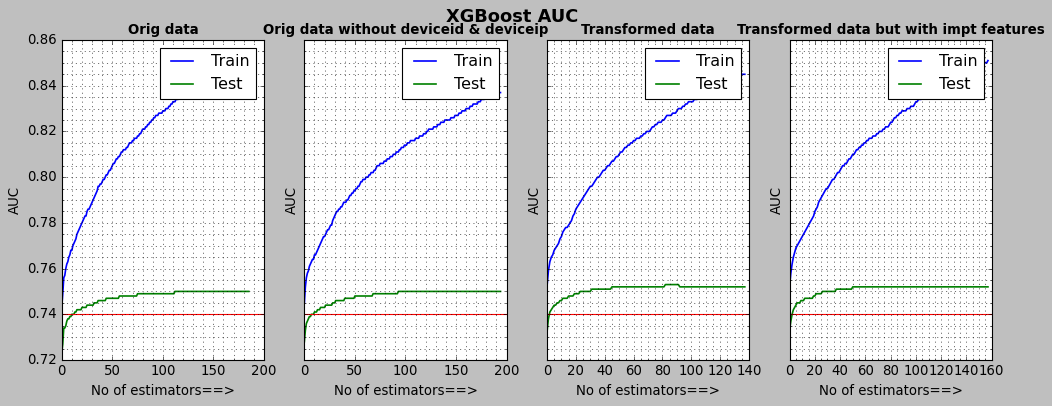

<Figure size 640x480 with 0 Axes>

In [122]:
# 12.0 Learning curves of all the three models

plt.style.use('classic')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,4, figsize = (15,5), sharey = True);
results = [model_orig.evals_result(), model_orig_noip.evals_result(),model_trans.evals_result(),model_trans_impt.evals_result() ]
title = ["Orig data", 'Orig data without deviceid & deviceip', 'Transformed data', 'Transformed data but with impt features']
_=fig.suptitle("XGBoost AUC", fontweight = "bold", fontsize = 16)

for i in range(4):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    _=ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=1.5, label='Train');
    _=ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=1.5, label='Test');
    _=ax[i].legend();
    _=ax[i].grid(visible = True, which = 'both');
    _=ax[i].minorticks_on();
    _=ax[i].set_ylabel('AUC');
    _=ax[i].set_xlabel('No of estimators==>');
    _=ax[i].set_title(title[i], fontsize = 12, fontweight = "bold");
    _=ax[i].axhline(y=0.74, color='r', linestyle='-')

_=plt.show();
_=plt.tight_layout()



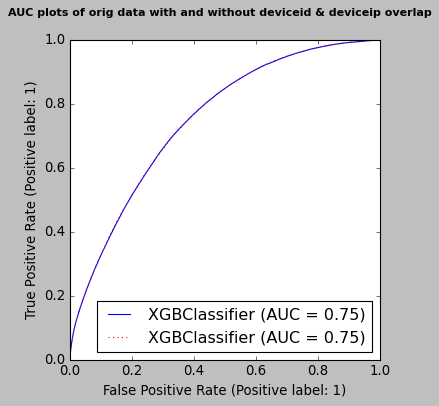

In [128]:
# 12.1 AUC plots of original data with deviceid and deviceip 
#      and of original data without deviceid and deviceip:

fig,ax = plt.subplots(1,1, figsize = (5,5));
fig.suptitle("AUC plots of orig data with and without deviceid & deviceip overlap", fontweight = "bold", fontsize = 10);
RocCurveDisplay.from_estimator(model_orig, X_test, y_test, ax = ax, color = "blue");
RocCurveDisplay.from_estimator(model_orig_noip, Xte, y_test, ax = ax, color = 'red',linestyle = ":" );


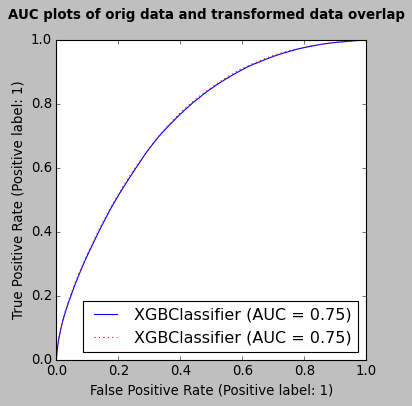

In [124]:
# 12.2 AUC plots of original data and of transformed data:

fig,ax = plt.subplots(1,1, figsize = (5,5));
fig.suptitle("AUC plots of orig data and transformed data overlap", fontweight = "bold", fontsize = 12);
RocCurveDisplay.from_estimator(model_orig, X_test, y_test, ax = ax, color = "blue");
RocCurveDisplay.from_estimator(model_trans, X_test_trans, y_test, ax = ax, color = 'red',linestyle = ":" , linewidth =1);


## Preparing for PCA--imputing data
PCAs of transformed data 

In [11]:
# 13.0 Check if any nulls in data
#       If so, we would impute using SimpleImputer:

X_train_trans.isnull().sum().sum()  # 0
X_test_trans.isnull().sum().sum()   # 63060/65406

X_train_trans.shape  # (1499627, 588)
X_test_trans.shape   # (499876, 588)

0

65406

In [13]:
# 13.1 Impute as test data has null values:
#      First reduce memory requirements:

X_train_trans_imputed = X_train_trans.astype('float32')
X_test_trans_imputed  = X_test_trans.astype('float32')

In [14]:
# 13.1 Impute as test data has null values:

 
_=gc.collect()

start = time.time()
print("Imputing....")
si = SimpleImputer(strategy = 'median')
X_train_trans_imputed[:] = si.fit_transform(X_train_trans_imputed)
X_test_trans_imputed[:] = si.transform(X_test_trans_imputed)
end = time.time()
print("Done: ", (end-start)/60)  # 2 min

Imputing....
Done:  2.501782472928365


In [16]:
# 13.1.1 Check for nulls again:

X_train_trans_imputed.isnull().sum().sum()  # 0
X_test_trans_imputed.isnull().sum().sum()   # 0

0

0

### Save imputed data

In [17]:
# 13.2 Save pca_train and pca_test for later experiments:

X_train_trans_imputed.to_pickle(Path(avazudata) / "X_train_trans_imputed.pkl")
X_test_trans_imputed.to_pickle(Path(avazudata) / "X_test_trans_imputed.pkl")

# 13.2.0 Datashapes
X_train_trans_imputed.shape  # (1501119, 586)/(1499049, 582)/(1499627, 588)
X_test_trans_imputed.shape   # (500374, 586)/(499684, 582)/(499876, 588)

(1499627, 588)

(499876, 588)

### Read imputed data

In [18]:
# 13.2.1 Read back saved pca_train and pca_test data:

X_train_trans_imputed = pd.read_pickle(Path(avazudata) / "X_train_trans_imputed.pkl")
X_test_trans_imputed = pd.read_pickle(Path(avazudata) / "X_test_trans_imputed.pkl")

# 13.2.2 Check
X_train_trans_imputed.shape  # (1501119, 586)/(1499493, 576)/(1499627, 588)
X_test_trans_imputed.shape   # (500374, 586)/(499831, 576)/(499876, 588)

(1499627, 588)

(499876, 588)

### Perform 95% PCA 

In [19]:
# 13.3 PCA with transformed train data.
#      Note that n_components = 0.95


pca = PCA(n_components= 0.95, whiten= True, random_state = None)
ss = StandardScaler()
pca_train = pca.fit_transform(ss.fit_transform(X_train_trans_imputed))
pca_test = pca.transform(ss.transform(X_test_trans_imputed))

# 13.3.1 Check data shapes:
pca_train.shape  # (1501119, 97)/(1499493, 96)/(1499627, 95)
pca_test.shape   # (500374, 97)/(499831, 96)/(499876, 95)

(1499627, 95)

(499876, 95)

In [20]:
# 13.4 Assign column names and transform to DataFrame;
gc.collect()
colnames = ["pc" + str(i) for i in range(pca_train.shape[1])]
pca_train = pd.DataFrame(pca_train, columns = colnames)
pca_test = pd.DataFrame(pca_test, columns = colnames)

# 13.4.1 Dataframe shapes:
pca_train.shape  # (1501119, 97)/(1499493, 96)/1499627, 95)
pca_test.shape   # (500374, 97)/(499831, 96)/(499876, 95)

0

(1499627, 95)

(499876, 95)

### Plotting PCA

In [21]:
# 13.5 Take a stratified sample for plotting:
#      Just 5000 samples:

_, pca_tr, _,pca_y  = train_test_split(pca_train, y_train,
                                       test_size = 5000,
                                       stratify = y_train
                                      )

# 13.5.1 Our data for plotting:
pca_tr.shape  # (5000, 97)/(5000, 95)
pca_y.shape   # (5000,)

(5000, 95)

(5000,)

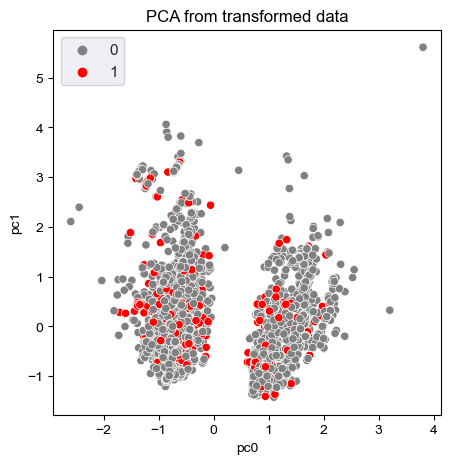

In [22]:
# 13.6 2D PCA plot from first two principal components:
#      Two clusters are evident:

fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
sns.set_theme() ; # Set default theme
sns.scatterplot(data = pca_tr,
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["grey", "red"]
                ).set(title='PCA from transformed data') ;

### Save 95% PCA data

In [25]:
# 14.0 Save pca_train and pca_test for later experiments:

pca_train.to_pickle(Path(avazudata) / "pca_train.pkl")
pca_test.to_pickle(Path(avazudata) / "pca_test.pkl")

### Read back 95% PCA data

In [26]:
# 14.1 Read back saved data:

pca_train = pd.read_pickle(Path(avazudata) / "pca_train.pkl")
pca_test =  pd.read_pickle(Path(avazudata) / "pca_test.pkl")

# 14.1.1 Check
pca_train.head(3)
pca_test.head(3)

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc85,pc86,pc87,pc88,pc89,pc90,pc91,pc92,pc93,pc94
0,-0.638945,-0.273593,0.645437,0.179956,-0.240778,0.775047,-0.107061,-0.851350,1.024698,0.046428,...,-0.203329,1.109340,0.534177,-0.068538,0.095007,1.040390,1.164250,0.539494,0.237366,1.175430
1,1.037587,-0.446642,0.089508,-0.065726,0.140498,1.076975,0.845084,-0.330704,1.738337,-0.333209,...,0.760136,0.213248,0.949808,-1.648649,0.708883,-1.319136,-0.380913,-0.280664,-0.801029,-1.171257
2,0.990892,0.328727,-0.949597,1.421613,-1.225103,0.473723,0.322878,-1.226321,-1.319040,0.828563,...,-0.537391,-0.862696,0.758568,0.436939,-0.615220,-0.593544,-0.377713,-0.414975,-1.035798,0.690630


,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc85,pc86,pc87,pc88,pc89,pc90,pc91,pc92,pc93,pc94
0,-0.682397,-0.082915,-0.160339,-0.128173,-0.674088,-0.358774,-0.145362,0.049941,0.488394,-0.178726,...,-0.210989,0.168379,-1.678568,-0.063104,-0.606669,-0.950322,0.035593,-0.115688,-0.161091,-0.726001
1,0.989976,-0.582692,-1.087699,1.235774,-0.439736,0.289243,0.646670,-0.026430,-1.188517,0.339656,...,-0.737263,0.120183,-0.272410,-1.463302,0.758092,0.601686,1.420018,1.530226,1.619366,3.017350
2,-0.678619,-0.144109,0.395423,-1.471165,-0.089432,-0.066942,0.140300,0.931160,-1.520803,0.488977,...,1.309468,0.469400,-0.337547,0.244402,-0.496468,0.471074,1.414774,-1.229016,-0.045719,1.266306


### xgboost modeling with all the PCA components

In [27]:
# 15.0 Prepare xgboost model--PCA data

# 15.0.1 We use class weights also:
#        Actually there is no benefit of class weights:

class_weights = {0: 1, 1: 10}
model_pca = xgb.XGBClassifier( n_estimators= 200,
                           verbosity = 3,
                           eta = 0.06,
                           max_depth = 15,
                           subsample = 0.8,
                           class_weight = class_weights,   
                           random_state = rng,
                           )


tr_X =   pca_train
test_X = pca_test
ytrain = y_train     
ytest = y_test       


model_pca.fit(tr_X, ytrain.values,
                     early_stopping_rounds = 50,   # 10% of n_estimators
                     eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                     eval_metric = ['auc']    # binary classification problem
                    )

[18:11:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "class_weight" } are not used.

[18:11:49] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[18:11:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 11494 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.74171	validation_1-auc:0.70481
[18:12:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 12120 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.76197	validation_1-auc:0.71639
[18:12:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 11332 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.77056	validation_1-auc:0.72144
[18:12:26] INFO: C:\Users\dev-admin\croot2\xgboost-spli

[35]	validation_0-auc:0.81868	validation_1-auc:0.73627
[18:17:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10362 extra nodes, 0 pruned nodes, max_depth=15
[36]	validation_0-auc:0.81983	validation_1-auc:0.73641
[18:17:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9078 extra nodes, 0 pruned nodes, max_depth=15
[37]	validation_0-auc:0.82067	validation_1-auc:0.73652
[18:17:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8960 extra nodes, 0 pruned nodes, max_depth=15
[38]	validation_0-auc:0.82158	validation_1-auc:0.73667
[18:17:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8726 extra nodes, 0 pruned nodes, max_depth=15
[39]	validation_0-auc:0.82240	validation_1-auc:0.73677
[18:18:04] INFO: C:\Users\dev-admin\croo

[72]	validation_0-auc:0.84967	validation_1-auc:0.73782
[18:23:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 7494 extra nodes, 0 pruned nodes, max_depth=15
[73]	validation_0-auc:0.85050	validation_1-auc:0.73779
[18:23:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4396 extra nodes, 0 pruned nodes, max_depth=15
[74]	validation_0-auc:0.85088	validation_1-auc:0.73783
[18:23:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 6208 extra nodes, 0 pruned nodes, max_depth=15
[75]	validation_0-auc:0.85140	validation_1-auc:0.73782
[18:23:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 6242 extra nodes, 0 pruned nodes, max_depth=15
[76]	validation_0-auc:0.85196	validation_1-auc:0.73780
[18:23:41] INFO: C:\Users\dev-admin\croot

[18:28:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 5864 extra nodes, 0 pruned nodes, max_depth=15
[109]	validation_0-auc:0.87399	validation_1-auc:0.73730
[18:28:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9024 extra nodes, 0 pruned nodes, max_depth=15
[110]	validation_0-auc:0.87503	validation_1-auc:0.73727
[18:28:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4400 extra nodes, 0 pruned nodes, max_depth=15
[111]	validation_0-auc:0.87550	validation_1-auc:0.73727
[18:29:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3016 extra nodes, 0 pruned nodes, max_depth=15
[112]	validation_0-auc:0.87577	validation_1-auc:0.73725
[18:29:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater

XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight={0: 1, 1: 10}, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              early_stopping_rounds=None, enable_categorical=False, eta=0.06,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None, ...)

In [28]:
# 15.0.2 Save model object:

utils.savePythonObject(model_pca, "model_pca.pkl", avazudata)


Object saved to: c:\avazu\allmodels\datafiles\model_pca.pkl


In [57]:
# 15.0.3 Restore model object:

model_pca = utils.restorePythonObject("model_pca.pkl", avazudata)

In [30]:
# 15.1 Best Scores:

model_pca.best_score     # 0.737592962/0.737141317(40L)/0.739549193473(20L)/0.73782514311684
model_pca.best_iteration # 62/87/74

0.7378251431168469

74

### Classification report
xgboost modeling with PCA data

In [31]:
# 15.2 Classification report of model with PCA data:

pred = model_pca.predict(test_X)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414913
           1       0.58      0.08      0.14     84963

    accuracy                           0.83    499876
   macro avg       0.71      0.53      0.53    499876
weighted avg       0.80      0.83      0.78    499876



In [ ]:
"""
                precision    recall  f1-score   support

           0       0.84      0.99      0.91    352805
           1       0.57      0.08      0.14     72357

    accuracy                           0.83    425162
   macro avg       0.71      0.53      0.52    425162
weighted avg       0.79      0.83      0.78    425162

               precision    recall  f1-score   support

           0       0.84      0.99      0.91    414878
           1       0.57      0.08      0.14     84806

    accuracy                           0.83    499684
   macro avg       0.70      0.53      0.52    499684
weighted avg       0.79      0.83      0.78    499684



"""

### Learning curve
xgboost modeling with PCA data

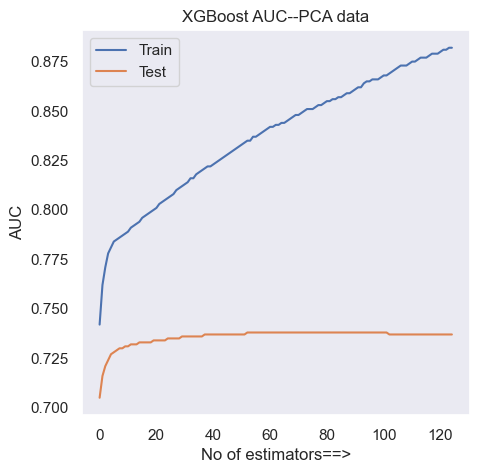

In [32]:
# 15.3 Learning curve of xgboost based on pca data:
# Ref: https://stackoverflow.com/a/60366515

fig, ax = plt.subplots(1,1, figsize = (5,5));

results = model_pca.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs);
ax.plot(x_axis, np.round(results['validation_0']['auc'],3), label='Train');
ax.plot(x_axis, np.round(results['validation_1']['auc'],3), label='Test');
ax.legend();
ax.grid();
ax.set_ylabel('AUC');
ax.set_xlabel('No of estimators==>')
ax.set_title("XGBoost AUC--PCA data");

## Balanacing PCA train data with `imblearn` library
We use imblearn library
>Balance with [`EditedNearestNeighbours`](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.EditedNearestNeighbours.html)<br>
>Balance with [`SMOTEENN`](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html)<br>

In [34]:
# 16.0 Call imblearn library:
from imblearn.under_sampling import EditedNearestNeighbours  
from imblearn.combine import SMOTEENN

## Using `EditedNearestNeighbours`
Undersamples majority class near decision boundary

In [35]:
# 16.1 Undersample PCA train data:

start = time.time()
undersample = EditedNearestNeighbours()   
X_res, y_res = undersample.fit_resample(pca_train, y_train)
end = time.time()
print((end-start)/60)  # 31min

# 16.1.1 Data shape
X_res.shape  #  (1075328, 97)/(1091067, 96)/(1089900, 95)
y_res.shape  #  (1075328,)/(1074577, )/(1091067,)/(1089900, )

31.105119387308758


(1089900, 95)

(1089900,)

### Plot of Ist two components of cleanedup data

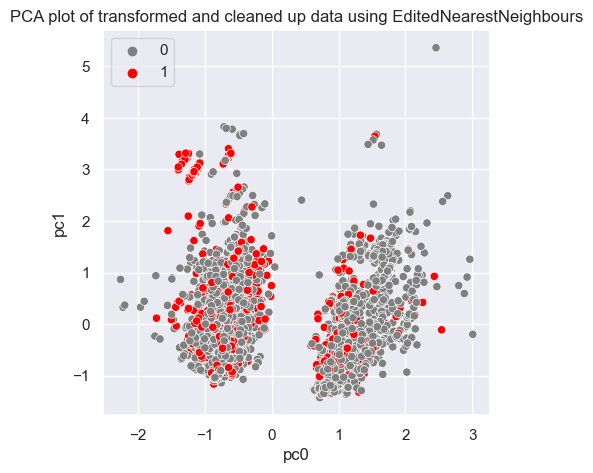

In [36]:
# 17.0 2D PCA plot from first two principal components:
#         First take a stratified sample for plotting
#         And then plot:

_, pca_tr, _,pca_y  = train_test_split(X_res, y_res, test_size = 5000, stratify = y_res)
pca_tr.shape  # (5000, 71)
pca_y.shape   # (5000,)

fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
sns.set_theme() ; 
sns.scatterplot(data = pca_tr,  # Sample of 5000
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["grey", "red"]
                ).set(title='PCA plot of transformed and cleaned up data using EditedNearestNeighbours') ;

### xgboost modeling with undersampled data

In [37]:
# 17.3 xgboost Modeling with undersampled data

model_en = xgb.XGBClassifier( n_estimators= 650 , #Needs to be reduced
                               verbosity = 3,
                               eta = 0.06,     
                               max_depth = 8,# Needs to be reduced
                               subsample = 0.9,          
                               random_state = rng,
                           )


tr_X =   X_res 
test_X = pca_test
ytrain = y_res 
ytest =  y_test


model_en.fit(tr_X, ytrain.values,                  
          early_stopping_rounds = 100,   
          eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['auc']    
          )



[19:21:27] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[19:21:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 342 extra nodes, 0 pruned nodes, max_depth=8
[0]	validation_0-auc:0.74628	validation_1-auc:0.68151
[19:21:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=8
[1]	validation_0-auc:0.75522	validation_1-auc:0.68829
[19:21:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 470 extra nodes, 0 pruned nodes, max_depth=8
[2]	validation_0-auc:0.76675	validation_1-auc:0.69662
[19:21:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 478 extra nodes, 0 pruned nodes, max_depth=8
[3]	validation_0-auc:0.76986	validation_1

[36]	validation_0-auc:0.79679	validation_1-auc:0.71621
[19:23:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 448 extra nodes, 0 pruned nodes, max_depth=8
[37]	validation_0-auc:0.79723	validation_1-auc:0.71643
[19:23:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 456 extra nodes, 0 pruned nodes, max_depth=8
[38]	validation_0-auc:0.79774	validation_1-auc:0.71673
[19:23:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 450 extra nodes, 0 pruned nodes, max_depth=8
[39]	validation_0-auc:0.79818	validation_1-auc:0.71695
[19:23:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 474 extra nodes, 0 pruned nodes, max_depth=8
[40]	validation_0-auc:0.79879	validation_1-auc:0.71734
[19:23:43] INFO: C:\Users\dev-admin\croot2\xgboos

[73]	validation_0-auc:0.81484	validation_1-auc:0.72584
[19:25:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 412 extra nodes, 0 pruned nodes, max_depth=8
[74]	validation_0-auc:0.81518	validation_1-auc:0.72599
[19:25:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 468 extra nodes, 0 pruned nodes, max_depth=8
[75]	validation_0-auc:0.81554	validation_1-auc:0.72616
[19:25:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 486 extra nodes, 0 pruned nodes, max_depth=8
[76]	validation_0-auc:0.81595	validation_1-auc:0.72633
[19:25:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 454 extra nodes, 0 pruned nodes, max_depth=8
[77]	validation_0-auc:0.81633	validation_1-auc:0.72648
[19:25:46] INFO: C:\Users\dev-admin\croot2\xgboos

[110]	validation_0-auc:0.82687	validation_1-auc:0.73070
[19:27:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 274 extra nodes, 0 pruned nodes, max_depth=8
[111]	validation_0-auc:0.82705	validation_1-auc:0.73077
[19:27:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 498 extra nodes, 0 pruned nodes, max_depth=8
[112]	validation_0-auc:0.82740	validation_1-auc:0.73091
[19:27:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=8
[113]	validation_0-auc:0.82753	validation_1-auc:0.73096
[19:27:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 494 extra nodes, 0 pruned nodes, max_depth=8
[114]	validation_0-auc:0.82787	validation_1-auc:0.73107
[19:27:51] INFO: C:\Users\dev-admin\croot2\x

[147]	validation_0-auc:0.83513	validation_1-auc:0.73333
[19:29:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 454 extra nodes, 0 pruned nodes, max_depth=8
[148]	validation_0-auc:0.83531	validation_1-auc:0.73335
[19:29:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 488 extra nodes, 0 pruned nodes, max_depth=8
[149]	validation_0-auc:0.83559	validation_1-auc:0.73344
[19:29:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 408 extra nodes, 0 pruned nodes, max_depth=8
[150]	validation_0-auc:0.83576	validation_1-auc:0.73350
[19:29:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 442 extra nodes, 0 pruned nodes, max_depth=8
[151]	validation_0-auc:0.83602	validation_1-auc:0.73358
[19:29:55] INFO: C:\Users\dev-admin\croot2\x

[184]	validation_0-auc:0.84195	validation_1-auc:0.73513
[19:31:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 490 extra nodes, 0 pruned nodes, max_depth=8
[185]	validation_0-auc:0.84218	validation_1-auc:0.73517
[19:31:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 492 extra nodes, 0 pruned nodes, max_depth=8
[186]	validation_0-auc:0.84239	validation_1-auc:0.73522
[19:31:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 492 extra nodes, 0 pruned nodes, max_depth=8
[187]	validation_0-auc:0.84263	validation_1-auc:0.73528
[19:31:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 426 extra nodes, 0 pruned nodes, max_depth=8
[188]	validation_0-auc:0.84283	validation_1-auc:0.73534
[19:32:00] INFO: C:\Users\dev-admin\croot2\x

[221]	validation_0-auc:0.84765	validation_1-auc:0.73628
[19:33:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 364 extra nodes, 0 pruned nodes, max_depth=8
[222]	validation_0-auc:0.84779	validation_1-auc:0.73629
[19:33:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 352 extra nodes, 0 pruned nodes, max_depth=8
[223]	validation_0-auc:0.84790	validation_1-auc:0.73631
[19:33:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 312 extra nodes, 0 pruned nodes, max_depth=8
[224]	validation_0-auc:0.84798	validation_1-auc:0.73632
[19:33:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 442 extra nodes, 0 pruned nodes, max_depth=8
[225]	validation_0-auc:0.84815	validation_1-auc:0.73635
[19:34:03] INFO: C:\Users\dev-admin\croot2\x

[258]	validation_0-auc:0.85215	validation_1-auc:0.73693
[19:35:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 482 extra nodes, 0 pruned nodes, max_depth=8
[259]	validation_0-auc:0.85234	validation_1-auc:0.73697
[19:35:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 472 extra nodes, 0 pruned nodes, max_depth=8
[260]	validation_0-auc:0.85252	validation_1-auc:0.73701
[19:35:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 458 extra nodes, 0 pruned nodes, max_depth=8
[261]	validation_0-auc:0.85269	validation_1-auc:0.73704
[19:36:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 458 extra nodes, 0 pruned nodes, max_depth=8
[262]	validation_0-auc:0.85288	validation_1-auc:0.73705
[19:36:06] INFO: C:\Users\dev-admin\croot2\x

[295]	validation_0-auc:0.85628	validation_1-auc:0.73741
[19:37:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 498 extra nodes, 0 pruned nodes, max_depth=8
[296]	validation_0-auc:0.85647	validation_1-auc:0.73744
[19:37:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 468 extra nodes, 0 pruned nodes, max_depth=8
[297]	validation_0-auc:0.85663	validation_1-auc:0.73745
[19:38:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 312 extra nodes, 0 pruned nodes, max_depth=8
[298]	validation_0-auc:0.85667	validation_1-auc:0.73745
[19:38:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 284 extra nodes, 0 pruned nodes, max_depth=8
[299]	validation_0-auc:0.85676	validation_1-auc:0.73744
[19:38:08] INFO: C:\Users\dev-admin\croot2\x

[332]	validation_0-auc:0.86013	validation_1-auc:0.73764
[19:39:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 460 extra nodes, 0 pruned nodes, max_depth=8
[333]	validation_0-auc:0.86029	validation_1-auc:0.73768
[19:40:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 398 extra nodes, 0 pruned nodes, max_depth=8
[334]	validation_0-auc:0.86040	validation_1-auc:0.73768
[19:40:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=8
[335]	validation_0-auc:0.86044	validation_1-auc:0.73769
[19:40:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 422 extra nodes, 0 pruned nodes, max_depth=8
[336]	validation_0-auc:0.86057	validation_1-auc:0.73770
[19:40:11] INFO: C:\Users\dev-admin\croot2\x

[369]	validation_0-auc:0.86399	validation_1-auc:0.73798
[19:42:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=8
[370]	validation_0-auc:0.86404	validation_1-auc:0.73798
[19:42:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 442 extra nodes, 0 pruned nodes, max_depth=8
[371]	validation_0-auc:0.86416	validation_1-auc:0.73799
[19:42:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=8
[372]	validation_0-auc:0.86422	validation_1-auc:0.73799
[19:42:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 280 extra nodes, 0 pruned nodes, max_depth=8
[373]	validation_0-auc:0.86429	validation_1-auc:0.73799
[19:42:14] INFO: C:\Users\dev-admin\croot2\x

[406]	validation_0-auc:0.86737	validation_1-auc:0.73818
[19:44:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 262 extra nodes, 0 pruned nodes, max_depth=8
[407]	validation_0-auc:0.86742	validation_1-auc:0.73817
[19:44:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 332 extra nodes, 0 pruned nodes, max_depth=8
[408]	validation_0-auc:0.86748	validation_1-auc:0.73818
[19:44:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 232 extra nodes, 0 pruned nodes, max_depth=8
[409]	validation_0-auc:0.86752	validation_1-auc:0.73819
[19:44:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 362 extra nodes, 0 pruned nodes, max_depth=8
[410]	validation_0-auc:0.86758	validation_1-auc:0.73819
[19:44:16] INFO: C:\Users\dev-admin\croot2\x

[443]	validation_0-auc:0.87008	validation_1-auc:0.73832
[19:46:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 352 extra nodes, 0 pruned nodes, max_depth=8
[444]	validation_0-auc:0.87019	validation_1-auc:0.73831
[19:46:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 336 extra nodes, 0 pruned nodes, max_depth=8
[445]	validation_0-auc:0.87025	validation_1-auc:0.73831
[19:46:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=8
[446]	validation_0-auc:0.87035	validation_1-auc:0.73832
[19:46:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 336 extra nodes, 0 pruned nodes, max_depth=8
[447]	validation_0-auc:0.87044	validation_1-auc:0.73832
[19:46:17] INFO: C:\Users\dev-admin\croot2\x

[480]	validation_0-auc:0.87322	validation_1-auc:0.73841
[19:48:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 192 extra nodes, 0 pruned nodes, max_depth=8
[481]	validation_0-auc:0.87326	validation_1-auc:0.73841
[19:48:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 348 extra nodes, 0 pruned nodes, max_depth=8
[482]	validation_0-auc:0.87335	validation_1-auc:0.73842
[19:48:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=8
[483]	validation_0-auc:0.87341	validation_1-auc:0.73843
[19:48:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 438 extra nodes, 0 pruned nodes, max_depth=8
[484]	validation_0-auc:0.87353	validation_1-auc:0.73845
[19:48:19] INFO: C:\Users\dev-admin\croot2\x

[517]	validation_0-auc:0.87598	validation_1-auc:0.73847
[19:50:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 370 extra nodes, 0 pruned nodes, max_depth=8
[518]	validation_0-auc:0.87607	validation_1-auc:0.73846
[19:50:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 422 extra nodes, 0 pruned nodes, max_depth=8
[519]	validation_0-auc:0.87617	validation_1-auc:0.73845
[19:50:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=8
[520]	validation_0-auc:0.87628	validation_1-auc:0.73845
[19:50:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 396 extra nodes, 0 pruned nodes, max_depth=8
[521]	validation_0-auc:0.87636	validation_1-auc:0.73847
[19:50:21] INFO: C:\Users\dev-admin\croot2\x

[554]	validation_0-auc:0.87874	validation_1-auc:0.73844
[19:52:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=8
[555]	validation_0-auc:0.87879	validation_1-auc:0.73845
[19:52:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 356 extra nodes, 0 pruned nodes, max_depth=8
[556]	validation_0-auc:0.87889	validation_1-auc:0.73846
[19:52:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 360 extra nodes, 0 pruned nodes, max_depth=8
[557]	validation_0-auc:0.87897	validation_1-auc:0.73845
[19:52:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 160 extra nodes, 0 pruned nodes, max_depth=8
[558]	validation_0-auc:0.87900	validation_1-auc:0.73845
[19:52:24] INFO: C:\Users\dev-admin\croot2\x

[591]	validation_0-auc:0.88139	validation_1-auc:0.73843
[19:54:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 286 extra nodes, 0 pruned nodes, max_depth=8
[592]	validation_0-auc:0.88146	validation_1-auc:0.73843
[19:54:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 380 extra nodes, 0 pruned nodes, max_depth=8
[593]	validation_0-auc:0.88155	validation_1-auc:0.73843
[19:54:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=8
[594]	validation_0-auc:0.88161	validation_1-auc:0.73843
[19:54:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 326 extra nodes, 0 pruned nodes, max_depth=8
[595]	validation_0-auc:0.88168	validation_1-auc:0.73843
[19:54:25] INFO: C:\Users\dev-admin\croot2\x

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=650, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [38]:
# 17.3.1:
gc.collect()
utils.savePythonObject(model_en, "model_en.pkl", avazudata)

174

Object saved to: c:\avazu\allmodels\datafiles\model_en.pkl


In [58]:
# 17.3.2

model_en = utils.restorePythonObject("model_en.pkl", avazudata)

In [40]:
# 17.4 Scores:

model_en.best_score     # 0.738117/0.739586872501523(20L)/0.7384465962155723
model_en.best_iteration # 78/42

0.7384994887211496

500

### Classification report
After balancing data with `EditedNearestNeighbours` class

In [41]:
# 17.5 Classification report xgboost model with undersampled PCA data:

pred = model_en.predict(test_X)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87    414913
           1       0.37      0.36      0.37     84963

    accuracy                           0.79    499876
   macro avg       0.62      0.62      0.62    499876
weighted avg       0.79      0.79      0.79    499876



In [ ]:
"""
                precision    recall  f1-score   support 

           0       0.87      0.86      0.87    415242
           1       0.36      0.39      0.38     85132

    accuracy                           0.78    500374
   macro avg       0.62      0.62      0.62    500374
weighted avg       0.79      0.78      0.78    500374

iter2
=====
               precision    recall  f1-score   support

           0       0.87      0.86      0.87    414878
           1       0.36      0.38      0.37     84806

    accuracy                           0.78    499684
   macro avg       0.62      0.62      0.62    499684
weighted avg       0.79      0.78      0.78    499684

"""

## Using `SMOTEENN`
For balancing PCA data

In [42]:

# 18.0 Instantiate SMOTEEN and use it on pca_train
gc.collect()
start= time.time()
sm = SMOTEENN(random_state=rng, n_jobs = -1)
X_res_sm, y_res_sm = sm.fit_resample(pca_train, y_train)
end = time.time()
print((end-start)/60)  # 103m (20L)

16

103.99348036050796


In [43]:
# 18.0.1 Data shape after SMOTEENN
gc.collect()
X_res_sm.shape  # (1688427, 97)/(1558844, 96)/(1557978, 95)/(1558408, 95)
y_res_sm.shape  # (1688427,),(1558844,)/(1557978,)/(1558408,)

0

(1558408, 95)

(1558408,)

In [44]:
# 18.0.2 
y_res_sm.value_counts()
y_res_sm.value_counts(normalize = True)  # 51%:48%

1    807636
0    750772
Name: click, dtype: int64

1    0.518244
0    0.481756
Name: click, dtype: float64

### Plot of Ist two components of cleanedup data

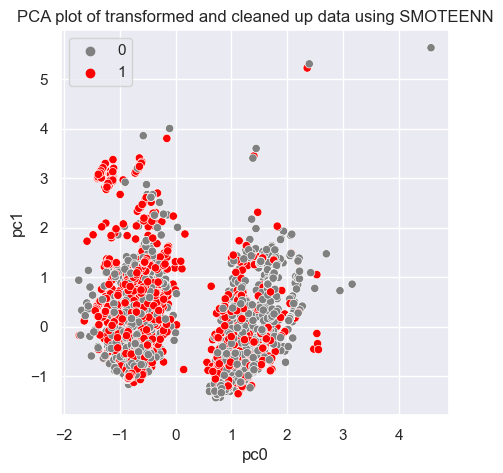

In [45]:
# 18.0.3 2D PCA plot from first two principal components:
#         First take a stratified sample for plotting
#         And then plot:

_, pca_tr, _,pca_y  = train_test_split(X_res_sm, y_res_sm, test_size = 5000, stratify = y_res_sm)
pca_tr.shape  # (5000, 71)
pca_y.shape   # (5000,)

fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
sns.set_theme() ; 
sns.scatterplot(data = pca_tr,  # Sample of 5000
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["grey", "red"]
                ).set(title='PCA plot of transformed and cleaned up data using SMOTEENN') ;

### xgboost modeling with balanced data (SMOTEENN)

In [46]:
# 19.0 Modeling with smoteenn data

model_sm = xgb.XGBClassifier( n_estimators= 650,   # Reduce it
                               verbosity = 3,
                               eta = 0.06,     
                               max_depth = 10,     # Reduce it
                               subsample = 0.8,          
                               random_state = rng,
                           )


tr_X =   X_res_sm 
test_X = pca_test
ytrain = y_res_sm 
ytest =  y_test


model_sm.fit(tr_X, ytrain.values,                  
                early_stopping_rounds = 100,   
                eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
                eval_metric = ['auc']    
                )



[21:38:44] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[21:38:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1220 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.81181	validation_1-auc:0.68854
[21:39:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1188 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.81857	validation_1-auc:0.69361
[21:39:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1218 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.83126	validation_1-auc:0.70172
[21:39:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1222 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.83699	vali

[21:43:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1294 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.86549	validation_1-auc:0.71884
[21:43:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1298 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.86604	validation_1-auc:0.71900
[21:43:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1276 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.86646	validation_1-auc:0.71913
[21:43:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1226 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.86694	validation_1-auc:0.71932
[21:43:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[72]	validation_0-auc:0.88761	validation_1-auc:0.72512
[21:48:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1634 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.88836	validation_1-auc:0.72539
[21:48:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1324 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.88883	validation_1-auc:0.72547
[21:48:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1678 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.88946	validation_1-auc:0.72561
[21:48:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1138 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.88977	validation_1-auc:0.72564
[21:48:30] INFO: C:\Users\dev-admin\croot

[21:52:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1738 extra nodes, 0 pruned nodes, max_depth=10
[109]	validation_0-auc:0.90577	validation_1-auc:0.72866
[21:52:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 842 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.90598	validation_1-auc:0.72867
[21:52:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1506 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.90638	validation_1-auc:0.72867
[21:52:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1244 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.90660	validation_1-auc:0.72867
[21:52:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_

[145]	validation_0-auc:0.91828	validation_1-auc:0.73005
[21:56:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1018 extra nodes, 0 pruned nodes, max_depth=10
[146]	validation_0-auc:0.91841	validation_1-auc:0.73005
[21:56:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1320 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.91864	validation_1-auc:0.73007
[21:56:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1718 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.91906	validation_1-auc:0.73011
[21:56:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1434 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.91932	validation_1-auc:0.73014
[21:56:52] INFO: C:\Users\dev-admin\

[22:00:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1204 extra nodes, 0 pruned nodes, max_depth=10
[182]	validation_0-auc:0.92735	validation_1-auc:0.73059
[22:00:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1212 extra nodes, 0 pruned nodes, max_depth=10
[183]	validation_0-auc:0.92752	validation_1-auc:0.73060
[22:00:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1480 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.92785	validation_1-auc:0.73063
[22:00:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1242 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.92811	validation_1-auc:0.73064
[22:00:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater

[218]	validation_0-auc:0.93582	validation_1-auc:0.73086
[22:04:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1194 extra nodes, 0 pruned nodes, max_depth=10
[219]	validation_0-auc:0.93603	validation_1-auc:0.73084
[22:04:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1380 extra nodes, 0 pruned nodes, max_depth=10
[220]	validation_0-auc:0.93626	validation_1-auc:0.73087
[22:04:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1332 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.93642	validation_1-auc:0.73086
[22:04:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1000 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.93660	validation_1-auc:0.73088
[22:04:45] INFO: C:\Users\dev-admin\

[22:08:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1268 extra nodes, 0 pruned nodes, max_depth=10
[255]	validation_0-auc:0.94294	validation_1-auc:0.73090
[22:08:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 724 extra nodes, 0 pruned nodes, max_depth=10
[256]	validation_0-auc:0.94301	validation_1-auc:0.73091
[22:08:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1394 extra nodes, 0 pruned nodes, max_depth=10
[257]	validation_0-auc:0.94321	validation_1-auc:0.73091
[22:08:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1460 extra nodes, 0 pruned nodes, max_depth=10
[258]	validation_0-auc:0.94343	validation_1-auc:0.73090
[22:08:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_

[291]	validation_0-auc:0.94804	validation_1-auc:0.73097
[22:12:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 576 extra nodes, 0 pruned nodes, max_depth=10
[292]	validation_0-auc:0.94811	validation_1-auc:0.73096
[22:12:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 870 extra nodes, 0 pruned nodes, max_depth=10
[293]	validation_0-auc:0.94822	validation_1-auc:0.73096
[22:12:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1234 extra nodes, 0 pruned nodes, max_depth=10
[294]	validation_0-auc:0.94836	validation_1-auc:0.73096
[22:12:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1202 extra nodes, 0 pruned nodes, max_depth=10
[295]	validation_0-auc:0.94850	validation_1-auc:0.73094
[22:12:36] INFO: C:\Users\dev-admin\cr

[22:16:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1168 extra nodes, 0 pruned nodes, max_depth=10
[328]	validation_0-auc:0.95302	validation_1-auc:0.73085
[22:16:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 744 extra nodes, 0 pruned nodes, max_depth=10
[329]	validation_0-auc:0.95311	validation_1-auc:0.73084
[22:16:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1508 extra nodes, 0 pruned nodes, max_depth=10
[330]	validation_0-auc:0.95326	validation_1-auc:0.73083
[22:16:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1136 extra nodes, 0 pruned nodes, max_depth=10
[331]	validation_0-auc:0.95338	validation_1-auc:0.73084
[22:16:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_

[364]	validation_0-auc:0.95724	validation_1-auc:0.73058
[22:19:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1462 extra nodes, 0 pruned nodes, max_depth=10
[365]	validation_0-auc:0.95738	validation_1-auc:0.73058
[22:20:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1164 extra nodes, 0 pruned nodes, max_depth=10
[366]	validation_0-auc:0.95747	validation_1-auc:0.73057
[22:20:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1438 extra nodes, 0 pruned nodes, max_depth=10
[367]	validation_0-auc:0.95761	validation_1-auc:0.73057
[22:20:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 714 extra nodes, 0 pruned nodes, max_depth=10
[368]	validation_0-auc:0.95766	validation_1-auc:0.73057
[22:20:22] INFO: C:\Users\dev-admin\c

[22:23:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1126 extra nodes, 0 pruned nodes, max_depth=10
[401]	validation_0-auc:0.96063	validation_1-auc:0.73041
[22:23:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1222 extra nodes, 0 pruned nodes, max_depth=10
[402]	validation_0-auc:0.96073	validation_1-auc:0.73041
[22:24:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1016 extra nodes, 0 pruned nodes, max_depth=10
[403]	validation_0-auc:0.96081	validation_1-auc:0.73040
[22:24:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 748 extra nodes, 0 pruned nodes, max_depth=10
[404]	validation_0-auc:0.96085	validation_1-auc:0.73040
[22:24:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=650, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [47]:
# 19.0.1
gc.collect()
utils.savePythonObject(model_sm, "model_sm.pkl", avazudata)

4044

Object saved to: c:\avazu\allmodels\datafiles\model_sm.pkl


In [59]:
# 19.0.2
model_sm = utils.restorePythonObject("model_sm.pkl", avazudata)

In [49]:
# 19.1 score
model_sm.best_score   # 0.7320805711/0.73260329129(20L)/0.7305378582/0.730988385236
model_sm.best_iteration  # 230/222/308

0.7309883852363577

308

### Classification report
After balancing with `SMOTEENN` class 

In [50]:
# 19.2 
pred = model_sm.predict(test_X)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.91      0.62      0.74    414913
           1       0.28      0.72      0.40     84963

    accuracy                           0.64    499876
   macro avg       0.60      0.67      0.57    499876
weighted avg       0.81      0.64      0.68    499876



In [ ]:
"""
               precision    recall  f1-score   support

           0       0.93      0.54      0.69    415242
           1       0.26      0.79      0.40     85132

    accuracy                           0.59    500374
   macro avg       0.60      0.67      0.54    500374
weighted avg       0.82      0.59      0.64    500374


               precision    recall  f1-score   support

           0       0.93      0.55      0.69    414878
           1       0.26      0.79      0.40     84806

    accuracy                           0.59    499684
   macro avg       0.60      0.67      0.54    499684
weighted avg       0.81      0.59      0.64    499684

"""

### Learning plots
xgboost modeling with the two class balancing techniques

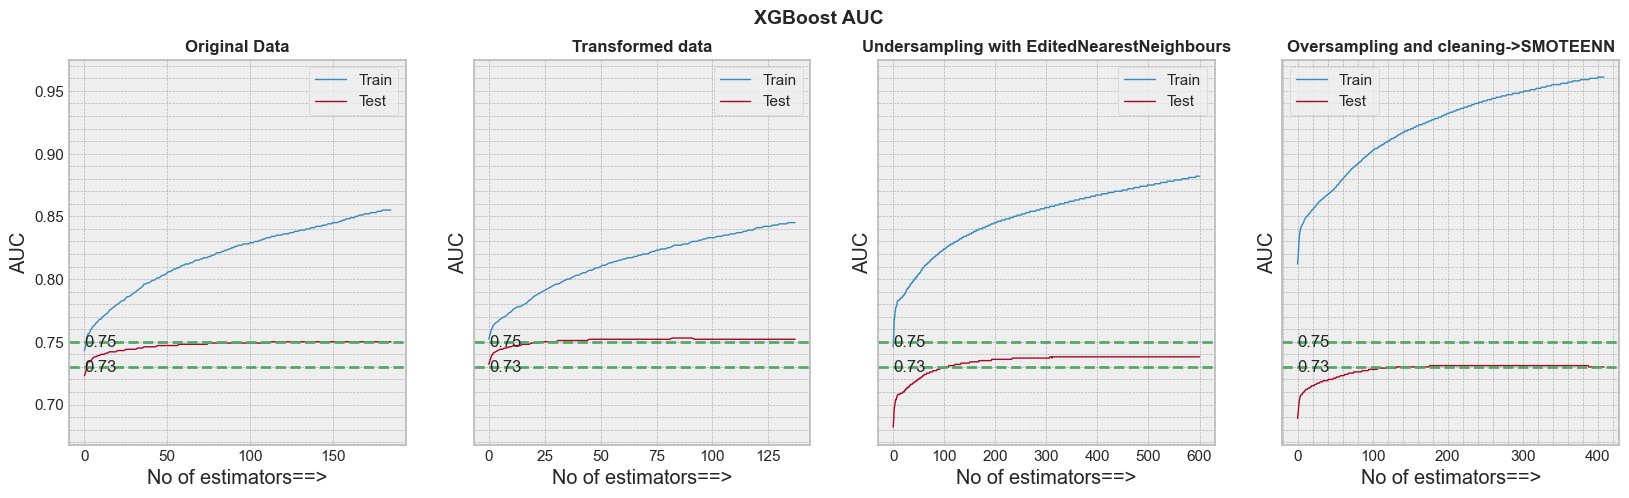

In [60]:

# 19.3 Learning curves: xgboost modeling"

plt.style.use('bmh')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,4, figsize = (20,5), sharey = True);
results = [model_orig.evals_result(), model_trans.evals_result(), model_en.evals_result(),model_sm.evals_result()]
title = ["Original Data", "Transformed data", "Undersampling with EditedNearestNeighbours", 'Oversampling and cleaning->SMOTEENN']
fig.suptitle("XGBoost AUC", fontweight = "bold", fontsize = 14)
for i in range(4):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=1, label='Train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=1, label='Test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    plt.minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel('No of estimators==>')
    ax[i].set_title(title[i], fontsize = 12, fontweight = "bold");
    ax[i].axhline(y=0.75, color='g', linestyle='--', label='p=0.05')
    ax[i].axhline(y=0.73, color='g', linestyle='--')
    ax[i].text(0, 0.75, '0.75', ha='left', va='center')
    ax[i].text(0, 0.73, '0.73', ha='left', va='center')
   
plt.show();

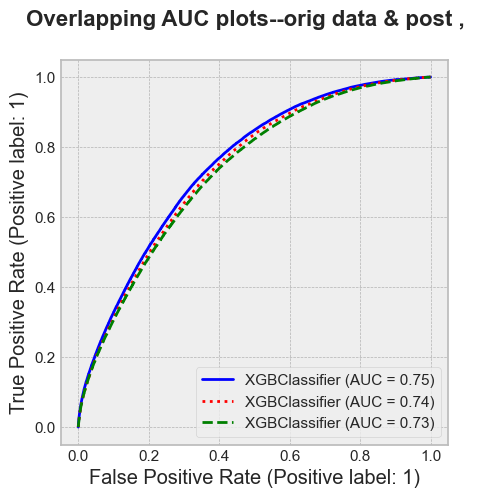

In [61]:
# 19.3.1 AUC plots:

fig,ax = plt.subplots(1,1, figsize = (5,5));
fig.suptitle("Overlapping AUC plots--orig data & post , ", fontweight = "bold", fontsize = 16);
RocCurveDisplay.from_estimator(model_orig, X_test, y_test, ax = ax, color = "blue", );
RocCurveDisplay.from_estimator(model_en, pca_test, y_test, ax = ax, color = 'red',linestyle = ":" , linewidth =2);
RocCurveDisplay.from_estimator(model_sm, pca_test, y_test, ax = ax, color = 'green',linestyle = "--" , linewidth =2);

## Cohen's Kappa, Matthews correlation coefficient and F1-score

### Kappa for model with original data:

In [62]:

y1 = model_orig.predict(X_test)
ck_orig = cohen_kappa_score(y_test,y1)    
ck_orig    # 0.11257330895233153

0.11489908558688777

### Kappa for model with transformed data

In [63]:
y1 = model_trans.predict(X_test_trans)
ck_trans = cohen_kappa_score(y1,y_test)    # 0.11912953935895365
ck_trans    #  0.11912953935895365

0.11972614252777602

### Kappa for model with data processed using  `EditedNearestNeighbours`

In [64]:
y1 = model_en.predict(pca_test)
ck_en = cohen_kappa_score(y1,y_test)   
ck_en    # 0.23512337449863685

0.2400962494079989

### Kappa for model with data processed using `SMOTEENN`

In [65]:
y1 = model_sm.predict(pca_test)
ck_sm = cohen_kappa_score(y1,y_test)   
ck_sm   # 0.2059553018588994

0.20882379744237933

### Matthews correlation coefficient for model with original data

In [66]:
y1 = model_orig.predict(X_test)
mcc_orig = matthews_corrcoef(y_test,y1)   # 0.18001543725080113
mcc_orig   # 0.18001543725080113

0.1828782108185615

### Matthews correlation coefficient for model with transformed data

In [67]:
y1 = model_trans.predict(X_test_trans)
mcc_trans = matthews_corrcoef(y_test,y1)   # 0.185746655042
mcc_trans  # 0.185746655042

0.18776259500774767

### Matthews correlation coefficient for model with  `EditedNearestNeighbours`

In [68]:
y1 = model_en.predict(pca_test)
mcc_en = matthews_corrcoef(y_test,y1)
mcc_en #0.2351474205514198

0.24012389586922864

### Matthews correlation coefficient for model with `SMOTEENN` data

In [69]:
y1 = model_sm.predict(pca_test)
mcc_sm = matthews_corrcoef(y_test,y1)    
mcc_sm # 0.256392613027669


0.2567056460416126

In [70]:
# F1 score for different models:

f1_orig = f1_score(y_test, model_orig.predict(X_test))
f1_trans = f1_score(y_test, model_trans.predict(X_test_trans))
f1_en = f1_score(y_test, model_en.predict(pca_test))
f1_sm = f1_score(y_test, model_sm.predict(pca_test))


In [71]:
# Add labels to bar chart
# Ref: https://stackoverflow.com/a/48372659/3282777

def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

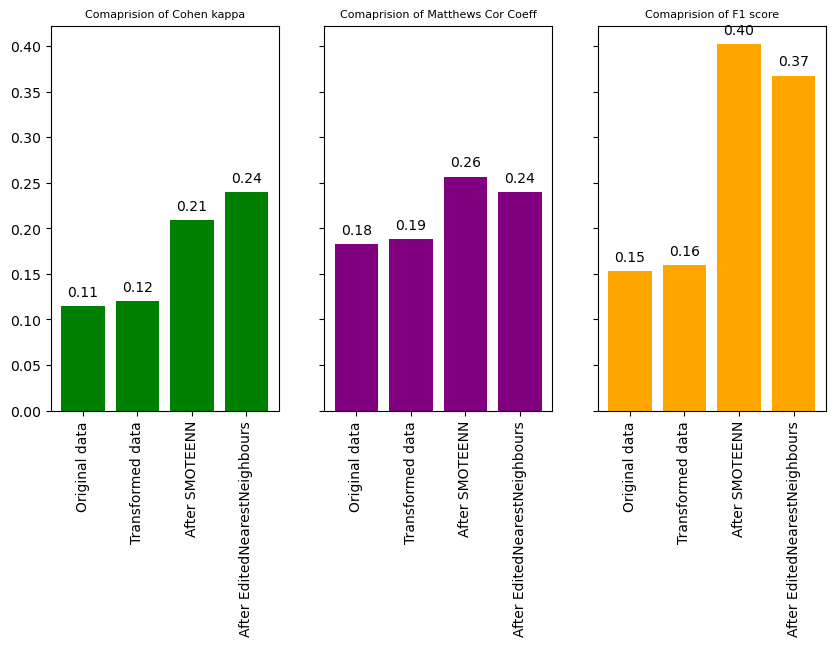

In [72]:
# Combined plots:
plt.style.use('default')
fig,ax = plt.subplots(1,3,sharey = True, figsize= (10,5))
xlabels = ['Original data', 'Transformed data', 'After SMOTEENN', 'After EditedNearestNeighbours']
yvalues_ck = [ck_orig,ck_trans,ck_sm,ck_en]
yvalues_mcc = [mcc_orig,mcc_trans,mcc_sm,mcc_en]
yvalues_f1 = [f1_orig,f1_trans,f1_sm,f1_en]
ax[0].bar(xlabels,yvalues_ck,color = 'green');
ax[1].bar(xlabels,yvalues_mcc, color = 'purple');
ax[2].bar(xlabels,yvalues_f1, color = 'orange');
ax[0].set_xticklabels(xlabels, rotation=90)
ax[1].set_xticklabels(xlabels, rotation=90)
ax[2].set_xticklabels(xlabels, rotation=90)
ax[0].set_title("Comaprision of Cohen kappa", fontsize = 8)
ax[1].set_title("Comaprision of Matthews Cor Coeff", fontsize = 8)
ax[2].set_title("Comaprision of F1 score", fontsize = 8)
add_value_labels(ax[0])
add_value_labels(ax[1])
add_value_labels(ax[2])
plt.show();


## Distribution of transformed features:

eigenvector          0.369863
degree               0.315068
pagerank             0.315068
clusteringcoeff      0.000000
betweenness          0.000000
avgembeddedness      0.000000
leidencomsdensity    0.000000
dtype: float64

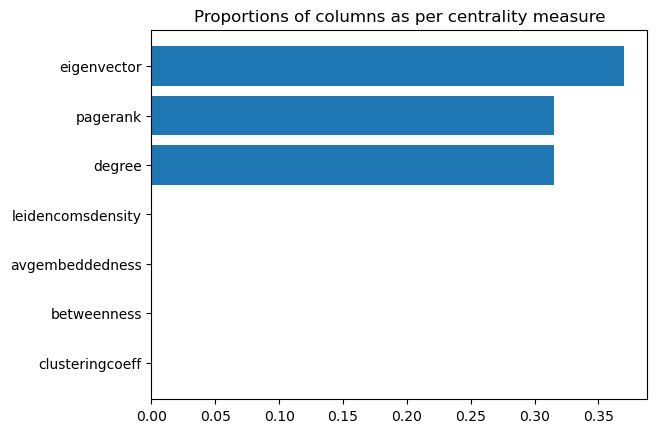

In [73]:
# Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

# 20.0 Our list of columns

colList = X_train_trans.columns

# 20.0.1 Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
f
utils.plotSeries(f, "Proportions of columns as per centrality measure")


### Proportions of columns by centrality whose impt is > 0

In [74]:
# 20.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"

Order of feature importance is by 'gain'


'Columns whose impt is >0: 411'

'Columns whose impt is 0: 177'

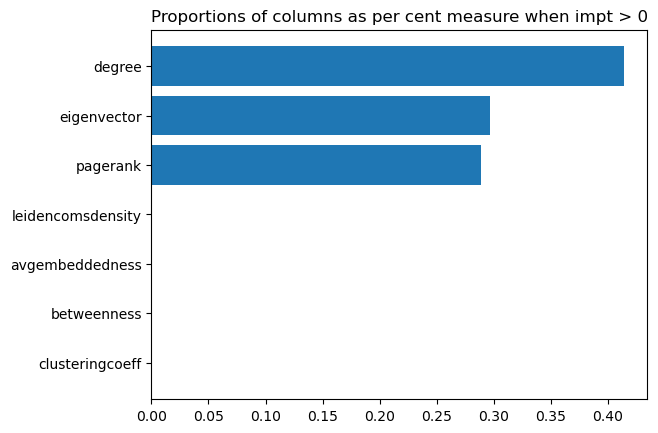

In [75]:
# 20.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")



### Proportions of columns by summed-up importance score of each centrality measure

Order of feature importance is by 'gain'


deg_Ctwentyone_ck_devicemodel    0.228290
pr_Ctwentyone_ck_devicemodel     0.090174
deg_Cseventeen_ck_Csixteen       0.076567
deg_Cseventeen_ck_Ceighteen      0.058265
eig_appdomain_ck_Ctwentyone      0.029723
Name: imp, dtype: float32

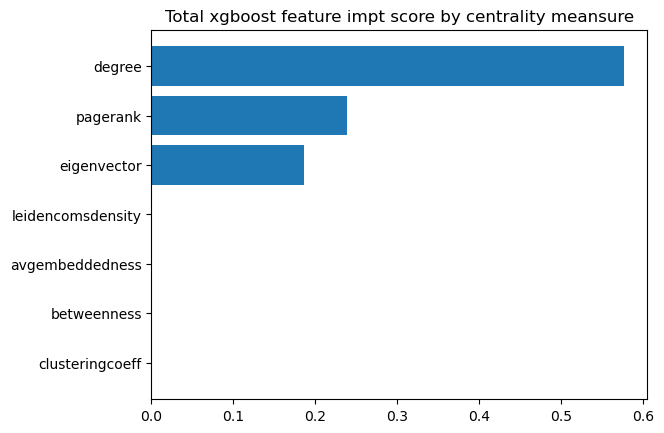

In [76]:
# 20.3 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)

# 20.4 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 13.2 Score of top-five columns:
score[:5]

# 20.5 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

In [ ]:
##*****************************
## Embedding Projector
##*****************************

## Derive unitvectors

### Readback saved data

In [86]:
# 21.2 Readback all saved files

train_trans = pd.read_pickle(Path(avazudata) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazudata) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazudata) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazudata) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazudata) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazudata) / "y_test.pkl")


# 21.2.1 Reindex X_train/X_test for concatenation
#        of cat cols to be possible with transformed data
X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 21.2.2 Recheck indexing:
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 21.2.3
train_trans.shape   # (1499493, 591)/(1499627, 603)
y_train.shape       # (1501119,)/(1499627, )
test_trans.shape    # (499831, 591)/(499876, 603)
y_test.shape        # (500374,)/(499876, )


f"Total cols in X_train: {X_train.shape[1]}"
# 21.2.4 Our list of cat cols
cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']  # 19 cols

f"Length of cat cols: {len(cat_cols)}"

# 21.2.5 Remaining cols not treated as cat cols:
rem_cols = ['day', 'dayofweek', 'hour_time', 'month','device_ip','device_id',]  # 6 cols
f"Length of remaining cols: {len(rem_cols)}"



# 21.3 Concat rem_cols with transformed data:
# 21.4 Columns after transformeation to be considered. Ignore initial cat_cols
cols = train_trans.columns[len(cat_cols):]

# 21.5 Now horizontally concatenate (exclude device_id and device):
X_train_trans = pd.concat([X_train[rem_cols[:4]], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols[:4]], test_trans[cols] ], axis = 1)
                           
# 21.6 Check
X_train_trans.shape  # (1499493, 576)/(1499627, 588) (603-19+4 = 588)
X_test_trans.shape   # (499831, 576)/(499876, 588)

# 13.2.1 Read back saved imputed data:

X_train_trans_imputed = pd.read_pickle(Path(avazudata) / "X_train_trans_imputed.pkl")
X_test_trans_imputed = pd.read_pickle(Path(avazudata) / "X_test_trans_imputed.pkl")

# 13.2.2 Check
X_train_trans_imputed.shape  # (1501119, 586)/(1499493, 576)/(1499627, 588)
X_test_trans_imputed.shape   # (500374, 586)/(499831, 576)/(499876, 588)

# 8.1.2 And read back saved class object:
ct = utils.restorePythonObject("transformer.pkl", avazudata)
ct

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,1574,1291,21,3628,117,0,4698,1,...,-0.243593,0.576271,0.085636,0.015776,0.694915,0.200549,0.031601,1.000000,0.145756,0.021024
1,1005,0,1601,2711,5,342,33,25,3054,1,...,0.083977,0.406780,0.069757,0.011329,0.796610,0.204143,0.039064,0.983051,0.145142,0.020576


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,2512,492,21,3628,117,0,3087,1,...,-0.098470,0.898305,0.155467,0.022091,0.576271,0.185918,0.025910,0.847458,0.137501,0.017503
1,1005,0,1601,2711,5,2251,33,4,1735,1,...,0.057405,0.881356,0.159557,0.021131,0.728814,0.202016,0.035033,1.000000,0.145756,0.021024


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,1574,1291,21,3628,117,0,184820,163388,...,50,1863,3,39,100103,23,10,4,24,12
1,1005,0,1601,2711,5,342,33,25,184820,814998,...,50,2348,3,427,100003,61,10,2,22,6


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,2512,492,21,3628,117,0,184820,398861,...,50,2283,0,163,-1,95,10,4,24,6
1,1005,0,1601,2711,5,2251,33,4,42683,98923,...,480,2502,0,35,-1,221,10,1,21,13


(1499627, 603)

(1499627,)

(499876, 603)

(499876,)

19

(1499627, 588)

(499876, 588)

(1499627, 588)

(499876, 588)

CatEncodersFamily(avoidInteractionFeatures=[],
                  cMeasures=[1, 1, 1, 0, None, 0, 0], mergelevelsincols=[],
                  modelsPath=WindowsPath('c:/avazu/allmodels/models'),
                  pathToStoreProgress=WindowsPath('c:/avazu/allmodels'),
                  saveGraph=True)

In [78]:
# 21.5 Now horizontally concatenate (exclude device_id and device):
gc.collect()
X_train_trans_imputed = pd.concat([X_train[cat_cols], X_train_trans_imputed ],  axis = 1)
X_test_trans_imputed = pd.concat([X_test[cat_cols], X_test_trans_imputed ], axis = 1)

X_train_trans_imputed.shape # (1499627, 607) (588+19= 607)
X_test_trans_imputed.shape # (499876, 607)

0

(1499627, 607)

(499876, 607)

In [83]:
# Columns include all cat cols as also transformed columns:
X_train_trans_imputed.columns[:30]
X_train_trans_imputed.columns[-25:]

Index(['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory', 'appid',
       'appdomain', 'appcategory', 'devicemodel', 'devicetype',
       'deviceconntype', 'Cfourteen', 'Cfifteen', 'Csixteen', 'Cseventeen',
       'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone', 'day', 'dayofweek',
       'hour_time', 'month', 'deg_siteid_ck_Cone', 'eig_siteid_ck_Cone',
       'pr_siteid_ck_Cone', 'deg_siteid_ck_bannerpos',
       'eig_siteid_ck_bannerpos', 'pr_siteid_ck_bannerpos',
       'deg_siteid_ck_sitedomain'],
      dtype='object')

Index(['pr_Ctwentyone_ck_appcategory', 'deg_Ctwentyone_ck_devicemodel',
       'eig_Ctwentyone_ck_devicemodel', 'pr_Ctwentyone_ck_devicemodel',
       'deg_Ctwentyone_ck_devicetype', 'eig_Ctwentyone_ck_devicetype',
       'pr_Ctwentyone_ck_devicetype', 'eig_Ctwentyone_ck_deviceconntype',
       'eig_Ctwentyone_ck_Cfourteen', 'deg_Ctwentyone_ck_Cfifteen',
       'eig_Ctwentyone_ck_Cfifteen', 'pr_Ctwentyone_ck_Cfifteen',
       'deg_Ctwentyone_ck_Csixteen', 'eig_Ctwentyone_ck_Csixteen',
       'pr_Ctwentyone_ck_Csixteen', 'eig_Ctwentyone_ck_Cseventeen',
       'deg_Ctwentyone_ck_Ceighteen', 'eig_Ctwentyone_ck_Ceighteen',
       'pr_Ctwentyone_ck_Ceighteen', 'deg_Ctwentyone_ck_Cnineteen',
       'eig_Ctwentyone_ck_Cnineteen', 'pr_Ctwentyone_ck_Cnineteen',
       'deg_Ctwentyone_ck_Ctwenty', 'eig_Ctwentyone_ck_Ctwenty',
       'pr_Ctwentyone_ck_Ctwenty'],
      dtype='object')

In [84]:
# 'target' is not here
'target' in list(X_train_trans_imputed.columns)
'target' in list(X_test_trans_imputed.columns)

False

False

In [85]:
# 21.4 Get target data col.
#      Needed for generation of meta-data file:

X_test_trans_imputed['target'] = y_test
X_train_trans_imputed['target'] =  y_train

In [11]:
# 22.0 Derive unit vectors:

p = Path(avazuunitvecs)
p.mkdir(parents=True, exist_ok=True)

vec_tr,_ = ct.vectorsToTSV(X_train_trans_imputed,
                           take_mean = False,
                           filepath = avazuunitvecs ,   # Folder where csv files will be saved
                           saveVectorsToDisk = True
                           )



Checking if vectors exist for all cat cols...
May take time...
Checked for Cone
Checked for bannerpos
Checked for siteid
Checked for sitedomain
Checked for sitecategory
Checked for appid
Checked for appdomain
Checked for appcategory
Checked for devicemodel
Checked for devicetype
Checked for deviceconntype
Checked for Cfourteen
Checked for Cfifteen
Checked for Csixteen
Checked for Cseventeen
Checked for Ceighteen
Checked for Cnineteen
Checked for Ctwenty
Checked for Ctwentyone
For these columns we do not have vectors:  ['Cone', 'bannerpos', 'devicetype', 'deviceconntype', 'Cfifteen', 'Csixteen', 'Ceighteen']
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: 'c:\avazu\allmodels\unitvectors'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature


In [13]:
# 22.2 Save dict to gdrive:
gc.collect()
utils.savePythonObject(vec_tr, "vec_tr.pkl", avazuunitvecs )

0

Object saved to: c:\avazu\allmodels\unitvectors\vec_tr.pkl


In [14]:
# 22.1 Unit vectors from test data. But not being saved to file:
gc.collect()
vec_te,_ = ct.vectorsToTSV(X_test_trans_imputed,
                           take_mean = False,
                           filepath = avazuunitvecs ,
                           impute = True,
                           saveVectorsToDisk = False
                           )

0

Checking if vectors exist for all cat cols...
May take time...
Checked for Cone
Checked for bannerpos
Checked for siteid
Checked for sitedomain
Checked for sitecategory
Checked for appid
Checked for appdomain
Checked for appcategory
Checked for devicemodel
Checked for devicetype
Checked for deviceconntype
Checked for Cfourteen
Checked for Cfifteen
Checked for Csixteen
Checked for Cseventeen
Checked for Ceighteen
Checked for Cnineteen
Checked for Ctwenty
Checked for Ctwentyone
For these columns we do not have vectors:  ['Cone', 'bannerpos', 'devicetype', 'deviceconntype', 'Cfifteen', 'Csixteen', 'Ceighteen']


### Save unitvectors files to gdrive
Also save output dictionaries for later use

In [15]:
# 22.2 Save dict to gdrive:

utils.savePythonObject(vec_te, "vec_te.pkl",avazuunitvecs )

Object saved to: c:\avazu\allmodels\unitvectors\vec_te.pkl


### Restore unitvectors files from gdrive

In [16]:
# 22.3 Restore back:
vec_tr = utils.restorePythonObject( "vec_tr.pkl", avazuunitvecs )
vec_te = utils.restorePythonObject("vec_te.pkl",avazuunitvecs )
gc.collect()

0

### Using unit vectors to transform train/test data

In [17]:
# 23.0 USe unit vectors to transform train/test data:
cctr,ccte, vtr,vte = utils.pcaAndConcat(vec_tr, vec_te, n_components = 4)

# 23.1

cctr.head(3)
ccte.head(3)

# 23.2

cctr.shape   #  (1499493, 48)/(1499627, 48)
ccte.shape   #  (499831, 48)/(499876, 48)

Performing PCA for column, siteid , in train data
Performing PCA for column, siteid , in test data
Performing PCA for column, sitedomain , in train data
Performing PCA for column, sitedomain , in test data
Performing PCA for column, sitecategory , in train data
Performing PCA for column, sitecategory , in test data
Performing PCA for column, appid , in train data
Performing PCA for column, appid , in test data
Performing PCA for column, appdomain , in train data
Performing PCA for column, appdomain , in test data
Performing PCA for column, appcategory , in train data
Performing PCA for column, appcategory , in test data
Performing PCA for column, devicemodel , in train data
Performing PCA for column, devicemodel , in test data
Performing PCA for column, Cfourteen , in train data
Performing PCA for column, Cfourteen , in test data
Performing PCA for column, Cseventeen , in train data
Performing PCA for column, Cseventeen , in test data
Performing PCA for column, Cnineteen , in train dat

,pcsiteid0,pcsiteid1,pcsiteid2,pcsiteid3,pcsitedomain0,pcsitedomain1,pcsitedomain2,pcsitedomain3,pcsitecategory0,pcsitecategory1,...,pcCnineteen2,pcCnineteen3,pcCtwenty0,pcCtwenty1,pcCtwenty2,pcCtwenty3,pcCtwentyone0,pcCtwentyone1,pcCtwentyone2,pcCtwentyone3
0,2.889698,-0.597556,-0.605230,-0.983609,5.770558,-0.088779,0.976720,-0.682658,-6.472119,1.824779,...,-1.146290,0.905156,4.056123,4.829279,4.013891,0.024356,-1.531163,-1.134482,1.941805,-0.563826
1,-6.821252,-0.074456,0.273082,0.473605,-6.375553,-0.859748,0.679954,0.400250,1.803573,-2.779584,...,-0.300842,-1.985813,12.144095,3.178164,-0.957187,5.059063,-1.254416,-1.146793,1.413668,-1.389424
2,-6.821253,-0.073874,0.302884,0.500631,-6.375553,-0.859665,0.707247,0.438487,1.803671,-2.779428,...,-1.027415,0.983386,-5.078746,-0.213793,-0.088795,0.746517,-1.530887,-1.141361,1.964717,-0.574715


,pcsiteid0,pcsiteid1,pcsiteid2,pcsiteid3,pcsitedomain0,pcsitedomain1,pcsitedomain2,pcsitedomain3,pcsitecategory0,pcsitecategory1,...,pcCnineteen2,pcCnineteen3,pcCtwenty0,pcCtwenty1,pcCtwenty2,pcCtwenty3,pcCtwentyone0,pcCtwentyone1,pcCtwentyone2,pcCtwentyone3
0,5.327249,1.232158,0.846737,0.695078,-2.509640,3.133112,-2.559268,-0.610693,-6.472470,1.827506,...,-0.276160,-0.673143,-5.078818,-0.213792,-0.089764,0.732784,-1.780591,1.000154,-1.69990,0.392203
1,-6.821211,-0.073856,0.303019,0.497530,-6.375741,-0.859648,0.703604,0.442896,1.803659,-2.779504,...,0.665096,-0.373369,-5.078818,-0.213792,-0.089764,0.732784,-4.760294,-2.142277,-0.46408,0.924828
2,4.224539,-1.295526,-1.220209,-0.389639,6.814605,-0.838232,0.547893,-1.040711,2.012367,-0.608370,...,2.105631,1.792296,-5.078818,-0.213792,-0.089764,0.732784,-3.351036,-0.609262,-1.33959,0.949176


(1499627, 48)

(499876, 48)

### Save unitvectors transformed train/test

In [18]:
# 23.4 Save cctr/ccte to gdrive
cctr.to_pickle(avazuunitvecs  / "cctr.pkl")
ccte.to_pickle(avazuunitvecs  / "ccte.pkl")


### Readback unitvectors transformed train/test

In [19]:
# 24.0 Read back cctr/ccte
cctr = pd.read_pickle(avazuunitvecs  / "cctr.pkl")
ccte = pd.read_pickle(avazuunitvecs  / "ccte.pkl")
# Check
cctr.head(2)
ccte.head(2)
cctr.shape # (1499049, 48)/(1499627, 48)
ccte.shape # (499684, 48)/(499876, 48)

,pcsiteid0,pcsiteid1,pcsiteid2,pcsiteid3,pcsitedomain0,pcsitedomain1,pcsitedomain2,pcsitedomain3,pcsitecategory0,pcsitecategory1,...,pcCnineteen2,pcCnineteen3,pcCtwenty0,pcCtwenty1,pcCtwenty2,pcCtwenty3,pcCtwentyone0,pcCtwentyone1,pcCtwentyone2,pcCtwentyone3
0,2.889698,-0.597556,-0.605230,-0.983609,5.770558,-0.088779,0.976720,-0.682658,-6.472119,1.824779,...,-1.146290,0.905156,4.056123,4.829279,4.013891,0.024356,-1.531163,-1.134482,1.941805,-0.563826
1,-6.821252,-0.074456,0.273082,0.473605,-6.375553,-0.859748,0.679954,0.400250,1.803573,-2.779584,...,-0.300842,-1.985813,12.144095,3.178164,-0.957187,5.059063,-1.254416,-1.146793,1.413668,-1.389424


,pcsiteid0,pcsiteid1,pcsiteid2,pcsiteid3,pcsitedomain0,pcsitedomain1,pcsitedomain2,pcsitedomain3,pcsitecategory0,pcsitecategory1,...,pcCnineteen2,pcCnineteen3,pcCtwenty0,pcCtwenty1,pcCtwenty2,pcCtwenty3,pcCtwentyone0,pcCtwentyone1,pcCtwentyone2,pcCtwentyone3
0,5.327249,1.232158,0.846737,0.695078,-2.509640,3.133112,-2.559268,-0.610693,-6.472470,1.827506,...,-0.276160,-0.673143,-5.078818,-0.213792,-0.089764,0.732784,-1.780591,1.000154,-1.69990,0.392203
1,-6.821211,-0.073856,0.303019,0.497530,-6.375741,-0.859648,0.703604,0.442896,1.803659,-2.779504,...,0.665096,-0.373369,-5.078818,-0.213792,-0.089764,0.732784,-4.760294,-2.142277,-0.46408,0.924828


(1499627, 48)

(499876, 48)

### xgboost modeling with unitvectors

In [20]:
# 24.1 Perform xgboost modeling using the above train/test data:

model_vec = xgb.XGBClassifier( n_estimators= 200,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.9,
                              random_state = rng,
                              reg_lambda = 1.5,
                           )


tr_X =    cctr
test_X =  ccte
ytrain =  y_train
ytest = y_test


model_vec.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

0

[17:27:16] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[17:27:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4110 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.73403	validation_1-auc:0.72583
[17:27:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4068 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.73733	validation_1-auc:0.72794
[17:27:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3918 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.73831	validation_1-auc:0.72865
[17:27:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4132 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.73954	vali

[17:28:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4250 extra nodes, 0 pruned nodes, max_depth=13
[36]	validation_0-auc:0.76469	validation_1-auc:0.74270
[17:28:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4176 extra nodes, 0 pruned nodes, max_depth=13
[37]	validation_0-auc:0.76513	validation_1-auc:0.74297
[17:28:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4210 extra nodes, 0 pruned nodes, max_depth=13
[38]	validation_0-auc:0.76556	validation_1-auc:0.74319
[17:28:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4424 extra nodes, 0 pruned nodes, max_depth=13
[39]	validation_0-auc:0.76604	validation_1-auc:0.74344
[17:28:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[72]	validation_0-auc:0.77631	validation_1-auc:0.74469
[17:29:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1952 extra nodes, 0 pruned nodes, max_depth=13
[73]	validation_0-auc:0.77645	validation_1-auc:0.74417
[17:29:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2776 extra nodes, 0 pruned nodes, max_depth=13
[74]	validation_0-auc:0.77670	validation_1-auc:0.74425
[17:29:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2340 extra nodes, 0 pruned nodes, max_depth=13
[75]	validation_0-auc:0.77690	validation_1-auc:0.74412
[17:29:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 2618 extra nodes, 0 pruned nodes, max_depth=13
[76]	validation_0-auc:0.77716	validation_1-auc:0.74422
[17:29:57] INFO: C:\Users\dev-admin\croot

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [21]:
# Save and restore estimators:
utils.savePythonObject(model_vec, "model_vec.pkl", avazudata)



Object saved to: c:\avazu\allmodels\datafiles\model_vec.pkl


In [ ]:
# Restore
model_vec = utils.restorePythonObject("model_vec.pkl", avazudata)

In [22]:
# 24.2 Best scores:
model_vec.best_score   # 0.74593956761119
print("\n")
model_vec.best_iteration  # 55

0.7459395676111604

55

### Classification report


In [23]:
# 24.3 Classification report:

pred_vec = model_vec.predict(test_X)
print(classification_report(ytest,pred_vec))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414913
           1       0.62      0.08      0.14     84963

    accuracy                           0.84    499876
   macro avg       0.73      0.53      0.52    499876
weighted avg       0.80      0.84      0.78    499876



In [24]:
# 24.1 Columns containing only Ist PCs:
cols = [i for i in cctr.columns if '0' in i]
print(cols)
len(cols)  # 9

['pcsiteid0', 'pcsitedomain0', 'pcsitecategory0', 'pcappid0', 'pcappdomain0', 'pcappcategory0', 'pcdevicemodel0', 'pcCfourteen0', 'pcCseventeen0', 'pcCnineteen0', 'pcCtwenty0', 'pcCtwentyone0']


12

In [25]:
# 24.2 How good are pc0's of respective unit vectors and which one is most important?
#      Time features are not included.S

model_vec_pc0 = xgb.XGBClassifier( n_estimators= 500,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 10,
                              subsample = 0.9,
                              random_state = rng,
                              reg_lambda = 1.5,
                           )


tr_X =    cctr[cols]
test_X =  ccte[cols]
ytrain =  y_train
ytest = y_test


model_vec_pc0.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[17:33:30] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[17:33:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1188 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.71297	validation_1-auc:0.70934
[17:33:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1174 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.71804	validation_1-auc:0.71492
[17:33:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1178 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.71843	validation_1-auc:0.71483
[17:33:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1252 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.71963	vali

[17:34:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1288 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.73897	validation_1-auc:0.73316
[17:34:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1200 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.73917	validation_1-auc:0.73327
[17:34:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1044 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.73937	validation_1-auc:0.73342
[17:34:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 894 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.73974	validation_1-auc:0.73378
[17:34:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prun

[72]	validation_0-auc:0.74741	validation_1-auc:0.73949
[17:34:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1022 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.74772	validation_1-auc:0.73967
[17:34:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 930 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.74791	validation_1-auc:0.73978
[17:34:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1032 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.74816	validation_1-auc:0.73992
[17:34:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 974 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.74839	validation_1-auc:0.74003
[17:34:40] INFO: C:\Users\dev-admin\croot2\

[109]	validation_0-auc:0.75486	validation_1-auc:0.74283
[17:35:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 848 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.75504	validation_1-auc:0.74290
[17:35:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 816 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.75522	validation_1-auc:0.74298
[17:35:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 586 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.75531	validation_1-auc:0.74301
[17:35:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 340 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.75536	validation_1-auc:0.74306
[17:35:13] INFO: C:\Users\dev-admin\croo

[17:35:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=10
[146]	validation_0-auc:0.75935	validation_1-auc:0.74284
[17:35:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 232 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.75937	validation_1-auc:0.74285
[17:35:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1110 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.75956	validation_1-auc:0.74294
[17:35:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 608 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.75964	validation_1-auc:0.74299
[17:35:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pr

[182]	validation_0-auc:0.76264	validation_1-auc:0.74347
[17:36:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1088 extra nodes, 0 pruned nodes, max_depth=10
[183]	validation_0-auc:0.76279	validation_1-auc:0.74351
[17:36:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 654 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.76284	validation_1-auc:0.74351
[17:36:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 792 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.76293	validation_1-auc:0.74353
[17:36:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 736 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.76303	validation_1-auc:0.74357
[17:36:20] INFO: C:\Users\dev-admin\cro

[17:36:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1058 extra nodes, 0 pruned nodes, max_depth=10
[219]	validation_0-auc:0.76531	validation_1-auc:0.74314
[17:36:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 232 extra nodes, 0 pruned nodes, max_depth=10
[220]	validation_0-auc:0.76533	validation_1-auc:0.74314
[17:36:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 452 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.76537	validation_1-auc:0.74315
[17:36:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1034 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.76548	validation_1-auc:0.74317
[17:36:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_p

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [28]:
# 24.3. Save model:

utils.savePythonObject(model_vec_pc0, "model_vec_pc0.pkl", avazuestimators  )

Object saved to: c:\avazu\allmodels\estimators\model_vec_pc0.pkl


In [29]:
# 24.4 Restore model:

model_vec_pc0 = utils.restorePythonObject("model_vec_pc0.pkl", avazuestimators  )

In [30]:
# 24.5 Best scores:

model_vec_pc0.best_score   # 0.7436607269651191
print("\n")
model_vec_pc0.best_iteration  # 193

0.7436607269651191

193

In [31]:
# 24.6 Classification report:

pred_vec = model_vec_pc0.predict(test_X)
uvec_cl=classification_report(ytest,pred_vec)
print(uvec_cl)

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    414913
           1       0.62      0.07      0.12     84963

    accuracy                           0.83    499876
   macro avg       0.73      0.53      0.52    499876
weighted avg       0.80      0.83      0.78    499876



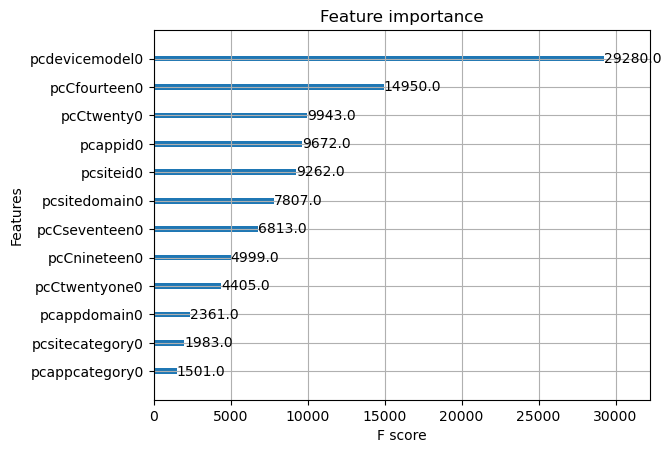

In [32]:
# 25.1 Which PC0 columns have high xgboost impt
_=xgb.plot_importance(model_vec_pc0)

In [90]:
pccols = ['devicemodel','Cfourteen','Ctwenty','appid','siteid','sitedomain',
          'Cseventeen','Cnineteen','Ctwentyone','appdomain','sitecategory','appcategory']
len(pccols)

12

In [91]:
# 24.2 How good are pc0's of respective unit vectors and which one is most important?
#      Time features are not included.S

model_orig_few = xgb.XGBClassifier( n_estimators= 500,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 10,
                              subsample = 0.9,
                              random_state = rng,
                              reg_lambda = 1.5,
                           )


tr_X =    X_train[pccols]
test_X =  X_test[pccols]
ytrain =  y_train
ytest = y_test


model_orig_few.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[18:22:24] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[18:22:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1330 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.71708	validation_1-auc:0.71378
[18:22:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1374 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.71836	validation_1-auc:0.71480
[18:22:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1348 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.71933	validation_1-auc:0.71591
[18:22:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1436 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.72002	vali

[18:22:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1238 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.74066	validation_1-auc:0.73426
[18:22:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1476 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.74115	validation_1-auc:0.73462
[18:22:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1026 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.74162	validation_1-auc:0.73499
[18:22:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1206 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.74188	validation_1-auc:0.73519
[18:22:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[72]	validation_0-auc:0.74925	validation_1-auc:0.74006
[18:23:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 764 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.74941	validation_1-auc:0.74016
[18:23:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 660 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.74951	validation_1-auc:0.74022
[18:23:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1336 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.74987	validation_1-auc:0.74039
[18:23:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1098 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.75006	validation_1-auc:0.74047
[18:23:32] INFO: C:\Users\dev-admin\croot2\

[109]	validation_0-auc:0.75512	validation_1-auc:0.74296
[18:24:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 716 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.75524	validation_1-auc:0.74302
[18:24:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 512 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.75531	validation_1-auc:0.74307
[18:24:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 616 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.75539	validation_1-auc:0.74311
[18:24:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 776 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.75550	validation_1-auc:0.74315
[18:24:05] INFO: C:\Users\dev-admin\croo

[18:24:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 754 extra nodes, 0 pruned nodes, max_depth=10
[146]	validation_0-auc:0.75916	validation_1-auc:0.74448
[18:24:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 342 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.75919	validation_1-auc:0.74448
[18:24:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 470 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.75924	validation_1-auc:0.74449
[18:24:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 698 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.75934	validation_1-auc:0.74453
[18:24:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[182]	validation_0-auc:0.76227	validation_1-auc:0.74550
[18:25:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 382 extra nodes, 0 pruned nodes, max_depth=10
[183]	validation_0-auc:0.76231	validation_1-auc:0.74553
[18:25:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1056 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.76249	validation_1-auc:0.74561
[18:25:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 822 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.76258	validation_1-auc:0.74564
[18:25:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 918 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.76271	validation_1-auc:0.74566
[18:25:10] INFO: C:\Users\dev-admin\cro

[18:25:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 854 extra nodes, 0 pruned nodes, max_depth=10
[219]	validation_0-auc:0.76515	validation_1-auc:0.74630
[18:25:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 706 extra nodes, 0 pruned nodes, max_depth=10
[220]	validation_0-auc:0.76527	validation_1-auc:0.74635
[18:25:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 770 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.76536	validation_1-auc:0.74638
[18:25:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 396 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.76540	validation_1-auc:0.74641
[18:25:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[255]	validation_0-auc:0.76791	validation_1-auc:0.74698
[18:26:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 524 extra nodes, 0 pruned nodes, max_depth=10
[256]	validation_0-auc:0.76796	validation_1-auc:0.74701
[18:26:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 774 extra nodes, 0 pruned nodes, max_depth=10
[257]	validation_0-auc:0.76804	validation_1-auc:0.74703
[18:26:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 740 extra nodes, 0 pruned nodes, max_depth=10
[258]	validation_0-auc:0.76812	validation_1-auc:0.74704
[18:26:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 520 extra nodes, 0 pruned nodes, max_depth=10
[259]	validation_0-auc:0.76818	validation_1-auc:0.74705
[18:26:15] INFO: C:\Users\dev-admin\croo

[292]	validation_0-auc:0.77024	validation_1-auc:0.74755
[18:26:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 544 extra nodes, 0 pruned nodes, max_depth=10
[293]	validation_0-auc:0.77029	validation_1-auc:0.74756
[18:26:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 478 extra nodes, 0 pruned nodes, max_depth=10
[294]	validation_0-auc:0.77034	validation_1-auc:0.74757
[18:26:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 432 extra nodes, 0 pruned nodes, max_depth=10
[295]	validation_0-auc:0.77039	validation_1-auc:0.74758
[18:26:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 486 extra nodes, 0 pruned nodes, max_depth=10
[296]	validation_0-auc:0.77043	validation_1-auc:0.74759
[18:26:48] INFO: C:\Users\dev-admin\croo

[18:27:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 730 extra nodes, 0 pruned nodes, max_depth=10
[329]	validation_0-auc:0.77226	validation_1-auc:0.74788
[18:27:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 856 extra nodes, 0 pruned nodes, max_depth=10
[330]	validation_0-auc:0.77236	validation_1-auc:0.74790
[18:27:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 444 extra nodes, 0 pruned nodes, max_depth=10
[331]	validation_0-auc:0.77240	validation_1-auc:0.74791
[18:27:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 526 extra nodes, 0 pruned nodes, max_depth=10
[332]	validation_0-auc:0.77243	validation_1-auc:0.74791
[18:27:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[365]	validation_0-auc:0.77430	validation_1-auc:0.74817
[18:27:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=10
[366]	validation_0-auc:0.77432	validation_1-auc:0.74817
[18:27:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 576 extra nodes, 0 pruned nodes, max_depth=10
[367]	validation_0-auc:0.77436	validation_1-auc:0.74817
[18:27:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 454 extra nodes, 0 pruned nodes, max_depth=10
[368]	validation_0-auc:0.77440	validation_1-auc:0.74816
[18:27:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 500 extra nodes, 0 pruned nodes, max_depth=10
[369]	validation_0-auc:0.77445	validation_1-auc:0.74818
[18:27:53] INFO: C:\Users\dev-admin\croo

[18:28:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 404 extra nodes, 0 pruned nodes, max_depth=10
[402]	validation_0-auc:0.77597	validation_1-auc:0.74840
[18:28:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 460 extra nodes, 0 pruned nodes, max_depth=10
[403]	validation_0-auc:0.77600	validation_1-auc:0.74841
[18:28:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 554 extra nodes, 0 pruned nodes, max_depth=10
[404]	validation_0-auc:0.77605	validation_1-auc:0.74840
[18:28:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 422 extra nodes, 0 pruned nodes, max_depth=10
[405]	validation_0-auc:0.77607	validation_1-auc:0.74840
[18:28:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[438]	validation_0-auc:0.77759	validation_1-auc:0.74854
[18:28:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 742 extra nodes, 0 pruned nodes, max_depth=10
[439]	validation_0-auc:0.77765	validation_1-auc:0.74856
[18:28:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=10
[440]	validation_0-auc:0.77768	validation_1-auc:0.74856
[18:28:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 514 extra nodes, 0 pruned nodes, max_depth=10
[441]	validation_0-auc:0.77771	validation_1-auc:0.74857
[18:28:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 400 extra nodes, 0 pruned nodes, max_depth=10
[442]	validation_0-auc:0.77773	validation_1-auc:0.74857
[18:28:58] INFO: C:\Users\dev-admin\croo

[475]	validation_0-auc:0.77902	validation_1-auc:0.74868
[18:29:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 516 extra nodes, 0 pruned nodes, max_depth=10
[476]	validation_0-auc:0.77906	validation_1-auc:0.74869
[18:29:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 682 extra nodes, 0 pruned nodes, max_depth=10
[477]	validation_0-auc:0.77912	validation_1-auc:0.74870
[18:29:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 654 extra nodes, 0 pruned nodes, max_depth=10
[478]	validation_0-auc:0.77918	validation_1-auc:0.74871
[18:29:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 384 extra nodes, 0 pruned nodes, max_depth=10
[479]	validation_0-auc:0.77920	validation_1-auc:0.74871
[18:29:32] INFO: C:\Users\dev-admin\croo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [92]:
utils.savePythonObject(model_orig_few, "model_orig_few.pkl", avazudata)

Object saved to: c:\avazu\allmodels\datafiles\model_orig_few.pkl


In [93]:
model_orig_few = utils.restorePythonObject("model_orig_few.pkl", avazudata)

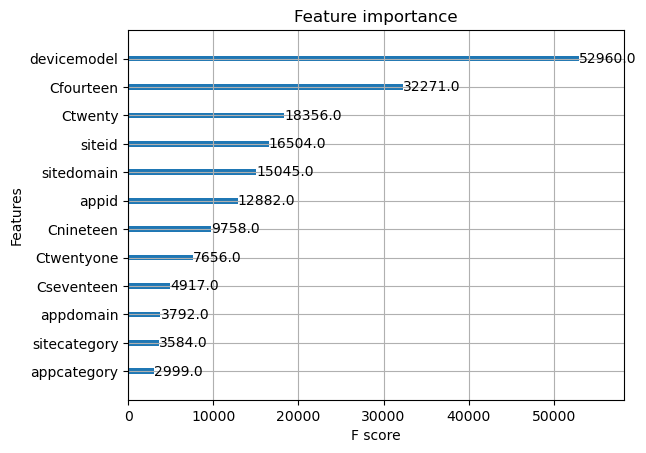

In [94]:
_=xgb.plot_importance(model_orig_few)


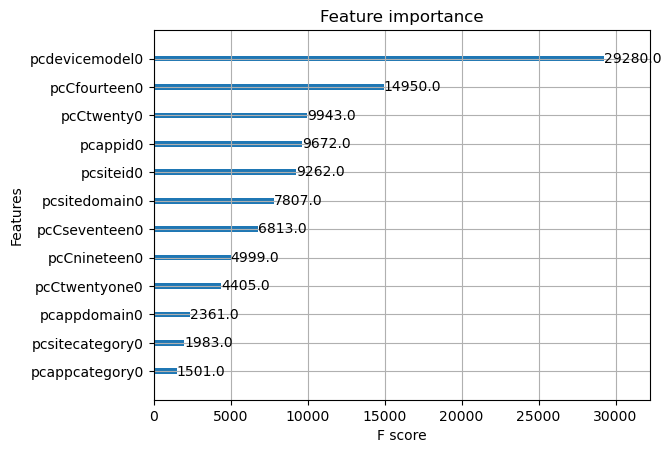

In [63]:
# 25.1 Which PC0 columns have high xgboost impt
_=xgb.plot_importance(model_vec_pc0)

In [71]:
# 24.1 Columns containing only Ist PCs:
cols = [i for i in cctr.columns if '0' in i]
print(cols)
len(cols)  # 12

['pcsiteid0', 'pcsitedomain0', 'pcsitecategory0', 'pcappid0', 'pcappdomain0', 'pcappcategory0', 'pcdevicemodel0', 'pcCfourteen0', 'pcCseventeen0', 'pcCnineteen0', 'pcCtwenty0', 'pcCtwentyone0']


12

In [72]:
# 27.0 Call imblearn library:
#       We find EditedNearestNeighbours the best in this case

from imblearn.under_sampling import EditedNearestNeighbours,OneSidedSelection,AllKNN
from imblearn.combine import SMOTEENN

In [73]:
# 27.1 Undersample/cleanup unitvectors data:

undersample = EditedNearestNeighbours()
X_res_pc0, y_res_pc0 = undersample.fit_resample(cctr[cols], y_train.values)


# 27.1.1 Data shape
X_res_pc0.shape  #  (3737267, 5)
y_res_pc0.shape  #  (3737267,)

(1089612, 12)

(1089612,)

In [75]:
# 27.1.2 Save above files
X_res_pc0.to_pickle(avazudata / "X_res_pc0.pkl")
y_res_pc0 = pd.DataFrame(y_res_pc0, columns= [ 'click'])
y_res_pc0.to_pickle(avazudata / "y_res_pc0.pkl")
gc.collect()

22

In [76]:
# 27.1.3 Read back
X_res_pc0 = pd.read_pickle(avazudata / "X_res_pc0.pkl")
y_res_pc0 = pd.read_pickle(avazudata / "y_res_pc0.pkl")
y_res_pc0.value_counts(normalize = True) # 76:23
y_train.value_counts(normalize = True) # 83:17

click
0        0.766074
1        0.233926
dtype: float64

0    0.830032
1    0.169968
Name: click, dtype: float64

In [77]:
# 27.2 xgboost Modeling with undersampled data
gc.collect()
model_res_pc0 = xgb.XGBClassifier( n_estimators= 400,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 10,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_res_pc0
test_X = ccte[cols]
ytrain = y_res_pc0
ytest =  y_test


model_res_pc0.fit(tr_X, ytrain.values,
          early_stopping_rounds = 100,
          eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['auc']
          )

0

[05:20:32] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[05:20:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1142 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.79124	validation_1-auc:0.71035
[05:20:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1180 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.79354	validation_1-auc:0.71204
[05:20:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1140 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.79565	validation_1-auc:0.71459
[05:20:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1122 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.79632	vali

[05:20:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 944 extra nodes, 0 pruned nodes, max_depth=10
[36]	validation_0-auc:0.82036	validation_1-auc:0.72979
[05:20:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 890 extra nodes, 0 pruned nodes, max_depth=10
[37]	validation_0-auc:0.82074	validation_1-auc:0.73007
[05:20:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 974 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-auc:0.82110	validation_1-auc:0.73023
[05:20:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 966 extra nodes, 0 pruned nodes, max_depth=10
[39]	validation_0-auc:0.82133	validation_1-auc:0.73039
[05:20:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.c

[72]	validation_0-auc:0.83357	validation_1-auc:0.73482
[05:21:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 912 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-auc:0.83386	validation_1-auc:0.73479
[05:21:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1304 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-auc:0.83435	validation_1-auc:0.73485
[05:21:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 714 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-auc:0.83451	validation_1-auc:0.73494
[05:21:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1108 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-auc:0.83515	validation_1-auc:0.73487
[05:21:20] INFO: C:\Users\dev-admin\croot2\

[109]	validation_0-auc:0.84357	validation_1-auc:0.73485
[05:21:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 530 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-auc:0.84370	validation_1-auc:0.73483
[05:21:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 796 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-auc:0.84402	validation_1-auc:0.73490
[05:21:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 486 extra nodes, 0 pruned nodes, max_depth=10
[112]	validation_0-auc:0.84410	validation_1-auc:0.73492
[05:21:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1188 extra nodes, 0 pruned nodes, max_depth=10
[113]	validation_0-auc:0.84444	validation_1-auc:0.73489
[05:21:45] INFO: C:\Users\dev-admin\cro

[05:22:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 826 extra nodes, 0 pruned nodes, max_depth=10
[146]	validation_0-auc:0.85010	validation_1-auc:0.73475
[05:22:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 912 extra nodes, 0 pruned nodes, max_depth=10
[147]	validation_0-auc:0.85026	validation_1-auc:0.73481
[05:22:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-auc:0.85029	validation_1-auc:0.73482
[05:22:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 414 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-auc:0.85039	validation_1-auc:0.73483
[05:22:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pru

[182]	validation_0-auc:0.85433	validation_1-auc:0.73450
[05:22:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 962 extra nodes, 0 pruned nodes, max_depth=10
[183]	validation_0-auc:0.85454	validation_1-auc:0.73449
[05:22:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 132 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-auc:0.85456	validation_1-auc:0.73450
[05:22:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 436 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-auc:0.85461	validation_1-auc:0.73452
[05:22:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 894 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-auc:0.85476	validation_1-auc:0.73414
[05:22:33] INFO: C:\Users\dev-admin\croo

[05:22:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 1058 extra nodes, 0 pruned nodes, max_depth=10
[219]	validation_0-auc:0.85868	validation_1-auc:0.73419
[05:22:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 650 extra nodes, 0 pruned nodes, max_depth=10
[220]	validation_0-auc:0.85873	validation_1-auc:0.73420
[05:22:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 880 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-auc:0.85890	validation_1-auc:0.73412
[05:22:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 886 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-auc:0.85904	validation_1-auc:0.73409
[05:22:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_pr

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [78]:
# 27.2.1 Save model:

utils.savePythonObject(model_res_pc0, "model_res_pc0.pkl", avazuestimators )

Object saved to: c:\avazu\allmodels\estimators\model_res_pc0.pkl


In [79]:
# 27.2.2 Restore model:

model_res_pc0 = utils.restorePythonObject("model_res_pc0.pkl", avazuestimators )

In [80]:
# 27.2.3 Best scores: 

model_res_pc0.best_score   # 0.7352568578802253
print("\n")
model_res_pc0.best_iteration  # 139

0.7352568578802253

139

In [81]:
# 27.2.4 Classification report:
pred_vec = model_res_pc0.predict(test_X)
uvec_cl=classification_report(ytest,pred_vec)
print(uvec_cl)

              precision    recall  f1-score   support

           0       0.86      0.90      0.88    414913
           1       0.38      0.31      0.34     84963

    accuracy                           0.80    499876
   macro avg       0.62      0.60      0.61    499876
weighted avg       0.78      0.80      0.79    499876



In [ ]:
## ROUGH

## A comparative picture

### Readback limited stored data

In [103]:

test_trans = pd.read_pickle(Path(avazudata) / "test_trans.pkl")
X_test = pd.read_pickle(Path(avazudata) / "X_test.pkl")
y_test = pd.read_pickle(Path(avazudata) / "y_test.pkl")


# 21.2.1 Reindex X_train/X_test for concatenation
#        of cat cols to be possible with transformed data
X_test = X_test.reset_index(drop = True)




# 21.2.4 Our list of cat cols
cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']  # 19 cols



# 21.2.5 Remaining cols not treated as cat cols:
rem_cols = ['day', 'dayofweek', 'hour_time', 'month','device_ip','device_id',]  # 6 cols

# 21.3 Concat rem_cols with transformed data:
# 21.4 Columns after transformeation to be considered. Ignore initial cat_cols
catcols = test_trans.columns[len(cat_cols):]

# 21.5 Now horizontally concatenate (exclude device_id and device):
X_test_trans = pd.concat([X_test[rem_cols[:4]], test_trans[cols] ], axis = 1)
                           

# 13.2.1 Read back saved imputed data:

X_test_trans_imputed = pd.read_pickle(Path(avazudata) / "X_test_trans_imputed.pkl")


# 14.1 Read back saved data:

pca_test =  pd.read_pickle(Path(avazudata) / "pca_test.pkl")

# 24.0 Read back cctr/ccte
ccte = pd.read_pickle(avazuunitvecs  / "ccte.pkl")
# 24.1 Columns containing only Ist PCs:
pc0cols = [i for i in ccte.columns if '0' in i]
Xte = X_test.copy()
_=Xte.pop('deviceid')
_=Xte.pop('deviceip')

pccols = ['devicemodel','Cfourteen','Ctwenty','appid','siteid','sitedomain',
          'Cseventeen','Cnineteen','Ctwentyone','appdomain','sitecategory','appcategory']


### Readback models

In [104]:
# Model with original data
model_orig = utils.restorePythonObject("model_orig.pkl", avazudata )

# Model with transformed data
model_trans = utils.restorePythonObject("model_trans.pkl", avazudata)


#Model with original data but without deviceid and deviceip
model_orig_noip = utils.restorePythonObject("model_orig_noip.pkl", avazudata)

# Model with important transfomed features
model_trans_impt = utils.restorePythonObject("model_trans_impt.pkl", avazudata)

# Get important features
fe_1 = utils.restorePythonObject("fe_1.pkl", avazuestimators)

# Model with 95% pca of transformed features
model_pca = utils.restorePythonObject("model_pca.pkl", avazudata)

# Model after EditedNearestNeighbours on 95% pca data
model_en = utils.restorePythonObject("model_en.pkl", avazudata)

# Model after smoteenn on 95% pca data
model_sm = utils.restorePythonObject("model_sm.pkl", avazudata)

# Model with only unitvectors data
model_vec = utils.restorePythonObject("model_vec.pkl", avazudata)

# Model with original data but with with those columns whose unitvectors are available
model_orig_few = utils.restorePythonObject("model_orig_few.pkl", avazudata)

# 24.4 Model with pc0 columns of unitvectors
model_vec_pc0 = utils.restorePythonObject("model_vec_pc0.pkl", avazuestimators  )

# Model after EditedNearestNeighbours on pc0 columns of unitvectors
model_res_pc0 = utils.restorePythonObject("model_res_pc0.pkl", avazuestimators )


### Results

In [111]:
# 35.0 An all inclusive comparative table

re1 = []
re2 = []
re3 = []
re4 = []
re5 = []
re6 = []
re7 = []
re8 = []
re9 = []
re10 = []
cols = ['pcapp0', 'pcip0', 'pcdevice0', 'pcchannel0', 'pcos0']
table = [re1,re2,re3,re4,re5,re6,re7,re8,re9]

# 35.1 Predictions
p1 = model_orig.predict(X_test)
p2=  model_trans.predict(X_test_trans)
p3 = model_orig_noip.predict(Xte)
p4 = model_trans_impt.predict(X_test_trans[fe_1])
p5 = model_pca.predict(pca_test)
p6 = model_en.predict(pca_test)
p7 = model_sm.predict(pca_test)
p8 = model_vec.predict(ccte)
p9 = model_vec_pc0.predict(ccte[pc0cols])
p10 = model_orig_few.predict(X_test[pccols])


# 35.2 Dataframe Index
str1 = "Modeling with orig data"
str2 = "Modeling with transformed data (no deviceid/deviceip)"
str3 = "Modeling with orig data (no deviceid/deviceip)"
str4 = "Modeling with impt transformed features"
str5 = "Modeling with PCAs of transformed data"
str6 = "PCA data cleaned up with EditedNearestNeighbours"
str7 = "PCA data cleaned up with SMOTEENN"
str8 = "Modeling with unitvectors data"
str9 = "Modeling with unitvectors data--only pc0s"
str10 = "Modeling with orig data but for which univectors exist"

# 35.3
re1.append(str1)
re2.append(str2)
re3.append(str3)
re4.append(str4)
re5.append(str5)
re6.append(str6)
re7.append(str7)
re8.append(str8 )
re9.append(str9)
re10.append(str10)


# 35.4 AUC first
s1 = model_orig.best_score
s2=  model_trans.best_score
s3 = model_orig_noip.best_score
s4 = model_trans_impt.best_score
s5 = model_pca.best_score
s6 = model_en.best_score
s7 = model_sm.best_score
s8 = model_vec.best_score
s9 = model_res_pc0.best_score
s10 = model_orig_few.best_score

# 35.5
re1.append(s1)
re2.append(s2 )
re3.append(s3)
re4.append(s4)
re5.append(s5)
re6.append(s6)
re7.append(s7) 
re8.append(s8)
re9.append(s9)
re10.append(s10)

# 35.6
f1 = f1_score(y_test.values, p1)
f2 = f1_score(y_test.values, p2) 
f3 = f1_score(y_test.values, p3)
f4 = f1_score(y_test.values, p4)
f5 = f1_score(y_test.values, p5)
f6 = f1_score(y_test.values, p6)
f7 = f1_score(y_test.values, p7)
f8 = f1_score(y_test.values, p8)
f9 = f1_score(y_test.values, p9)
f10 = f1_score(y_test.values, p10)

# 35.7
re1.append(f1)
re2.append(f2)
re3.append(f3)
re4.append(f4)
re5.append(f5)
re6.append(f6)
re7.append(f7)
re8.append(f8)
re9.append(f9)
re10.append(f10)

# 35.8 kappa score
k1 = cohen_kappa_score(y_test.values,p1)
k2 = cohen_kappa_score(y_test.values,p2) 
k3 = cohen_kappa_score(y_test.values,p3)
k4 = cohen_kappa_score(y_test.values,p4)
k5 = cohen_kappa_score(y_test.values,p5)
k6 = cohen_kappa_score(y_test.values,p6)
k7 = cohen_kappa_score(y_test.values,p7)
k8 = cohen_kappa_score(y_test.values,p8)
k9 = cohen_kappa_score(y_test.values,p9)
k10 = cohen_kappa_score(y_test.values,p10)

# 35.9
re1.append(k1)
re2.append(k2)
re3.append(k3)
re4.append(k4)
re5.append(k5)
re6.append(k6)
re7.append(k7)
re8.append(k8)
re9.append(k9)
re10.append(k10)


# 35.10 Accuracy score
a1 = accuracy_score(y_test.values,p1)
a2 = accuracy_score(y_test.values,p2) 
a3 = accuracy_score(y_test.values,p3)
a4 = accuracy_score(y_test.values,p4)
a5 = accuracy_score(y_test.values,p5)
a6 = accuracy_score(y_test.values,p6)
a7 = accuracy_score(y_test.values,p7)
a8 = accuracy_score(y_test.values,p8)
a9 = accuracy_score(y_test.values,p9)
a10 = accuracy_score(y_test.values,p10)

# 35.11
re1.append(a1)
re2.append(a2)
re3.append(a3)
re4.append(a4)
re5.append(a5)
re6.append(a6)
re7.append(a7)
re8.append(a8)
re9.append(a9)
re10.append(a10)

In [112]:
# 36.0 Print table now
out = pd.DataFrame({"AUC score": [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10] ,
                   "f1 score" : [f1,f2,f3,f4,f5,f6,f7,f8,f9,f10],
                   "kappa score" : [k1,k2,k3,k4,k5,k6,k7,k8,k9,k10],
                   "accuracy" : [a1,a2,a3,a4,a5,a6,a7,a8,a9,a10]},
                    index = [str1,str2,str3,str4,str5,str6,str7,str8,str9,str10])

print(f"\n               lightorange is min of column and lightgreen is max of a columns")
out.style.\
highlight_min(color = 'orange', axis = 0).\
highlight_max(color = 'lightgreen', axis = 0)


               lightorange is min of column and lightgreen is max of a columns


,AUC score,f1 score,kappa score,accuracy
Modeling with orig data,0.749783,0.153388,0.114899,0.834995
Modeling with transformed data (no deviceid/deviceip),0.752567,0.159266,0.119726,0.835345
Modeling with orig data (no deviceid/deviceip),0.750052,0.159395,0.119038,0.834871
Modeling with impt transformed features,0.752381,0.159908,0.119927,0.835185
Modeling with PCAs of transformed data,0.737825,0.143429,0.105836,0.833863
PCA data cleaned up with EditedNearestNeighbours,0.738499,0.367625,0.240096,0.787713
PCA data cleaned up with SMOTEENN,0.730988,0.402376,0.208824,0.637666
Modeling with unitvectors data,0.745940,0.139882,0.105751,0.835317
Modeling with unitvectors data--only pc0s,0.735257,0.124922,0.094008,0.834669
Modeling with orig data but for which univectors exist,0.748781,0.148389,0.111839,0.835317


## Some experiments
Feature Engineering with clustering


In [64]:
# 25.0 Create clustering features from unitvector dataframes:

n_components = 4  # No of components while performing PCA of every feature
fe_tr,fe_te = utils.featureEngKmeans(cctr,
                                     ccte,
                                     n_clusters = 10,  # No of clusters per feature
                                     step_size = n_components,
                                     km=True,  # Only perform KMeans
                                     gmm=False  # No Gaussian Mixture modeling
                                     )

# 25.1 Output is orig dataframe + clusters
fe_tr.head(3)
fe_te.head(3)

Current index:  0
Current index:  4
Current index:  8
Current index:  12
Current index:  16
Current index:  20
Current index:  24
Current index:  28
Current index:  32
Current index:  36
Current index:  40
Current index:  44


,pcsiteid0,pcsiteid1,pcsiteid2,pcsiteid3,pcsitedomain0,pcsitedomain1,pcsitedomain2,pcsitedomain3,pcsitecategory0,pcsitecategory1,...,clu2,clu3,clu4,clu5,clu6,clu7,clu8,clu9,clu10,clu11
0,2.889698,-0.597556,-0.605230,-0.983609,5.770558,-0.088779,0.976720,-0.682658,-6.472119,1.824779,...,1,0,1,0,8,0,1,5,5,2
1,-6.821252,-0.074456,0.273082,0.473605,-6.375553,-0.859748,0.679954,0.400250,1.803573,-2.779584,...,2,2,4,2,0,8,8,9,7,2
2,-6.821253,-0.073874,0.302884,0.500631,-6.375553,-0.859665,0.707247,0.438487,1.803671,-2.779428,...,2,2,4,1,0,3,0,5,1,2


,pcsiteid0,pcsiteid1,pcsiteid2,pcsiteid3,pcsitedomain0,pcsitedomain1,pcsitedomain2,pcsitedomain3,pcsitecategory0,pcsitecategory1,...,clu2,clu3,clu4,clu5,clu6,clu7,clu8,clu9,clu10,clu11
0,5.327249,1.232158,0.846737,0.695078,-2.509640,3.133112,-2.559268,-0.610693,-6.472470,1.827506,...,1,0,1,0,0,0,9,0,1,5
1,-6.821211,-0.073856,0.303019,0.497530,-6.375741,-0.859648,0.703604,0.442896,1.803659,-2.779504,...,2,1,4,1,0,3,5,1,1,6
2,4.224539,-1.295526,-1.220209,-0.389639,6.814605,-0.838232,0.547893,-1.040711,2.012367,-0.608370,...,3,0,1,0,1,2,5,7,1,6


In [65]:
# 25.2 Have a look at clusters created:
gc.collect()
colNames = [i for i in fe_tr.columns if "clu" in i] 

fe_tr[colNames].head()
fe_te[colNames].head()


0

,clu0,clu1,clu2,clu3,clu4,clu5,clu6,clu7,clu8,clu9,clu10,clu11
0,7,1,1,0,1,0,8,0,1,5,5,2
1,0,0,2,2,4,2,0,8,8,9,7,2
2,0,0,2,2,4,1,0,3,0,5,1,2
3,1,3,0,0,1,0,0,4,3,5,0,3
4,0,0,2,2,5,1,8,2,1,7,1,5


,clu0,clu1,clu2,clu3,clu4,clu5,clu6,clu7,clu8,clu9,clu10,clu11
0,1,2,1,0,1,0,0,0,9,0,1,5
1,0,0,2,1,4,1,0,3,5,1,1,6
2,2,1,3,0,1,0,1,2,5,7,1,6
3,2,1,3,0,1,0,8,2,5,1,1,5
4,0,0,2,2,3,1,0,2,1,1,1,2


In [66]:
# 25.3 Perform xgboost modeling using only the above clusters:

model_fe = xgb.XGBClassifier( n_estimators= 2000,
                              verbosity = 3,
                              eta = 0.1,
                              max_depth = 6,
                              subsample = 0.9,
                              random_state = rng,
                              #reg_lambda = 1.5,
                           )

tr_X =   fe_tr[colNames]
test_X =  fe_te[colNames]
ytrain =  y_train
ytest = y_test


model_fe.fit(tr_X, ytrain.values,
          early_stopping_rounds = 200,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )


[18:21:24] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[18:21:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.66579	validation_1-auc:0.66534
[18:21:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.66725	validation_1-auc:0.66664
[18:21:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.67263	validation_1-auc:0.67181
[18:21:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.67804	validation_1

[36]	validation_0-auc:0.70236	validation_1-auc:0.70165
[18:21:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[37]	validation_0-auc:0.70274	validation_1-auc:0.70203
[18:21:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[38]	validation_0-auc:0.70356	validation_1-auc:0.70287
[18:21:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[39]	validation_0-auc:0.70373	validation_1-auc:0.70302
[18:21:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[40]	validation_0-auc:0.70408	validation_1-auc:0.70336
[18:21:47] INFO: C:\Users\dev-admin\croot2\xgboos

[73]	validation_0-auc:0.71285	validation_1-auc:0.71178
[18:22:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[74]	validation_0-auc:0.71305	validation_1-auc:0.71197
[18:22:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[75]	validation_0-auc:0.71341	validation_1-auc:0.71234
[18:22:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[76]	validation_0-auc:0.71374	validation_1-auc:0.71264
[18:22:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[77]	validation_0-auc:0.71387	validation_1-auc:0.71277
[18:22:07] INFO: C:\Users\dev-admin\croot2\xgboos

[110]	validation_0-auc:0.71828	validation_1-auc:0.71682
[18:22:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[111]	validation_0-auc:0.71844	validation_1-auc:0.71697
[18:22:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[112]	validation_0-auc:0.71847	validation_1-auc:0.71699
[18:22:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[113]	validation_0-auc:0.71849	validation_1-auc:0.71702
[18:22:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[114]	validation_0-auc:0.71859	validation_1-auc:0.71711
[18:22:28] INFO: C:\Users\dev-admin\croot2\x

[147]	validation_0-auc:0.72114	validation_1-auc:0.71919
[18:22:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[148]	validation_0-auc:0.72120	validation_1-auc:0.71923
[18:22:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[149]	validation_0-auc:0.72129	validation_1-auc:0.71931
[18:22:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[150]	validation_0-auc:0.72133	validation_1-auc:0.71933
[18:22:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[151]	validation_0-auc:0.72138	validation_1-auc:0.71937
[18:22:48] INFO: C:\Users\dev-admin\croot2\x

[184]	validation_0-auc:0.72322	validation_1-auc:0.72082
[18:23:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[185]	validation_0-auc:0.72324	validation_1-auc:0.72084
[18:23:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[186]	validation_0-auc:0.72329	validation_1-auc:0.72087
[18:23:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[187]	validation_0-auc:0.72335	validation_1-auc:0.72093
[18:23:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[188]	validation_0-auc:0.72345	validation_1-auc:0.72100
[18:23:09] INFO: C:\Users\dev-admin\croot2\x

[221]	validation_0-auc:0.72467	validation_1-auc:0.72184
[18:23:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[222]	validation_0-auc:0.72472	validation_1-auc:0.72187
[18:23:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[223]	validation_0-auc:0.72476	validation_1-auc:0.72190
[18:23:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[224]	validation_0-auc:0.72481	validation_1-auc:0.72196
[18:23:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[225]	validation_0-auc:0.72485	validation_1-auc:0.72198
[18:23:29] INFO: C:\Users\dev-admin\croot2\x

[258]	validation_0-auc:0.72575	validation_1-auc:0.72266
[18:23:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[259]	validation_0-auc:0.72575	validation_1-auc:0.72266
[18:23:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[260]	validation_0-auc:0.72578	validation_1-auc:0.72268
[18:23:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[261]	validation_0-auc:0.72580	validation_1-auc:0.72269
[18:23:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[262]	validation_0-auc:0.72585	validation_1-auc:0.72274
[18:23:50] INFO: C:\Users\dev-admin\croot2\x

[295]	validation_0-auc:0.72671	validation_1-auc:0.72326
[18:24:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[296]	validation_0-auc:0.72673	validation_1-auc:0.72327
[18:24:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[297]	validation_0-auc:0.72676	validation_1-auc:0.72328
[18:24:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[298]	validation_0-auc:0.72679	validation_1-auc:0.72331
[18:24:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[299]	validation_0-auc:0.72682	validation_1-auc:0.72332
[18:24:11] INFO: C:\Users\dev-admin\croot2\x

[332]	validation_0-auc:0.72749	validation_1-auc:0.72368
[18:24:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[333]	validation_0-auc:0.72751	validation_1-auc:0.72368
[18:24:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[334]	validation_0-auc:0.72754	validation_1-auc:0.72370
[18:24:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[335]	validation_0-auc:0.72756	validation_1-auc:0.72372
[18:24:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[336]	validation_0-auc:0.72757	validation_1-auc:0.72370
[18:24:31] INFO: C:\Users\dev-admin\croot2\xg

[369]	validation_0-auc:0.72820	validation_1-auc:0.72409
[18:24:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[370]	validation_0-auc:0.72821	validation_1-auc:0.72409
[18:24:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[371]	validation_0-auc:0.72823	validation_1-auc:0.72410
[18:24:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[372]	validation_0-auc:0.72824	validation_1-auc:0.72410
[18:24:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[373]	validation_0-auc:0.72827	validation_1-auc:0.72410
[18:24:52] INFO: C:\Users\dev-admin\croot2\xg

[406]	validation_0-auc:0.72867	validation_1-auc:0.72432
[18:25:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[407]	validation_0-auc:0.72868	validation_1-auc:0.72431
[18:25:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[408]	validation_0-auc:0.72869	validation_1-auc:0.72431
[18:25:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[409]	validation_0-auc:0.72870	validation_1-auc:0.72432
[18:25:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[410]	validation_0-auc:0.72871	validation_1-auc:0.72433
[18:25:12] INFO: C:\Users\dev-admin\croot2\xg

[443]	validation_0-auc:0.72913	validation_1-auc:0.72451
[18:25:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[444]	validation_0-auc:0.72914	validation_1-auc:0.72450
[18:25:31] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[445]	validation_0-auc:0.72915	validation_1-auc:0.72451
[18:25:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[446]	validation_0-auc:0.72917	validation_1-auc:0.72453
[18:25:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[447]	validation_0-auc:0.72918	validation_1-auc:0.72453
[18:25:33] INFO: C:\Users\dev-admin\croot2\x

[480]	validation_0-auc:0.72957	validation_1-auc:0.72468
[18:25:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[481]	validation_0-auc:0.72959	validation_1-auc:0.72469
[18:25:52] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[482]	validation_0-auc:0.72961	validation_1-auc:0.72469
[18:25:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[483]	validation_0-auc:0.72961	validation_1-auc:0.72470
[18:25:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[484]	validation_0-auc:0.72962	validation_1-auc:0.72470
[18:25:54] INFO: C:\Users\dev-admin\croot2\xg

[517]	validation_0-auc:0.72999	validation_1-auc:0.72486
[18:26:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[518]	validation_0-auc:0.72999	validation_1-auc:0.72487
[18:26:12] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[519]	validation_0-auc:0.73001	validation_1-auc:0.72488
[18:26:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[520]	validation_0-auc:0.73003	validation_1-auc:0.72489
[18:26:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[521]	validation_0-auc:0.73004	validation_1-auc:0.72489
[18:26:14] INFO: C:\Users\dev-admin\croot2\x

[554]	validation_0-auc:0.73035	validation_1-auc:0.72501
[18:26:32] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[555]	validation_0-auc:0.73037	validation_1-auc:0.72503
[18:26:33] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[556]	validation_0-auc:0.73038	validation_1-auc:0.72502
[18:26:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[557]	validation_0-auc:0.73038	validation_1-auc:0.72503
[18:26:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[558]	validation_0-auc:0.73038	validation_1-auc:0.72502
[18:26:35] INFO: C:\Users\dev-admin\croot2\xgb

[591]	validation_0-auc:0.73069	validation_1-auc:0.72511
[18:26:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[592]	validation_0-auc:0.73070	validation_1-auc:0.72511
[18:26:53] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[593]	validation_0-auc:0.73071	validation_1-auc:0.72511
[18:26:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[594]	validation_0-auc:0.73072	validation_1-auc:0.72511
[18:26:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[595]	validation_0-auc:0.73073	validation_1-auc:0.72512
[18:26:55] INFO: C:\Users\dev-admin\croot2\x

[628]	validation_0-auc:0.73097	validation_1-auc:0.72521
[18:27:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[629]	validation_0-auc:0.73098	validation_1-auc:0.72522
[18:27:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[630]	validation_0-auc:0.73099	validation_1-auc:0.72522
[18:27:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[631]	validation_0-auc:0.73100	validation_1-auc:0.72522
[18:27:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[632]	validation_0-auc:0.73100	validation_1-auc:0.72522
[18:27:16] INFO: C:\Users\dev-admin\croot2\x

[665]	validation_0-auc:0.73129	validation_1-auc:0.72527
[18:27:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[666]	validation_0-auc:0.73129	validation_1-auc:0.72527
[18:27:34] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[667]	validation_0-auc:0.73130	validation_1-auc:0.72528
[18:27:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[668]	validation_0-auc:0.73131	validation_1-auc:0.72529
[18:27:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[669]	validation_0-auc:0.73132	validation_1-auc:0.72529
[18:27:36] INFO: C:\Users\dev-admin\croot2\x

[702]	validation_0-auc:0.73156	validation_1-auc:0.72535
[18:27:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[703]	validation_0-auc:0.73156	validation_1-auc:0.72535
[18:27:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[704]	validation_0-auc:0.73157	validation_1-auc:0.72535
[18:27:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[705]	validation_0-auc:0.73158	validation_1-auc:0.72535
[18:27:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[706]	validation_0-auc:0.73158	validation_1-auc:0.72535
[18:27:57] INFO: C:\Users\dev-admin\croot2\xg

[739]	validation_0-auc:0.73183	validation_1-auc:0.72543
[18:28:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[740]	validation_0-auc:0.73184	validation_1-auc:0.72543
[18:28:15] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[741]	validation_0-auc:0.73184	validation_1-auc:0.72542
[18:28:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[742]	validation_0-auc:0.73184	validation_1-auc:0.72543
[18:28:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[743]	validation_0-auc:0.73185	validation_1-auc:0.72543
[18:28:17] INFO: C:\Users\dev-admin\croot2\x

[776]	validation_0-auc:0.73205	validation_1-auc:0.72549
[18:28:35] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[777]	validation_0-auc:0.73205	validation_1-auc:0.72549
[18:28:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[778]	validation_0-auc:0.73207	validation_1-auc:0.72550
[18:28:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[779]	validation_0-auc:0.73207	validation_1-auc:0.72550
[18:28:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[780]	validation_0-auc:0.73208	validation_1-auc:0.72550
[18:28:38] INFO: C:\Users\dev-admin\croot2\x

[813]	validation_0-auc:0.73231	validation_1-auc:0.72557
[18:28:56] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[814]	validation_0-auc:0.73231	validation_1-auc:0.72556
[18:28:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[815]	validation_0-auc:0.73232	validation_1-auc:0.72556
[18:28:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[816]	validation_0-auc:0.73232	validation_1-auc:0.72557
[18:28:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[817]	validation_0-auc:0.73232	validation_1-auc:0.72557
[18:28:58] INFO: C:\Users\dev-admin\croot2\x

[850]	validation_0-auc:0.73250	validation_1-auc:0.72560
[18:29:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[851]	validation_0-auc:0.73251	validation_1-auc:0.72560
[18:29:17] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[852]	validation_0-auc:0.73251	validation_1-auc:0.72560
[18:29:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[853]	validation_0-auc:0.73252	validation_1-auc:0.72560
[18:29:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[854]	validation_0-auc:0.73252	validation_1-auc:0.72561
[18:29:19] INFO: C:\Users\dev-admin\croot2\x

[887]	validation_0-auc:0.73268	validation_1-auc:0.72562
[18:29:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[888]	validation_0-auc:0.73268	validation_1-auc:0.72562
[18:29:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[889]	validation_0-auc:0.73269	validation_1-auc:0.72563
[18:29:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[890]	validation_0-auc:0.73270	validation_1-auc:0.72563
[18:29:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[891]	validation_0-auc:0.73270	validation_1-auc:0.72563
[18:29:39] INFO: C:\Users\dev-admin\croot2\xg

[924]	validation_0-auc:0.73287	validation_1-auc:0.72568
[18:29:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[925]	validation_0-auc:0.73288	validation_1-auc:0.72567
[18:29:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[926]	validation_0-auc:0.73289	validation_1-auc:0.72567
[18:29:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[927]	validation_0-auc:0.73289	validation_1-auc:0.72567
[18:29:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[928]	validation_0-auc:0.73289	validation_1-auc:0.72567
[18:30:00] INFO: C:\Users\dev-admin\croot2\x

[961]	validation_0-auc:0.73305	validation_1-auc:0.72571
[18:30:18] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[962]	validation_0-auc:0.73305	validation_1-auc:0.72572
[18:30:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[963]	validation_0-auc:0.73305	validation_1-auc:0.72572
[18:30:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[964]	validation_0-auc:0.73306	validation_1-auc:0.72573
[18:30:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[965]	validation_0-auc:0.73306	validation_1-auc:0.72572
[18:30:21] INFO: C:\Users\dev-admin\croot2\xg

[998]	validation_0-auc:0.73322	validation_1-auc:0.72575
[18:30:39] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[999]	validation_0-auc:0.73323	validation_1-auc:0.72575
[18:30:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[1000]	validation_0-auc:0.73323	validation_1-auc:0.72575
[18:30:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1001]	validation_0-auc:0.73323	validation_1-auc:0.72575
[18:30:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[1002]	validation_0-auc:0.73324	validation_1-auc:0.72574
[18:30:41] INFO: C:\Users\dev-admin\croot2\

[1035]	validation_0-auc:0.73339	validation_1-auc:0.72578
[18:31:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[1036]	validation_0-auc:0.73340	validation_1-auc:0.72577
[18:31:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[1037]	validation_0-auc:0.73340	validation_1-auc:0.72578
[18:31:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1038]	validation_0-auc:0.73341	validation_1-auc:0.72578
[18:31:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1039]	validation_0-auc:0.73341	validation_1-auc:0.72578
[18:31:02] INFO: C:\Users\dev-admin\cro

[1072]	validation_0-auc:0.73355	validation_1-auc:0.72581
[18:31:20] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[1073]	validation_0-auc:0.73356	validation_1-auc:0.72581
[18:31:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1074]	validation_0-auc:0.73356	validation_1-auc:0.72581
[18:31:21] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[1075]	validation_0-auc:0.73357	validation_1-auc:0.72581
[18:31:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1076]	validation_0-auc:0.73357	validation_1-auc:0.72581
[18:31:22] INFO: C:\Users\dev-admin\croo

[1109]	validation_0-auc:0.73371	validation_1-auc:0.72586
[18:31:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1110]	validation_0-auc:0.73371	validation_1-auc:0.72586
[18:31:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[1111]	validation_0-auc:0.73371	validation_1-auc:0.72586
[18:31:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1112]	validation_0-auc:0.73371	validation_1-auc:0.72586
[18:31:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[1113]	validation_0-auc:0.73372	validation_1-auc:0.72586
[18:31:43] INFO: C:\Users\dev-admin\croo

[1146]	validation_0-auc:0.73384	validation_1-auc:0.72589
[18:32:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[1147]	validation_0-auc:0.73384	validation_1-auc:0.72589
[18:32:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1148]	validation_0-auc:0.73385	validation_1-auc:0.72589
[18:32:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[1149]	validation_0-auc:0.73385	validation_1-auc:0.72589
[18:32:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1150]	validation_0-auc:0.73385	validation_1-auc:0.72589
[18:32:04] INFO: C:\Users\dev-admin\cro

[1183]	validation_0-auc:0.73396	validation_1-auc:0.72591
[18:32:22] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1184]	validation_0-auc:0.73396	validation_1-auc:0.72591
[18:32:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[1185]	validation_0-auc:0.73397	validation_1-auc:0.72592
[18:32:23] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[1186]	validation_0-auc:0.73397	validation_1-auc:0.72592
[18:32:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1187]	validation_0-auc:0.73398	validation_1-auc:0.72592
[18:32:24] INFO: C:\Users\dev-admin\cro

[1220]	validation_0-auc:0.73411	validation_1-auc:0.72595
[18:32:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[1221]	validation_0-auc:0.73411	validation_1-auc:0.72594
[18:32:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1222]	validation_0-auc:0.73411	validation_1-auc:0.72595
[18:32:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1223]	validation_0-auc:0.73412	validation_1-auc:0.72595
[18:32:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1224]	validation_0-auc:0.73412	validation_1-auc:0.72595
[18:32:45] INFO: C:\Users\dev-admin\croo

[1257]	validation_0-auc:0.73424	validation_1-auc:0.72598
[18:33:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[1258]	validation_0-auc:0.73424	validation_1-auc:0.72598
[18:33:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[1259]	validation_0-auc:0.73425	validation_1-auc:0.72598
[18:33:04] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1260]	validation_0-auc:0.73425	validation_1-auc:0.72599
[18:33:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[1261]	validation_0-auc:0.73425	validation_1-auc:0.72598
[18:33:05] INFO: C:\Users\dev-admin\croot

[1294]	validation_0-auc:0.73437	validation_1-auc:0.72596
[18:33:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1295]	validation_0-auc:0.73437	validation_1-auc:0.72595
[18:33:24] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[1296]	validation_0-auc:0.73437	validation_1-auc:0.72596
[18:33:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1297]	validation_0-auc:0.73438	validation_1-auc:0.72596
[18:33:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1298]	validation_0-auc:0.73438	validation_1-auc:0.72595
[18:33:26] INFO: C:\Users\dev-admin\cro

[1331]	validation_0-auc:0.73449	validation_1-auc:0.72598
[18:33:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1332]	validation_0-auc:0.73449	validation_1-auc:0.72598
[18:33:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1333]	validation_0-auc:0.73450	validation_1-auc:0.72598
[18:33:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[1334]	validation_0-auc:0.73450	validation_1-auc:0.72598
[18:33:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1335]	validation_0-auc:0.73451	validation_1-auc:0.72598
[18:33:47] INFO: C:\Users\dev-admin\cro

[1368]	validation_0-auc:0.73461	validation_1-auc:0.72599
[18:34:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1369]	validation_0-auc:0.73461	validation_1-auc:0.72599
[18:34:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[1370]	validation_0-auc:0.73462	validation_1-auc:0.72599
[18:34:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1371]	validation_0-auc:0.73462	validation_1-auc:0.72599
[18:34:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[1372]	validation_0-auc:0.73463	validation_1-auc:0.72599
[18:34:07] INFO: C:\Users\dev-admin\croo

[1405]	validation_0-auc:0.73472	validation_1-auc:0.72603
[18:34:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[1406]	validation_0-auc:0.73472	validation_1-auc:0.72603
[18:34:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1407]	validation_0-auc:0.73472	validation_1-auc:0.72603
[18:34:26] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[1408]	validation_0-auc:0.73472	validation_1-auc:0.72604
[18:34:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[1409]	validation_0-auc:0.73473	validation_1-auc:0.72604
[18:34:27] INFO: C:\Users\dev-admin\cro

[1442]	validation_0-auc:0.73484	validation_1-auc:0.72604
[18:34:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1443]	validation_0-auc:0.73484	validation_1-auc:0.72603
[18:34:46] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1444]	validation_0-auc:0.73484	validation_1-auc:0.72603
[18:34:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[1445]	validation_0-auc:0.73484	validation_1-auc:0.72604
[18:34:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1446]	validation_0-auc:0.73485	validation_1-auc:0.72604
[18:34:48] INFO: C:\Users\dev-admin\cro

[1479]	validation_0-auc:0.73494	validation_1-auc:0.72605
[18:35:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1480]	validation_0-auc:0.73495	validation_1-auc:0.72605
[18:35:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[1481]	validation_0-auc:0.73495	validation_1-auc:0.72604
[18:35:07] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[1482]	validation_0-auc:0.73495	validation_1-auc:0.72605
[18:35:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1483]	validation_0-auc:0.73495	validation_1-auc:0.72605
[18:35:09] INFO: C:\Users\dev-admin\cro

[1516]	validation_0-auc:0.73505	validation_1-auc:0.72605
[18:35:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1517]	validation_0-auc:0.73505	validation_1-auc:0.72605
[18:35:27] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[1518]	validation_0-auc:0.73505	validation_1-auc:0.72605
[18:35:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[1519]	validation_0-auc:0.73506	validation_1-auc:0.72604
[18:35:28] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1520]	validation_0-auc:0.73506	validation_1-auc:0.72604
[18:35:29] INFO: C:\Users\dev-admin\cro

[1553]	validation_0-auc:0.73515	validation_1-auc:0.72605
[18:35:47] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1554]	validation_0-auc:0.73515	validation_1-auc:0.72605
[18:35:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[1555]	validation_0-auc:0.73515	validation_1-auc:0.72605
[18:35:48] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[1556]	validation_0-auc:0.73515	validation_1-auc:0.72605
[18:35:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1557]	validation_0-auc:0.73516	validation_1-auc:0.72606
[18:35:50] INFO: C:\Users\dev-admin\cro

[1590]	validation_0-auc:0.73523	validation_1-auc:0.72606
[18:36:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1591]	validation_0-auc:0.73523	validation_1-auc:0.72606
[18:36:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1592]	validation_0-auc:0.73524	validation_1-auc:0.72606
[18:36:09] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[1593]	validation_0-auc:0.73524	validation_1-auc:0.72605
[18:36:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[1594]	validation_0-auc:0.73524	validation_1-auc:0.72606
[18:36:10] INFO: C:\Users\dev-admin\croo

[1627]	validation_0-auc:0.73530	validation_1-auc:0.72606
[18:36:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[1628]	validation_0-auc:0.73531	validation_1-auc:0.72605
[18:36:29] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=6
[1629]	validation_0-auc:0.73531	validation_1-auc:0.72605
[18:36:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[1630]	validation_0-auc:0.73531	validation_1-auc:0.72605
[18:36:30] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=6
[1631]	validation_0-auc:0.73532	validation_1-auc:0.72605
[18:36:31] INFO: C:\Users\dev-admin\croo

[1664]	validation_0-auc:0.73540	validation_1-auc:0.72601
[18:36:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=6
[1665]	validation_0-auc:0.73540	validation_1-auc:0.72602
[18:36:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1666]	validation_0-auc:0.73540	validation_1-auc:0.72602
[18:36:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[1667]	validation_0-auc:0.73540	validation_1-auc:0.72601
[18:36:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[1668]	validation_0-auc:0.73541	validation_1-auc:0.72602
[18:36:51] INFO: C:\Users\dev-admin\croo

[1701]	validation_0-auc:0.73547	validation_1-auc:0.72603
[18:37:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=6
[1702]	validation_0-auc:0.73547	validation_1-auc:0.72603
[18:37:10] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[1703]	validation_0-auc:0.73547	validation_1-auc:0.72603
[18:37:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[1704]	validation_0-auc:0.73548	validation_1-auc:0.72603
[18:37:11] ======== Monitor (0): Learner ========
[18:37:11] Configure: 0.00043s, 1 calls @ 430us

[18:37:11] EvalOneIter: 456.555s, 1705 calls @ 456555143us

[18:37:11] GetGradient: 7.27549s, 1705 calls @ 7275494us

[18:37:11] PredictRaw: 0.009933s, 1705 calls @ 9

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=2000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [67]:
model_fe.best_score  # 0.7260767176778

model_fe.best_iteration # 1504


0.7260767176778516

1504

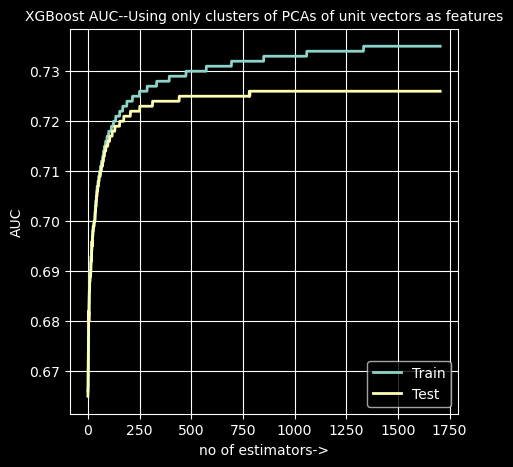

In [69]:
# 25.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_fe.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using only clusters of PCAs of unit vectors as features", fontsize = 10);

### Averaged unit vectors per level per feature
Unit vectors can be used look at clusters of features in Embedding Projector

In [68]:
# 26.0
train_trans['target'] = y_train

vec_trx , _ = ct.vectorsToTSV(train_trans,
                           take_mean = True,
                           filepath = avazuunitvecs,   # Folder where csv files will be saved
                           saveVectorsToDisk = True,
                           fnamesuffix = "_avg"
                           )

SyntaxError: invalid syntax (3228214416.py, line 18)

## Analysing Graphs
Deriving features directly from graphs


In [141]:
# 21.0 Path where .gml files are placed:

pathToFolder = avazugraphs
filelist = sorted(list(pathToFolder.iterdir()))
filelist[5:10]   # mgrid_bigraph_*


[WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Cfourteen.gml'),
 WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Cnineteen.gml'),
 WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Cone.gml'),
 WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Cseventeen.gml'),
 WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Csixteen.gml')]

### Read back data files

In [142]:
# 21.1 Just to recapitulate:

avazufolder = Path("D:\\avazu\\allmodels\\")
avazugraphs = avazufolder / "models"   # For graph file
avazudata = avazufolder / "datafiles"
avazuestimators = avazufolder / "estimators"  # For fitted estimators
avazuunitvecs = avazufolder / "unitvec"   # For unitvectors

In [143]:
# 21.2 Readback all saved files

train_trans = pd.read_pickle(Path(avazudata) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazudata) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazudata) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazudata) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazudata) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazudata) / "y_test.pkl")


# 21.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 21.2.2 Check
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 21.2.3
train_trans.shape   # (1499493, 591)
y_train.shape       # 
test_trans.shape    # (499831, 591)
y_test.shape        # 

# 21.2.4 Our cat cols
cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']  # 19 cols

# 21.2.5 Remaining cols not treated as cat cols:

rem_cols = ['day', 'dayofweek', 'hour_time', 'month','device_id', 'device_id']  # 6 cols


# 21.3 Concat rem_cols with transformed data:

# 21.4 Columns after transformeation to be considered. Ignore initial cat_cols
cols = train_trans.columns[len(cat_cols):]

# 21.5 Now horizontally concatenate:
X_train_trans = pd.concat([X_train[rem_cols[:4]], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols[:4]], test_trans[cols] ], axis = 1)
                           
# 21.6 Check
X_train_trans.shape  # (1499493, 576)
X_test_trans.shape   # (500374, 586)

# 21.7 And read back saved class object:
ct = utils.restorePythonObject("transformer.pkl", avazudata)
ct

# 
gc.collect()

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,1610,2741,5,1624,104,4,3356,1,...,0.086143,0.694915,0.141788,0.016860,0.508475,0.175684,0.022399,0.966102,0.144482,0.020157
1,1005,0,1610,2741,5,2110,30,4,4138,1,...,-0.005279,0.711864,0.142679,0.017328,0.288136,0.084613,0.015599,0.847458,0.137510,0.017518


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,1610,2741,5,2198,209,4,1012,1,...,0.074523,1.000000,0.165342,0.024729,0.796610,0.206639,0.037151,0.847458,0.136972,0.017598
1,1005,1,271,192,22,3617,110,0,4213,1,...,-0.027320,0.694915,0.141788,0.016860,0.050847,0.010373,0.005809,0.881356,0.139722,0.018241


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,1610,2741,5,1624,104,4,19447,744774,...,50,2507,0,35,-1,157,10,2,22,13
1,1005,0,1610,2741,5,2110,30,4,268552,187878,...,50,2681,1,419,100084,212,10,3,30,8


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,deviceid,deviceip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,1610,2741,5,2198,209,4,184577,264759,...,50,1996,1,41,100057,71,10,3,23,13
1,1005,1,271,192,22,3617,110,0,184577,65793,...,50,2371,0,559,100217,46,10,1,28,23


(1499493, 591)

(1499493,)

(499831, 591)

(499831,)

(1499493, 576)

(499831, 576)

CatEncodersFamily(cMeasures=[1, 1, 1, 0, None, 0, 0],
                  modelsPath=WindowsPath('D:/avazu/allmodels/models'),
                  pathToStoreProgress=WindowsPath('D:/avazu/allmodels'),
                  saveGraph=True)

0

In [145]:
# 22.0 Get sample list of projected and bigraphs:

projected = [str(i).split("\\")[-1] for i in filelist if 'appcategory_projected' in str(i)]
bigraphs = [str(i).split("\\")[-1] for i in filelist if 'appcategory_bigraph' in str(i)]
bigraphs = sorted(bigraphs, key=len)
bigraphs[:8]   # bigraph files
print("\n\n====\n")
projected = sorted(projected, key=len)
projected[:8]    # projected graph files

['appcategory_bigraph_Cone.gml',
 'appcategory_bigraph_appid.gml',
 'appcategory_bigraph_siteid.gml',
 'appcategory_bigraph_Ctwenty.gml',
 'appcategory_bigraph_Cfifteen.gml',
 'appcategory_bigraph_Csixteen.gml',
 'appcategory_bigraph_appdomain.gml',
 'appcategory_bigraph_bannerpos.gml']



====



['appcategory_projected_Cone.gml',
 'appcategory_projected_appid.gml',
 'appcategory_projected_siteid.gml',
 'appcategory_projected_Ctwenty.gml',
 'appcategory_projected_Cfifteen.gml',
 'appcategory_projected_Csixteen.gml',
 'appcategory_projected_appdomain.gml',
 'appcategory_projected_bannerpos.gml']

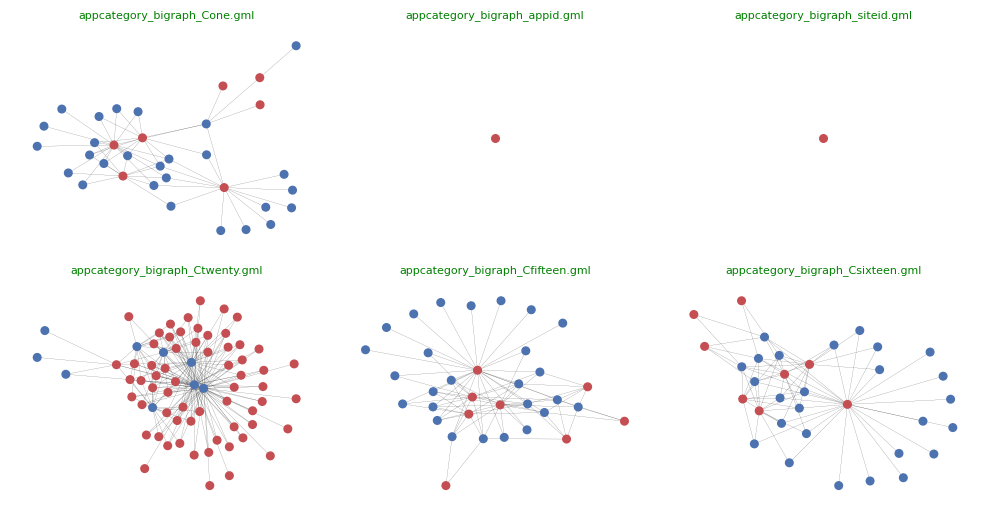

In [146]:
# 22.1 Plot of sample bigraphs:
plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(10,18));
for bi in bigraphs[:6]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    # Only show connedted nodes
    _= utils.plotBipartiteGraph( bi,
                                 avazugraphs,
                                 ax = ax,
                                 title = bi,
                                 connected=True,  # Show only connected nodes
                                 takeGraphSample=True # Do not show full graph but a sample of it
                                 )
    plt.tight_layout();

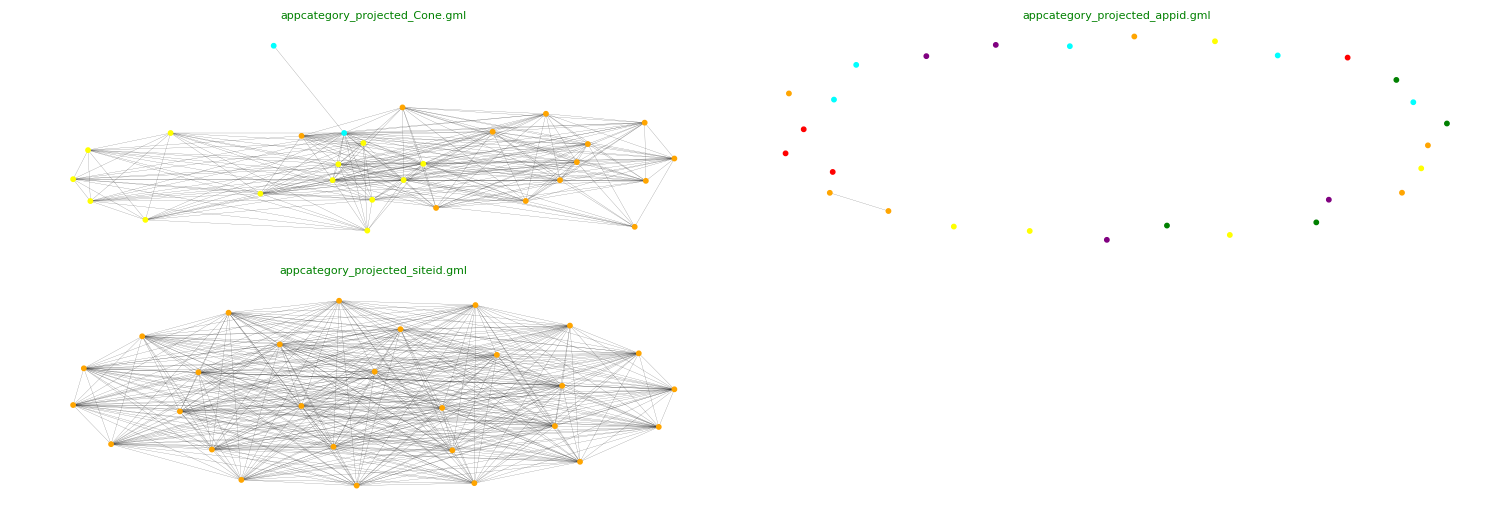

In [147]:
# 22.2 Plot of sample projected graph files
#      And community visualization within them
#      Modularity class is used to distinguish
#      communities:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:3]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,
                                   avazugraphs,
                                   ax = ax,
                                   k = 1.5,   # For spring_layout, to avoid crowding of nodes
                                   withLabels = False,
                                   node_size = 10,
                                   title = prj,
                                   takeGraphSample = True # Do not show full graph but a sample of it
                                   );
    plt.tight_layout();

In [148]:
# 23.0 Transform each column bin as per the community
#       to which it belongs:

# 23.1 Our transformed discrete cols are:
columnNames = cat_cols

# 23.2 Communities will be created as per this algo:
algolist = [nx.community.greedy_modularity_communities]

# 23.3 Graph files are within:
#pathToGraphFolder= Path("D:\\avazu\\allmodels\\models\\")

# 23.4 Perform transformation of both train_binned and test_binend:
# 23.4.1 List of transformed datframes as per difft algo used
fg_tr = []
fg_te = []
map_tr = []
map_te = []

# 23.4.2 PErform transformation to community structure
#  Takes lots of time...

for algo in algolist:
  print("\n..Transforming train data....")
  print("==========================\n")
  map1,df_tr = utils.transformBinnedDF2Communities(columnNames,avazugraphs,X_train[cat_cols], algo = algo)
  print("\n==========================")
  print("..Transforming test data....")
  print("==========================\n")
  map2,df_te = utils.transformBinnedDF2Communities(columnNames,avazugraphs,X_test[cat_cols], algo = algo)
  fg_tr.append(df_tr)
  fg_te.append(df_te)
  map_tr.append(map1)
  map_te.append(map2)


..Transforming train data....

Reading file:  siteid_projected_Cone.gml
Reading file:  siteid_projected_bannerpos.gml
Reading file:  siteid_projected_sitedomain.gml
Reading file:  siteid_projected_sitecategory.gml
Reading file:  siteid_projected_appid.gml
Reading file:  siteid_projected_appdomain.gml
Reading file:  siteid_projected_appcategory.gml
Reading file:  siteid_projected_devicemodel.gml
Reading file:  siteid_projected_devicetype.gml
Reading file:  siteid_projected_deviceconntype.gml
Reading file:  siteid_projected_Cfourteen.gml
Reading file:  siteid_projected_Cfifteen.gml
Reading file:  siteid_projected_Csixteen.gml
Reading file:  siteid_projected_Cseventeen.gml
Reading file:  siteid_projected_Ceighteen.gml
Reading file:  siteid_projected_Cnineteen.gml
Reading file:  siteid_projected_Ctwenty.gml
Reading file:  siteid_projected_Ctwentyone.gml
Reading file:  sitedomain_projected_Cone.gml
Reading file:  sitedomain_projected_bannerpos.gml
Reading file:  sitedomain_projected_siteid

In [149]:
# 24.0 Observe few rows of data transformed community wise:
fg_tr[0].shape   # (1501119, 212)/(1499493, 212)
print("\n--\n")
fg_te[0].shape   # (500374, 212)/(499831, 212)
print("\n--\n")
fg_tr[0].head(2)
fg_te[0].head(2)

(1499493, 212)


--



(499831, 212)


--



,siteid_projected_Cone.gml,siteid_projected_bannerpos.gml,siteid_projected_sitedomain.gml,siteid_projected_sitecategory.gml,siteid_projected_appid.gml,siteid_projected_appdomain.gml,siteid_projected_appcategory.gml,siteid_projected_devicemodel.gml,siteid_projected_devicetype.gml,siteid_projected_deviceconntype.gml,...,Ctwentyone_projected_appdomain.gml,Ctwentyone_projected_appcategory.gml,Ctwentyone_projected_devicemodel.gml,Ctwentyone_projected_devicetype.gml,Ctwentyone_projected_deviceconntype.gml,Ctwentyone_projected_Cfifteen.gml,Ctwentyone_projected_Csixteen.gml,Ctwentyone_projected_Ceighteen.gml,Ctwentyone_projected_Cnineteen.gml,Ctwentyone_projected_Ctwenty.gml
0,2,1,1,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,1,1
1,2,1,1,0,1,0,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0


,siteid_projected_Cone.gml,siteid_projected_bannerpos.gml,siteid_projected_sitedomain.gml,siteid_projected_sitecategory.gml,siteid_projected_appid.gml,siteid_projected_appdomain.gml,siteid_projected_appcategory.gml,siteid_projected_devicemodel.gml,siteid_projected_devicetype.gml,siteid_projected_deviceconntype.gml,...,Ctwentyone_projected_appdomain.gml,Ctwentyone_projected_appcategory.gml,Ctwentyone_projected_devicemodel.gml,Ctwentyone_projected_devicetype.gml,Ctwentyone_projected_deviceconntype.gml,Ctwentyone_projected_Cfifteen.gml,Ctwentyone_projected_Csixteen.gml,Ctwentyone_projected_Ceighteen.gml,Ctwentyone_projected_Cnineteen.gml,Ctwentyone_projected_Ctwenty.gml
0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0,0,1,0,0,0,0,1,0,0
1,1.0,1.0,1110.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,1,1,0,0,0,0,0,0


In [150]:
# 24.1 Remove constant columns from train data:
fg_tr[0] = utils.remConstColumns(fg_tr[0])

# 24.1.1 Keep same columns as above in test data:
fg_te[0] = fg_te[0][fg_tr[0].columns]

Datashape before processing: (1499493, 212)
Datashape after processing: (1499493, 161)


In [151]:
# 24.2 Save the list to gdrive:

utils.savePythonObject(fg_tr, "fg_tr.pkl", avazudata)
utils.savePythonObject(fg_te, "fg_te.pkl", avazudata)

Object saved to: D:\avazu\allmodels\datafiles\fg_tr.pkl
Object saved to: D:\avazu\allmodels\datafiles\fg_te.pkl


In [152]:
# 24.3

fg_tr = utils.restorePythonObject( "fg_tr.pkl", avazudata )
fg_te = utils.restorePythonObject( "fg_te.pkl", avazudata )
fg_tr[0].shape  # (1501119, 161)/(1499493, 161)
fg_te[0].shape  # (500374, 161)/(499831, 161)

(1499493, 161)

(499831, 161)

In [153]:
# 24.4 Check restoration:

fg_tr[0].head(2)
fg_te[0].head(2)

,siteid_projected_Cone.gml,siteid_projected_bannerpos.gml,siteid_projected_sitedomain.gml,siteid_projected_sitecategory.gml,siteid_projected_appid.gml,siteid_projected_devicemodel.gml,siteid_projected_devicetype.gml,siteid_projected_deviceconntype.gml,siteid_projected_Cfourteen.gml,siteid_projected_Cfifteen.gml,...,Ctwentyone_projected_Cone.gml,Ctwentyone_projected_siteid.gml,Ctwentyone_projected_appid.gml,Ctwentyone_projected_appcategory.gml,Ctwentyone_projected_devicemodel.gml,Ctwentyone_projected_devicetype.gml,Ctwentyone_projected_Csixteen.gml,Ctwentyone_projected_Ceighteen.gml,Ctwentyone_projected_Cnineteen.gml,Ctwentyone_projected_Ctwenty.gml
0,2,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,1,1
1,2,1,1,0,1,1,1,1,0,1,...,0,0,0,0,1,0,0,0,0,0


,siteid_projected_Cone.gml,siteid_projected_bannerpos.gml,siteid_projected_sitedomain.gml,siteid_projected_sitecategory.gml,siteid_projected_appid.gml,siteid_projected_devicemodel.gml,siteid_projected_devicetype.gml,siteid_projected_deviceconntype.gml,siteid_projected_Cfourteen.gml,siteid_projected_Cfifteen.gml,...,Ctwentyone_projected_Cone.gml,Ctwentyone_projected_siteid.gml,Ctwentyone_projected_appid.gml,Ctwentyone_projected_appcategory.gml,Ctwentyone_projected_devicemodel.gml,Ctwentyone_projected_devicetype.gml,Ctwentyone_projected_Csixteen.gml,Ctwentyone_projected_Ceighteen.gml,Ctwentyone_projected_Cnineteen.gml,Ctwentyone_projected_Ctwenty.gml
0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0,0,1,0,1,0,0,1,0,0
1,1.0,1.0,1110.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,1,0,0,1,1,0,0,0,0


## xgboost modeling with data transformed through community classes

In [155]:
# 25.0 Modeling with transformed train/test data with community indicators:

# As we repeat the process many times:
# Del the earlier result, if exists:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 250,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 13,
                                        subsample = 0.8,
                                        random_state = rng,
                                      )


tr_X =   fg_tr[0]
test_X = fg_te[0]
ytr = y_train
yte = y_test


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 50,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[13:05:34] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[13:05:37] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4044 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.73636	validation_1-auc:0.73064
[13:05:40] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3798 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.73914	validation_1-auc:0.73256
[13:05:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3880 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.74059	validation_1-auc:0.73384
[13:05:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3830 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.74183	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [156]:
# Save model object:

utils.savePythonObject(model_trans_commu, "model_trans_commu.pkl", avazudata)

Object saved to: D:\avazu\allmodels\datafiles\model_trans_commu.pkl


In [158]:
# Restore model object:

model_trans_commu = utils.restorePythonObject("model_trans_commu.pkl", avazudata)

### Learning curve

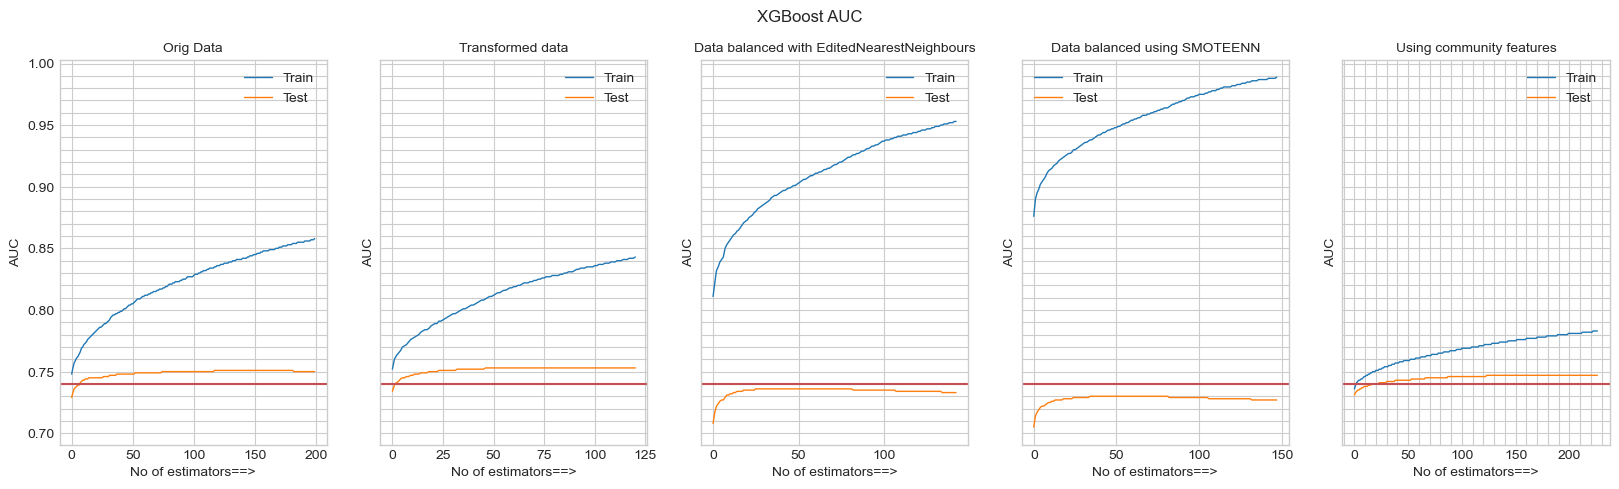

In [159]:
# 19.3 Learning curves: xgboost modeling"

plt.style.use('seaborn-v0_8-whitegrid')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,5, figsize = (20,5), sharey = True);
results = [model_orig.evals_result(), model_trans.evals_result(), model_en.evals_result(),model_sm.evals_result(), model_trans_commu.evals_result()]
title = ["Orig Data", "Transformed data", "Data balanced with EditedNearestNeighbours", 'Data balanced using SMOTEENN',"Using community features" ]
fig.suptitle("XGBoost AUC")
for i in range(5):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=1, label='Train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=1, label='Test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    plt.minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel('No of estimators==>')
    ax[i].set_title(title[i], fontsize = 10);
    ax[i].axhline(y=0.74, color='r', linestyle='-')

plt.show();

#### Classification report

In [160]:
# 25.2 Classification reports:

pred_comm = model_trans_commu.predict(test_X)
print(f"Classification report from community data: \n {classification_report(ytest,pred_comm)}")


Classification report from community data: 
               precision    recall  f1-score   support

           0       0.84      0.99      0.91    415087
           1       0.60      0.08      0.15     84744

    accuracy                           0.84    499831
   macro avg       0.72      0.54      0.53    499831
weighted avg       0.80      0.84      0.78    499831



In [ ]:
############# Done ###############

## ROUGH WORK

In [ ]:
# 21.2 Readback all saved files

train_trans = pd.read_pickle(Path(avazufolder) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazufolder) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazufolder) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazufolder) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazufolder) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazufolder) / "y_test.pkl")


# 21.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 21.2.2 Check
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 21.2.3
train_trans.shape   # (1501119, 599)
y_train.shape       # (1501119,)
test_trans.shape    # (500374, 599)
y_test.shape        # (500374,)

# 21.2.4 Our cat cols
cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']  # 19 cols

# 21.2.5 Remaining cols not treated as cat cols:

rem_cols = ['day', 'dayofweek','hour_time', 'month', 'device_id',  'device_ip']  # 6 cols


# 21.3 Concat rem_cols with transformed data:

# 21.4 Columns after transformeation to be considered. Ignore initial cat_cols
cols = train_trans.columns[len(cat_cols):]

# 21.5 Now horizontally concatenate:
X_train_trans = pd.concat([X_train[rem_cols[:4]], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols[:4]], test_trans[cols] ], axis = 1)
                           
# 21.6 Check
X_train_trans.shape  # (1501119, 586)
X_test_trans.shape   # (500374, 586)

# 21.7 And read back saved class object:
ct = utils.restorePythonObject("transformer.pkl", avazufolder)
ct

# 
gc.collect()

In [10]:
# 14.1 Read back saved data:

pca_train = pd.read_pickle(Path(avazufolder) / "pca_train.pkl")
pca_test =  pd.read_pickle(Path(avazufolder) / "pca_test.pkl")

# 14.1.1 Check
pca_train.head(3)
pca_test.head(3)

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc87,pc88,pc89,pc90,pc91,pc92,pc93,pc94,pc95,pc96
0,-0.849631,-0.462719,0.560084,0.103338,-0.274097,-0.368581,-0.839830,0.391659,-0.459640,0.165295,...,-0.235170,0.191174,0.061168,1.091684,-0.014206,0.195178,-0.525828,0.365271,-0.450755,0.633413
1,1.155139,0.278564,0.410264,-1.244982,0.711136,2.161509,1.152552,-0.602603,1.328864,-1.608991,...,7.061366,-0.712683,0.027135,-0.952509,3.091211,1.870719,-0.473455,-3.947109,3.381505,1.684289
2,-0.679183,-0.699284,-0.083493,0.025313,-0.233486,0.085268,-0.849323,0.032845,-0.439538,0.117099,...,0.224154,-0.034428,0.339811,0.868301,-0.223116,-1.030807,-0.455839,0.140223,-0.364641,0.703816


,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc87,pc88,pc89,pc90,pc91,pc92,pc93,pc94,pc95,pc96
0,-0.771130,-0.453043,0.095163,0.557658,-0.344208,-0.033671,-0.710520,0.435808,-0.115957,1.102022,...,0.177579,-0.462857,-0.303582,-0.536073,-0.035448,-0.485754,-0.589400,0.886848,-0.017880,-0.268141
1,-0.752837,-0.339575,0.088783,-1.141025,-0.199802,0.185162,0.043599,0.124799,-1.227015,0.896823,...,-0.518168,-0.111798,0.725304,-0.462391,-0.174001,-0.462952,1.012376,-1.013665,-0.281133,-0.180926
2,-0.827908,-0.954810,-0.000639,-0.099604,0.415293,-0.110808,0.136972,-0.378553,-1.093366,0.855857,...,-0.710794,0.551108,0.100063,0.058558,-0.215256,-0.200750,0.266654,-0.267910,0.074544,0.263067


In [21]:
from imblearn.under_sampling import InstanceHardnessThreshold, RepeatedEditedNearestNeighbours, NeighbourhoodCleaningRule,OneSidedSelection
from imblearn.combine import SMOTEENN

In [12]:
inst = InstanceHardnessThreshold()
start = time.time()
X_res, y_res = inst.fit_resample(pca_train, y_train)
end = time.time()
print((end - start)/60)


In [13]:
X_res.shape  # (548699, 97)
y_res.shape  # (548699,)

(548699, 97)

(548699,)

In [14]:

model_km = xgb.XGBClassifier( n_estimators= 450,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.8,
                              random_state = 890,
                           )

## NOTE THIS IS WITHOT resource column
tr_X =    X_res
test_X =  pca_test
ytrain =  y_res
ytest = y_test


model_km.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )
     

[15:00:36] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[15:00:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3780 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.93528	validation_1-auc:0.69267
[15:00:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3834 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.94281	validation_1-auc:0.69800
[15:00:43] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3868 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.94824	validation_1-auc:0.70308
[15:00:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4184 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.95010	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=450, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [16]:
# 24.3 Classification report:

pred_km = model_km.predict(test_X)
print(classification_report(ytest,pred_km))


              precision    recall  f1-score   support

           0       0.94      0.41      0.58    414878
           1       0.23      0.88      0.37     84806

    accuracy                           0.49    499684
   macro avg       0.59      0.65      0.47    499684
weighted avg       0.82      0.49      0.54    499684



In [ ]:
# 24.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("default")
plt.figure(figsize = (5,5));
results = model_km.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using PCAs of unit vectors as features", fontsize= 10);

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [19]:
cm = confusion_matrix(y_test, pred_km, labels=model_km.classes_)

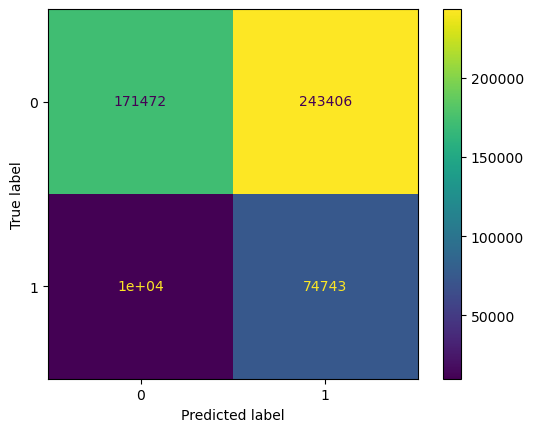

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_km.classes_)
disp.plot()

In [23]:
ncr = NeighbourhoodCleaningRule()
start = time.time()
X_res_ncr, y_res_ncr = ncr.fit_resample(pca_train, y_train)
end = time.time()
print((end - start)/60)


35.54191811879476


In [24]:
X_res_ncr.shape  # (1086165, 97)
y_res_ncr.shape  # (1086165, )

(1086165, 97)

(1086165,)

In [25]:

model_ncr = xgb.XGBClassifier( n_estimators= 450,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.8,
                              random_state = 890,
                           )

## NOTE THIS IS WITHOT resource column
tr_X =    X_res_ncr
test_X =  pca_test
ytrain =  y_res_ncr
ytest = y_test


model_ncr.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )
     

[05:24:44] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[05:24:49] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4136 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.78990	validation_1-auc:0.70346
[05:24:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 3772 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.80119	validation_1-auc:0.71216
[05:24:59] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4058 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.80691	validation_1-auc:0.71571
[05:25:03] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4020 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.81086	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=450, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [27]:
model_ncr.best_score  # 0.73726971

0.7372697120689804

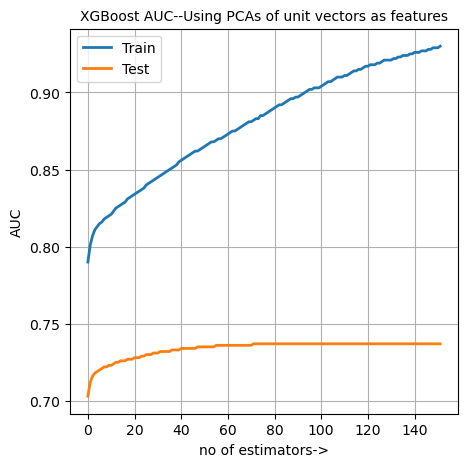

In [28]:
# 24.4 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("default")
plt.figure(figsize = (5,5));
results = model_ncr.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.xlabel('no of estimators->')
plt.title("XGBoost AUC--Using PCAs of unit vectors as features", fontsize= 10);

In [29]:
# 24.3 Classification report:

pred_ncr = model_ncr.predict(test_X)
print(classification_report(ytest,pred_ncr))


              precision    recall  f1-score   support

           0       0.87      0.88      0.87    414878
           1       0.37      0.35      0.36     84806

    accuracy                           0.79    499684
   macro avg       0.62      0.61      0.62    499684
weighted avg       0.78      0.79      0.79    499684



In [ ]:
####################